# Simulation Study Results

## Section 4 + Supplementary Material B 1
-------------------------------------

This notebook contains the "Section 4: Simulation Study" results and the complimentary Supplementary Material Section B 1.

<div class="alert alert-block alert-warning">
<b>PACKAGE REQUIREMENT:</b> Package "sourceinversion". Install using:<br>
pip install -q sourceinversion
</div>

In [1]:
# pip install -q sourceinversion

<div class="alert alert-block alert-info">
<b>DATA:</b> Need to replace data file paths with your own local path. The files are all located in the folder:<br>
Paper 1: Code/Data/...
</div>

<br><br><br>

### Importing "sourceinversion" package 

In [2]:
import sourceinversion.atmospheric_measurements as gp

### Libraries

In [3]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pickle
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FixedLocator
import numpy as np
import jax.numpy as jnp
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker

<br><br><br><br><br><br>

# Supplementary Material B

# Section 1: Varying Parameters

<br>

### Level M Set-up

Creating sensor layout

C:\Users\teresa-klatzer\code\Probabilistic-Inversion-Modeling-of-Gas-Emissions-Fork\Sourceinversion\sourceinversion\atmospheric_measurements\atmospheric_measurements.py:325: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x_coords[i], y_coords[i], z_coords[i], s=55, c=colors[i], marker='*')


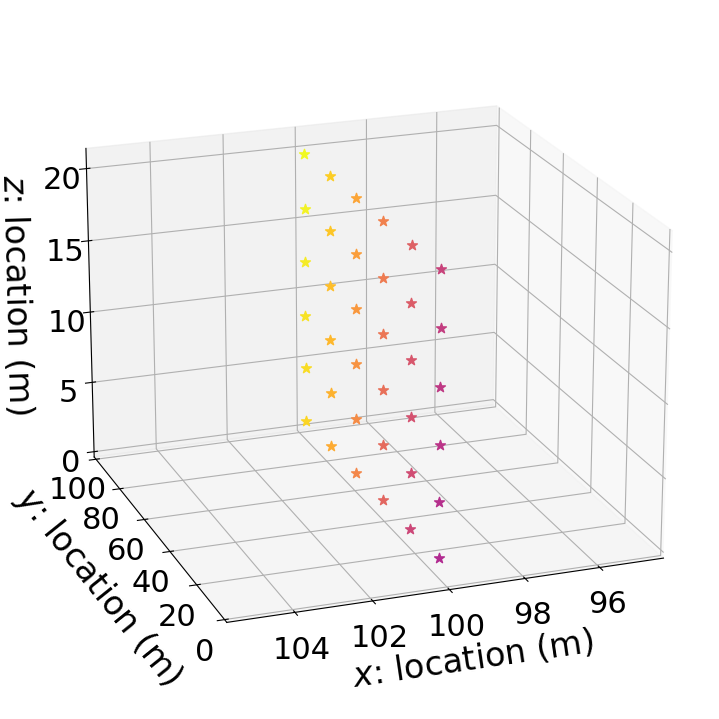

In [4]:
# Create a grid of points
p1 = (100,5,1)
p2 = (100,5,20)
p3 = (100,95,1)
p4 = (100,95,20)
number_of_sensors = 36
layout = "grid"
sensor_location = gp.SensorsSettings.grid_of_sensors(p1, p2, p3, p4, number_of_sensors, layout)

# Plot the points in the grid
gp.SensorsSettings.plot_points_3d(sensor_location, False)

Defining the atmospheric and source conditions, the windfield, and the sensor measurements.

In [5]:
grid = gp.Grid(
    x_range = (jnp.array(0.0), jnp.array(110.0)), 
    y_range = (jnp.array(0.0), jnp.array(110.0)),
    z_range= (jnp.array(0), jnp.array(0)),
    dx = jnp.array(0.1),
    dy = jnp.array(0.1),
    dz = jnp.array(1),
)

source_location = gp.SourceLocation(
    source_location_x = jnp.array([50.0]),
    source_location_y = jnp.array([50.0]),
    source_location_z = jnp.array([5.0]),
)

wind_field = gp.WindField(
    Ornstein_Uhlenbeck = False,
    initial_wind_speed = jnp.array(6.0),
    initial_wind_direction = jnp.array(-70),
    end_wind_direction = jnp.array(70),
    number_of_time_steps = jnp.array(100),
    time_step = jnp.array(1.0),
    wind_speed_temporal_std = jnp.array(0.1),
    wind_direction_temporal_std = jnp.array(10.0),
    wind_temporal_correlation = jnp.array(0.5),
    wind_speed_seed = 2,
    wind_direction_seed = 4,
)

atmospheric_state = gp.AtmosphericState(
    emission_rate = jnp.array([0.00039]),                           # 0.00039kg/s = 1.41kg/h. To scale parameter like distances (0.00039 * 100_000) = 39.0
    source_half_width = jnp.array(0.5),                             # source is a square of 2m side length
    max_abl = jnp.array(1000.0),
    background_mean = jnp.array(2.0),       
    background_std = jnp.array(1e-2),       
    background_seed = jnp.array(56),
    background_filter = "power_law",        
    Gaussian_filter_kernel = 1,
    horizontal_opening_angle= 10.0,
    vertical_opening_angle = 10.0,
    a_horizontal = 1.0,
    a_vertical = 1.0,          
    b_horizontal = 1.0,
    b_vertical = 1.0,  
)

sensors_settings =  gp.SensorsSettings(
    layout = layout,
    sensor_number = jnp.array(number_of_sensors),
    measurement_error_var = jnp.array(1e-6),
    sensor_seed = jnp.array(5),
    measurement_error_seed = jnp.array(420),
    sensor_locations = sensor_location,
)

In [6]:
gaussianplume = gp.GaussianPlume(grid, source_location, wind_field, atmospheric_state, sensors_settings)
fixed = gaussianplume.fixed_objects_of_gridfree_coupling_matrix()
background = gp.BackgroundGas(grid, source_location, atmospheric_state)
sensors = gp.Sensors(gaussianplume, background, sensors_settings)
truth = sensors.temporal_sensors_measurements(grided=False, beam=False)
data = truth[0]

Polar graph plot

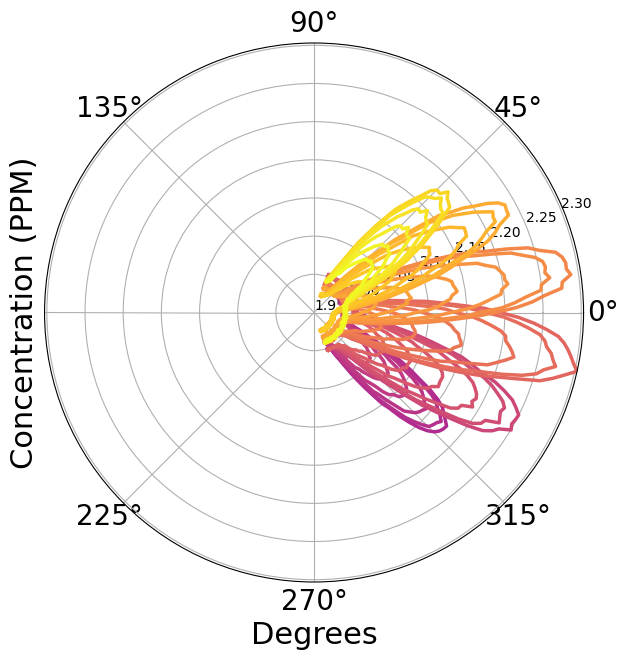

In [8]:
sensors.plot_polar_graph(save = False)

<Figure size 1000x1000 with 0 Axes>

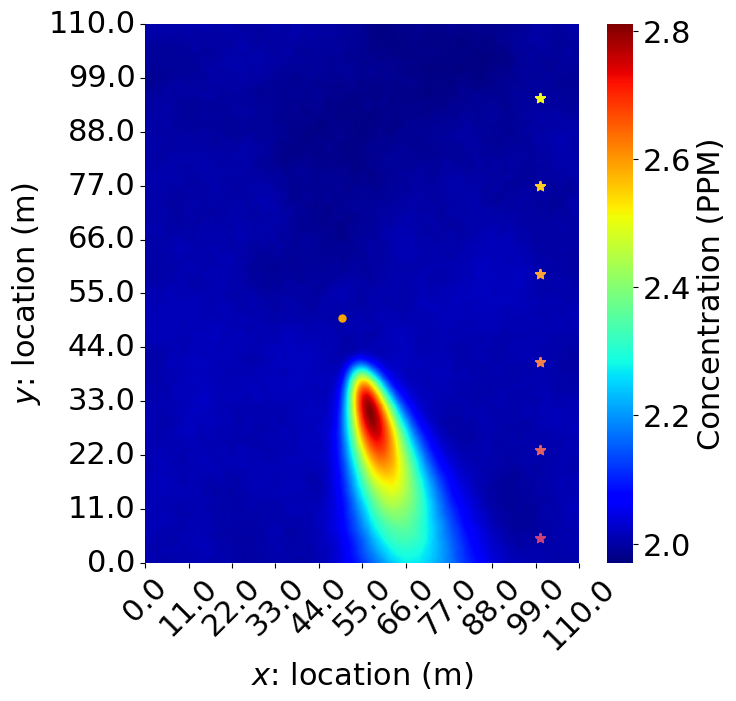

In [9]:
sensors.atmospheric_methane_and_sensors(False, format='png')

Level M MCMC parameter estimation chains:

<div class="alert alert-block alert-info">
<b>DATA:</b> Need to replace data file paths with your own local path. The files are all located in the folder:<br>
Paper 1: Code/Data/MCMC_chains/Simulation_study/Level_M_conditions/level_M.pkl
</div>

In [10]:
with open('../../Data/MCMC_chains/Simulation_study/Level_M_conditions/level_M.pkl', 'rb') as f:
    level_M = pickle.load(f)

C:\Users\teresa-klatzer\AppData\Local\Temp\ipykernel_16844\888687525.py:2: DeprecationWarning: Pickled array contains an aval with a named_shape attribute. This is deprecated and the code path supporting such avals will be removed. Please re-pickle the array.
  level_M = pickle.load(f)


## Varying Parameters Plotting Functions

In [11]:
# Function to format y-ticks in scientific notation
def format_tick(x, pos):
    return f'{x:.1e}'

formatter = FuncFormatter(format_tick)


In [12]:
def plot_source_location_estimates(burn_in, fixed_loc, data, dark=True, save=False):
    if dark:
        plt.style.use('dark_background')
        colors = cm.jet(np.linspace(0.2, 0.8, len(data)))
        dashed_line = 'white'
    else:
        plt.style.use('default')
        colors = cm.plasma(np.linspace(0.2, 0.8, len(data)))
        dashed_line = 'red'
    fig = plt.figure(figsize=(8, 8))
    gs = gridspec.GridSpec(2, 2, height_ratios=[1, 4], width_ratios=[4, 1])
    for i, mcmc_chain in enumerate(data.items()):
        # Main plot
        ax0 = plt.subplot(gs[2])
        if fixed_loc == True:
            ax0.plot(mcmc_chain[1]["source_x"][burn_in:], mcmc_chain[1]["source_y"][burn_in:], alpha=0.7, color=colors[i], lw=0.5, label=mcmc_chain[0])
            ax0.scatter(source_location.source_location_x, source_location.source_location_y, color=dashed_line, marker='x', s=100)
            ax0.set_xlabel("$x$: location (m)", fontsize=13)
        elif fixed_loc == False:
            ax0.plot(100 - mcmc_chain[1]["source_x"][burn_in:], mcmc_chain[1]["source_y"][burn_in:], alpha=0.7, color=colors[i], lw=0.5, label=mcmc_chain[0])
            ax0.scatter(30.0, 50.0, color=dashed_line, marker='x', s=100)
            ax0.scatter(50.0, 50.0, color=dashed_line, marker='x', s=100)
            ax0.scatter(70.0, 50.0, color=dashed_line, marker='x', s=100)
            ax0.set_xlabel("Distance from sensors (m)", fontsize=13)

        ax0.set_ylabel("$y$: location (m)", fontsize=13)
        ax0.legend(shadow=True, fancybox=True, loc='upper right', fontsize=10)

        # Plot above
        ax1 = plt.subplot(gs[0])
        ax1.plot(mcmc_chain[1]["source_x"][burn_in:], color=colors[i], lw=0.5, alpha=0.7)
        if fixed_loc == True:
            ax1.axhline(source_location.source_location_x, color=dashed_line, linestyle='--', lw=0.5)
        elif fixed_loc == False:
            ax1.axhline(30.0, color=dashed_line, linestyle='--', lw=0.5)
            ax1.axhline(50.0, color=dashed_line, linestyle='--', lw=0.5)
            ax1.axhline(70.0, color=dashed_line, linestyle='--', lw=0.5)
        ax1.set_ylabel("$x$: location (m)")
        ax1.set_xlabel("Iterations")

        # Plot on the right
        ax2 = plt.subplot(gs[3])
        ax2.plot(mcmc_chain[1]["source_y"][burn_in:], range(len(mcmc_chain[1]["source_y"][burn_in:])), alpha=0.7, lw=0.5, color=colors[i])
        if fixed_loc == True:
            ax2.axvline(source_location.source_location_y, color=dashed_line, linestyle='--', lw=0.5)
        elif fixed_loc == False:
            ax2.axvline(50.0, color=dashed_line, linestyle='--', lw=0.5)
        ax2.set_xlabel("$y$: location (m)")
        ax2.set_ylabel("Iterations")


        # Set the x-tick labels with rotation and use FixedLocator
        xticks = np.round(ax2.get_xticks(), 2)
        ax2.xaxis.set_major_locator(FixedLocator(xticks))
        ax2.set_xticklabels(xticks, rotation=45)
    
    plt.tight_layout()
    if save:
        plt.savefig('source_location_chains.png', dpi=300, bbox_inches='tight')
    plt.show()

In [13]:
def plot_source_location_densities(burn_in, fixed_loc, data, dark=True, save=False):
    if dark:
        plt.style.use('dark_background')
        colors = cm.jet(np.linspace(0.2, 0.8, len(data)))
        dashed_line = 'white'
    else:
        plt.style.use('default')
        colors = cm.plasma(np.linspace(0.2, 0.8, len(data)))
        dashed_line = 'red'
    fig = plt.figure(figsize=(10, 3.5))
    if fixed_loc == True:
        gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
        for i, mcmc_chain in enumerate(data.items()):
            # Main plot
            ax0 = plt.subplot(gs[0])
            sns.kdeplot(x=mcmc_chain[1]["source_x"].flatten()[burn_in:], color=colors[i], ax=ax0, fill=True, label=mcmc_chain[0])
            ax0.axvline(source_location.source_location_x, color=dashed_line, linestyle='--', lw=0.5)
            ax0.set_xlabel("$x$: location (m)", fontsize=12)
            ax0.set_ylabel("Density", fontsize=12)
            ax0.legend(shadow=True, fancybox=True, loc='upper right', fontsize=10)

            # Plot above
            ax1 = plt.subplot(gs[1])
            sns.kdeplot(x=mcmc_chain[1]["source_y"].flatten()[burn_in:], color=colors[i], ax=ax1, fill=True, label=mcmc_chain[0])
            ax1.axvline(source_location.source_location_y, color=dashed_line, linestyle='--', lw=0.5)
            ax1.set_ylabel("Density", fontsize=12)
            ax1.set_xlabel("$y$: location (m)", fontsize=12)
    elif fixed_loc == False:
        gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 1])
        # Main plot
        ax0 = plt.subplot(gs[0])
        sns.kdeplot(x=100-data["30 m"]["source_x"].flatten()[burn_in:], color=colors[0], ax=ax0, fill=True, label="30 m")
        ax0.axvline(30.0, color=dashed_line, linestyle='--', lw=0.5)
        ax0.set_xlabel("Distance from sensor (m)", fontsize=12)
        ax0.set_ylabel("Density", fontsize=12)
        ax0.legend(shadow=True, fancybox=True, loc='upper right', fontsize=10)

        ax1 = plt.subplot(gs[1])
        sns.kdeplot(x=100-data["50 m"]["source_x"].flatten()[burn_in:], color=colors[1], ax=ax1, fill=True, label="50 m")
        ax1.axvline(50.0, color=dashed_line, linestyle='--', lw=0.5)
        ax1.set_xlabel("Distance from sensor (m)", fontsize=12)
        ax1.set_ylabel("Density", fontsize=12)
        ax1.legend(shadow=True, fancybox=True, loc='upper right', fontsize=10)

        ax2 = plt.subplot(gs[2])
        sns.kdeplot(x=100-data["70 m"]["source_x"].flatten()[burn_in:], color=colors[2], ax=ax2, fill=True, label="70 m")
        ax2.axvline(70.0, color=dashed_line, linestyle='--', lw=0.5)
        ax2.set_xlabel("Distance from sensor (m)", fontsize=12)
        ax2.set_ylabel("Density", fontsize=12)
        ax2.legend(shadow=True, fancybox=True, loc='upper right', fontsize=10)

        for i, mcmc_chain in enumerate(data.items()):
            ax3 = plt.subplot(gs[3])
            sns.kdeplot(x=mcmc_chain[1]["source_y"].flatten()[burn_in:], color=colors[i], ax=ax3, fill=True, label=mcmc_chain[0])
            ax3.axvline(source_location.source_location_y, color=dashed_line, linestyle='--', lw=0.5)
            ax3.set_xlabel("$y$: location (m)", fontsize=12)
            ax3.set_ylabel("Density", fontsize=12)

    plt.tight_layout()
    if save:
        plt.savefig('source_location_densities.png', dpi=300, bbox_inches='tight', transparent=False)
    plt.show()

In [14]:
def plot_source_emission_rate(burn_in, fixed_rate, data, dark=True, save=False):
    if dark:
        plt.style.use('dark_background')
        colors = cm.jet(np.linspace(0.2, 0.8, len(data)))
        dashed_line = 'white'
    else:
        plt.style.use('default')
        colors = cm.plasma(np.linspace(0.2, 0.8, len(data)))
        dashed_line = 'red'
    fig = plt.figure(figsize=(10, 3.5))
    gs = gridspec.GridSpec(1, 2, width_ratios=[7, 3]) 
    for i, mcmc_chain in enumerate(data.items()):
        
        ax0 = plt.subplot(gs[0])
        ax0.plot(mcmc_chain[1]["s"][burn_in:], color=colors[i], lw=0.5)
        if fixed_rate == True:
            ax0.axhline(y=atmospheric_state.emission_rate, color=dashed_line, linestyle='--', lw=0.5)
        elif fixed_rate == False:
            ax0.axhline(y=atmospheric_state.emission_rate/2, color=dashed_line, linestyle='--')
            ax0.axhline(y=atmospheric_state.emission_rate, color=dashed_line, linestyle='--')
            ax0.axhline(y=atmospheric_state.emission_rate*2, color=dashed_line, linestyle='--')
        ax0.set_ylabel('$s$: Emission rate (kg/s)', fontsize=15)
        ax0.yaxis.set_major_formatter(formatter)  # Apply the formatter to the y-axis
        ax0.set_xlabel('Iterations', fontsize=15)

        ax1 = plt.subplot(gs[1])
        sns.kdeplot(y=mcmc_chain[1]["s"].flatten()[burn_in:], color=colors[i], ax=ax1, fill=True, label=mcmc_chain[0])
        if fixed_rate == True:
            ax1.axhline(y=atmospheric_state.emission_rate, color=dashed_line, linestyle='--', lw=0.5)
        elif fixed_rate == False:
            ax1.axhline(y=atmospheric_state.emission_rate/2, color=dashed_line, linestyle='--')
            ax1.axhline(y=atmospheric_state.emission_rate, color=dashed_line, linestyle='--')
            ax1.axhline(y=atmospheric_state.emission_rate*2, color=dashed_line, linestyle='--')

        # Set the same y-axis limits for both plots
        ax1.set_ylim(ax0.get_ylim())
        
    ax1.set_yticks([])
    ax1.legend(shadow=True, fancybox=True, loc='upper right', fontsize=10)
    ax1.set_xlabel('Density', fontsize=15)


    plt.subplots_adjust(wspace=0) 
    plt.tight_layout()
    if save:
        plt.savefig('emission_rate_chains.png', dpi=300, bbox_inches='tight', transparent=False)
    plt.show()


In [15]:
def plot_sensor_measurement_error_variance(burn_in, data, dark=True, save=False):
    if dark:
        plt.style.use('dark_background')
        colors = cm.jet(np.linspace(0.2, 0.8, len(data)))
        dashed_line = 'white'
    else:
        plt.style.use('default')
        colors = cm.plasma(np.linspace(0.2, 0.8, len(data)))
        dashed_line = 'red'
    fig = plt.figure(figsize=(10, 3.5))
    gs = gridspec.GridSpec(1, 2, width_ratios=[7, 3]) 
    for i, mcmc_chain in enumerate(data.items()):
        
        ax0 = plt.subplot(gs[0])
        ax0.plot(mcmc_chain[1]["sigma_squared"][burn_in:], color=colors[i], lw=0.5)
        ax0.axhline(y=sensors_settings.measurement_error_var, color=dashed_line, linestyle='--', lw=0.5)
        ax0.set_ylabel('$\sigma^2$: Measurement error (PPM)', fontsize=12)
        ax0.yaxis.set_major_formatter(formatter)  # Apply the formatter to the y-axis
        ax0.set_xlabel('Iterations', fontsize=12)

        ax1 = plt.subplot(gs[1])
        sns.kdeplot(y=mcmc_chain[1]["sigma_squared"].flatten()[burn_in:], color=colors[i], ax=ax1, fill=True, label=mcmc_chain[0])
        ax1.axhline(y=sensors_settings.measurement_error_var, color=dashed_line, linestyle='--', lw=0.5)      

        # Set the same y-axis limits for both plots
        ax1.set_ylim(ax0.get_ylim())

    ax1.set_yticks([])
    ax1.legend(shadow=True, fancybox=True, loc='upper right', fontsize=10)
    ax1.set_xlabel('Density', fontsize=12)

    plt.subplots_adjust(wspace=0) 
    plt.tight_layout()
    if save:
        plt.savefig('measurement_error_variance_chains.png', dpi=300, bbox_inches='tight', transparent=False)
    plt.show()

In [16]:
def plot_background(burn_in, data, dark=True, save=False, sensor_layout = False):
    if dark:
        plt.style.use('dark_background')
        colors = cm.jet(np.linspace(0.2, 0.8, len(data)))
        dashed_line = 'white'
    else:
        plt.style.use('default')
        colors = cm.plasma(np.linspace(0.2, 0.8, len(data)))
        dashed_line = 'red'
    fig = plt.figure(figsize=(10, 7))
    gs = gridspec.GridSpec(1, 2, width_ratios=[7, 3]) 
    for i, mcmc_chain in enumerate(data.items()):
        ax0 = plt.subplot(gs[0])
        ax0.plot(mcmc_chain[1]["background"][:,0][burn_in:], color=colors[i], alpha=0.5, lw=0.5)
        ax0.plot(mcmc_chain[1]["background"][:,1][burn_in:], color=colors[i], alpha=0.5, lw=0.5)
        ax0.plot(mcmc_chain[1]["background"][:,2][burn_in:], color=colors[i], alpha=0.5, lw=0.5)
        ax0.plot(mcmc_chain[1]["background"][:,3][burn_in:], color=colors[i], alpha=0.5, lw=0.5)
        ax0.plot(mcmc_chain[1]["background"][:,4][burn_in:], color=colors[i], alpha=0.5, lw=0.5)
        ax0.plot(mcmc_chain[1]["background"][:,5][burn_in:], color=colors[i], alpha=0.5, lw=0.5)
        if sensor_layout == False:
            ax0.axhline(y=jnp.unique(truth[4])[0], color=dashed_line, linestyle='--', lw=0.5)
            ax0.axhline(y=jnp.unique(truth[4])[1], color=dashed_line, linestyle='--', lw=0.5)
            ax0.axhline(y=jnp.unique(truth[4])[2], color=dashed_line, linestyle='--', lw=0.5)
            ax0.axhline(y=jnp.unique(truth[4])[3], color=dashed_line, linestyle='--', lw=0.5)
            ax0.axhline(y=jnp.unique(truth[4])[4], color=dashed_line, linestyle='--', lw=0.5)
            ax0.axhline(y=jnp.unique(truth[4])[5], color=dashed_line, linestyle='--', lw=0.5)
        ax0.set_ylabel('Background (PPM)', fontsize = 15)
        #ax6.yaxis.set_major_formatter(formatter)  # Apply the formatter to the y-axis
        ax0.set_xlabel('Iteration', fontsize = 15)

        ax1 = plt.subplot(gs[1])
        sns.kdeplot(y=mcmc_chain[1]["background"][:,0].flatten()[burn_in:], color=colors[i], ax=ax1, fill=True, label=mcmc_chain[0])
        sns.kdeplot(y=mcmc_chain[1]["background"][:,1].flatten()[burn_in:], color=colors[i], ax=ax1, fill=True)
        sns.kdeplot(y=mcmc_chain[1]["background"][:,2].flatten()[burn_in:], color=colors[i], ax=ax1, fill=True)
        sns.kdeplot(y=mcmc_chain[1]["background"][:,3].flatten()[burn_in:], color=colors[i], ax=ax1, fill=True)
        sns.kdeplot(y=mcmc_chain[1]["background"][:,4].flatten()[burn_in:], color=colors[i], ax=ax1, fill=True)
        sns.kdeplot(y=mcmc_chain[1]["background"][:,5].flatten()[burn_in:], color=colors[i], ax=ax1, fill=True)
        if sensor_layout == False:
            ax1.axhline(y=jnp.unique(truth[4])[0], color=dashed_line, linestyle='--', lw=0.5)
            ax1.axhline(y=jnp.unique(truth[4])[1], color=dashed_line, linestyle='--', lw=0.5)
            ax1.axhline(y=jnp.unique(truth[4])[2], color=dashed_line, linestyle='--', lw=0.5)
            ax1.axhline(y=jnp.unique(truth[4])[3], color=dashed_line, linestyle='--', lw=0.5)
            ax1.axhline(y=jnp.unique(truth[4])[4], color=dashed_line, linestyle='--', lw=0.5)
            ax1.axhline(y=jnp.unique(truth[4])[5], color=dashed_line, linestyle='--', lw=0.5)
        ax1.set_yticks([])
        ax1.legend(shadow=True, fancybox=True, loc='upper right', fontsize=10)
        ax1.set_xlabel('Density', fontsize=15)


        # Set the same y-axis limits for both plots
        ax1.set_ylim(ax0.get_ylim())

    plt.subplots_adjust(wspace=0) 
    plt.tight_layout()
    if save:
        plt.savefig('background_chains.png', dpi=300, bbox_inches='tight', transparent=False)
    plt.show()


In [17]:
def plot_diffusion_parameters(burn_in, fixed_wind_sigmas, data, dark=True, save=False):
    fig = plt.figure(figsize=(10, 14))
    gs = gridspec.GridSpec(4, 2, width_ratios=[7, 3]) 
    if dark:
        plt.style.use('dark_background')
        colors = cm.jet(np.linspace(0.2, 0.8, len(data)))
        dashed_line = 'white'
    else:
        plt.style.use('default')
        colors = cm.plasma(np.linspace(0.2, 0.8, len(data)))
        dashed_line = 'red'
    for i, mcmc_chain in enumerate(data.items()):
        # a_h plots
        ax0 = plt.subplot(gs[0])
        ax0.plot(mcmc_chain[1]["a_H"][burn_in:], color=colors[i], lw=0.5)
        if fixed_wind_sigmas == True:
            ax0.axhline(y=atmospheric_state.a_horizontal, color=dashed_line, linestyle='--', lw=0.5)
        else:
            ax0.axhline(y=1.4, color=dashed_line, linestyle='--', lw=0.5)
            ax0.axhline(y=1.0, color=dashed_line, linestyle='--', lw=0.5)
            ax0.axhline(y=0.9, color=dashed_line, linestyle='--', lw=0.5)
        ax0.set_ylabel('$a_H$', fontsize=15)
        ax0.yaxis.set_major_formatter(formatter)  # Apply the formatter to the y-axis
        ax0.set_xlabel('Iterations', fontsize=15)

        ax1 = plt.subplot(gs[1])
        sns.kdeplot(y=mcmc_chain[1]["a_H"].flatten()[burn_in:], color=colors[i], ax=ax1, fill=True, label=mcmc_chain[0])
        if fixed_wind_sigmas == True:
            ax1.axhline(y=atmospheric_state.a_horizontal, color=dashed_line, linestyle='--', lw=0.5)      
        else:
            ax1.axhline(y=1.4, color=dashed_line, linestyle='--', lw=0.5)
            ax1.axhline(y=1.0, color=dashed_line, linestyle='--', lw=0.5)
            ax1.axhline(y=0.9, color=dashed_line, linestyle='--', lw=0.5)
        # Set the same y-axis limits for both plots
        ax1.set_ylim(ax0.get_ylim())      
        ax1.set_yticks([])
        ax1.legend(shadow=True, fancybox=True, loc='upper right', fontsize=10)
        ax1.set_xlabel('Density', fontsize=15)
        

        # a_v plots
        ax2 = plt.subplot(gs[2])
        ax2.plot(mcmc_chain[1]["a_V"][burn_in:], color=colors[i], lw=0.5)
        if fixed_wind_sigmas == True:
            ax2.axhline(y=atmospheric_state.a_vertical, color=dashed_line, linestyle='--', lw=0.5)
        else:
            ax2.axhline(y=1.2, color=dashed_line, linestyle='--', lw=0.5)
            ax2.axhline(y=1.0, color=dashed_line, linestyle='--', lw=0.5)
            ax2.axhline(y=0.7, color=dashed_line, linestyle='--', lw=0.5)
        ax2.set_ylabel('$a_V$', fontsize=15)
        ax2.yaxis.set_major_formatter(formatter)  # Apply the formatter to the y-axis
        ax2.set_xlabel('Iterations', fontsize=15)

        ax3 = plt.subplot(gs[3])
        sns.kdeplot(y=mcmc_chain[1]["a_V"].flatten()[burn_in:], color=colors[i], ax=ax3, fill=True, label=mcmc_chain[0])
        if fixed_wind_sigmas == True:
            ax3.axhline(y=atmospheric_state.a_vertical, color=dashed_line, linestyle='--', lw=0.5)
        else:
            ax3.axhline(y=1.2, color=dashed_line, linestyle='--', lw=0.5)
            ax3.axhline(y=1.0, color=dashed_line, linestyle='--', lw=0.5)
            ax3.axhline(y=0.7, color=dashed_line, linestyle='--', lw=0.5)
        # Set the same y-axis limits for both plots
        ax3.set_ylim(ax2.get_ylim())
        ax3.set_yticks([])
        # ax3.legend(shadow=True, fancybox=True, loc='upper right', fontsize=10)
        ax3.set_xlabel('Density', fontsize=15)


        # b_h plots
        ax4 = plt.subplot(gs[4])
        ax4.plot(mcmc_chain[1]["b_H"][burn_in:], color=colors[i], lw=0.5)
        if fixed_wind_sigmas == True:
            ax4.axhline(y=atmospheric_state.b_horizontal, color=dashed_line, linestyle='--', lw=0.5)
        else:
            ax4.axhline(y=0.9, color=dashed_line, linestyle='--', lw=0.5)   
            ax4.axhline(y=1.0, color=dashed_line, linestyle='--', lw=0.5)   
            ax4.axhline(y=0.8, color=dashed_line, linestyle='--', lw=0.5)   
        ax4.set_ylabel('$b_H$', fontsize=15)
        ax4.yaxis.set_major_formatter(formatter)
        ax4.set_xlabel('Iterations', fontsize=15)

        ax5 = plt.subplot(gs[5])
        sns.kdeplot(y=mcmc_chain[1]["b_H"].flatten()[burn_in:], color=colors[i], ax=ax5, fill=True, label=mcmc_chain[0])
        if fixed_wind_sigmas == True:
            ax5.axhline(y=atmospheric_state.b_horizontal, color=dashed_line, linestyle='--', lw=0.5)
        else:
            ax5.axhline(y=0.9, color=dashed_line, linestyle='--', lw=0.5)
            ax5.axhline(y=1.0, color=dashed_line, linestyle='--', lw=0.5)
            ax5.axhline(y=0.8, color=dashed_line, linestyle='--', lw=0.5)
        # Set the same y-axis limits for both plots
        ax5.set_ylim(ax4.get_ylim())
        ax5.set_yticks([])
        # ax5.legend(shadow=True, fancybox=True, loc='upper right', fontsize=10)
        ax5.set_xlabel('Density', fontsize=15)


        # b_v plots
        ax6 = plt.subplot(gs[6])
        ax6.plot(mcmc_chain[1]["b_V"][burn_in:], color=colors[i], lw=0.5)
        if fixed_wind_sigmas == True:
            ax6.axhline(y=atmospheric_state.b_vertical, color=dashed_line, linestyle='--', lw=0.5)
        else:
            ax6.axhline(y=0.95, color=dashed_line, linestyle='--', lw=0.5)
            ax6.axhline(y=1.0, color=dashed_line, linestyle='--', lw=0.5)
            ax6.axhline(y=0.85, color=dashed_line, linestyle='--', lw=0.5)
        ax6.set_ylabel('$b_V$', fontsize=15)
        ax6.yaxis.set_major_formatter(formatter)
        ax6.set_xlabel('Iterations', fontsize=15)

        ax7 = plt.subplot(gs[7])
        sns.kdeplot(y=mcmc_chain[1]["b_V"].flatten()[burn_in:], color=colors[i], ax=ax7, fill=True, label=mcmc_chain[0])
        if fixed_wind_sigmas == True:
            ax7.axhline(y=atmospheric_state.b_vertical, color=dashed_line, linestyle='--', lw=0.5)
        else:
            ax7.axhline(y=0.95, color=dashed_line, linestyle='--', lw=0.5)
            ax7.axhline(y=1.0, color=dashed_line, linestyle='--', lw=0.5)
            ax7.axhline(y=0.85, color=dashed_line, linestyle='--', lw=0.5)
        # Set the same y-axis limits for both plots
        ax7.set_ylim(ax6.get_ylim())
        ax7.set_yticks([])
        # ax7.legend(shadow=True, fancybox=True, loc='upper right', fontsize=10)
        ax7.set_xlabel('Density', fontsize=15)


    plt.subplots_adjust(wspace=0) 
    plt.tight_layout()
    if save:
        plt.savefig('wind_sigmas_chains.png', dpi=300, bbox_inches='tight', transparent=False)
    plt.show()


## 1.1 Varying the Wind Direction Coverage

<div class="alert alert-block alert-info">
<b>DATA:</b> Need to replace data file paths with your own local path. The files are all located in the folder:<br>
Paper 1: Code/Data/MCMC_chains/Simulation_study/Varying parameters/Varying wind direction coverage/...
</div>

C:\Users\teresa-klatzer\AppData\Local\Temp\ipykernel_16844\2252315906.py:2: DeprecationWarning: Pickled array contains an aval with a named_shape attribute. This is deprecated and the code path supporting such avals will be removed. Please re-pickle the array.
  sixty_degrees = pickle.load(f)
C:\Users\teresa-klatzer\AppData\Local\Temp\ipykernel_16844\2252315906.py:5: DeprecationWarning: Pickled array contains an aval with a named_shape attribute. This is deprecated and the code path supporting such avals will be removed. Please re-pickle the array.
  three_sixty_degrees = pickle.load(f)


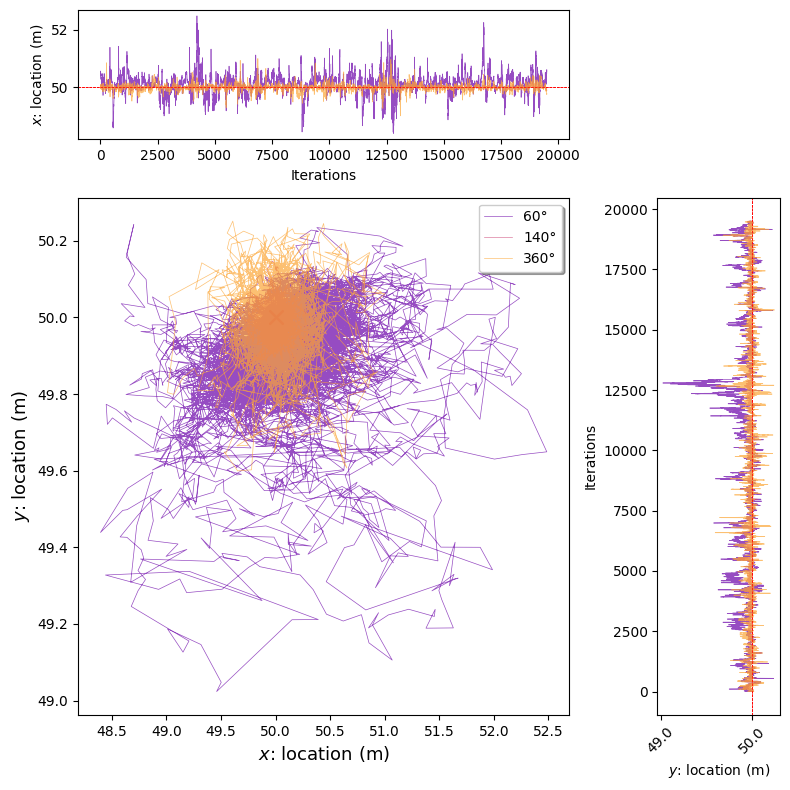

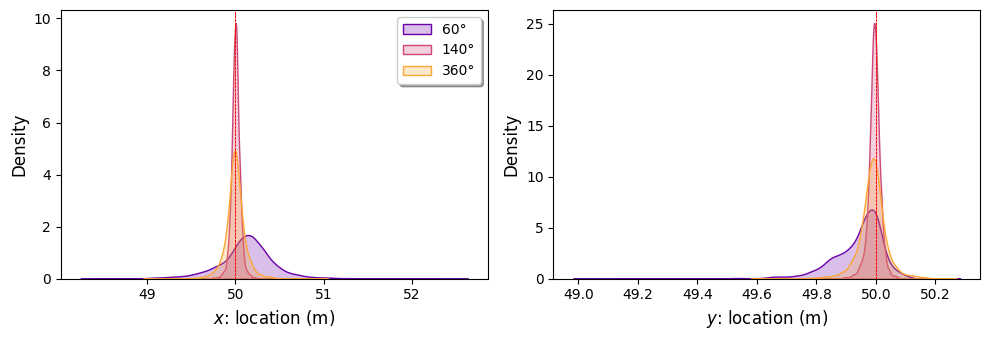

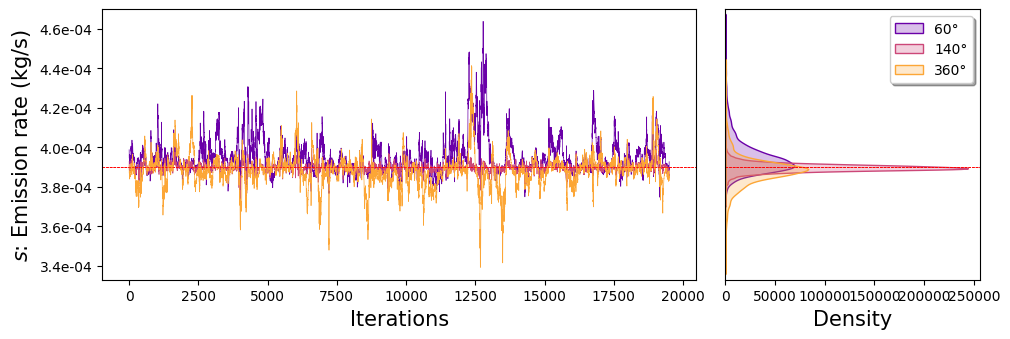

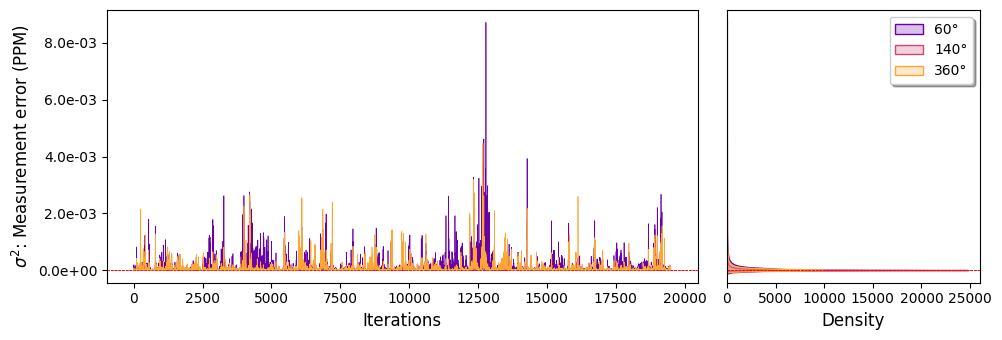

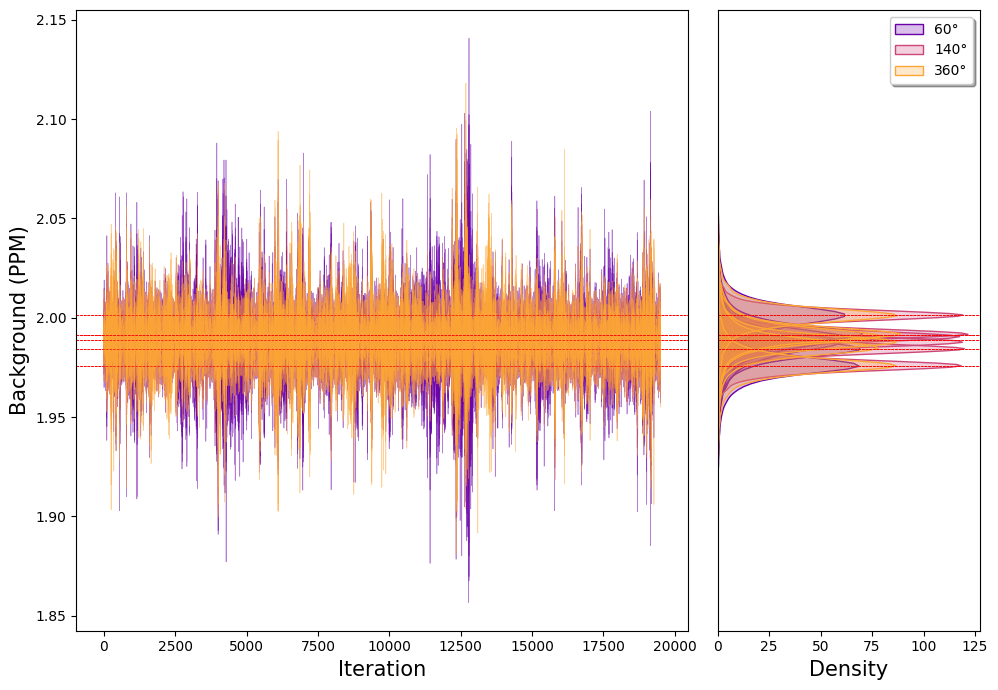

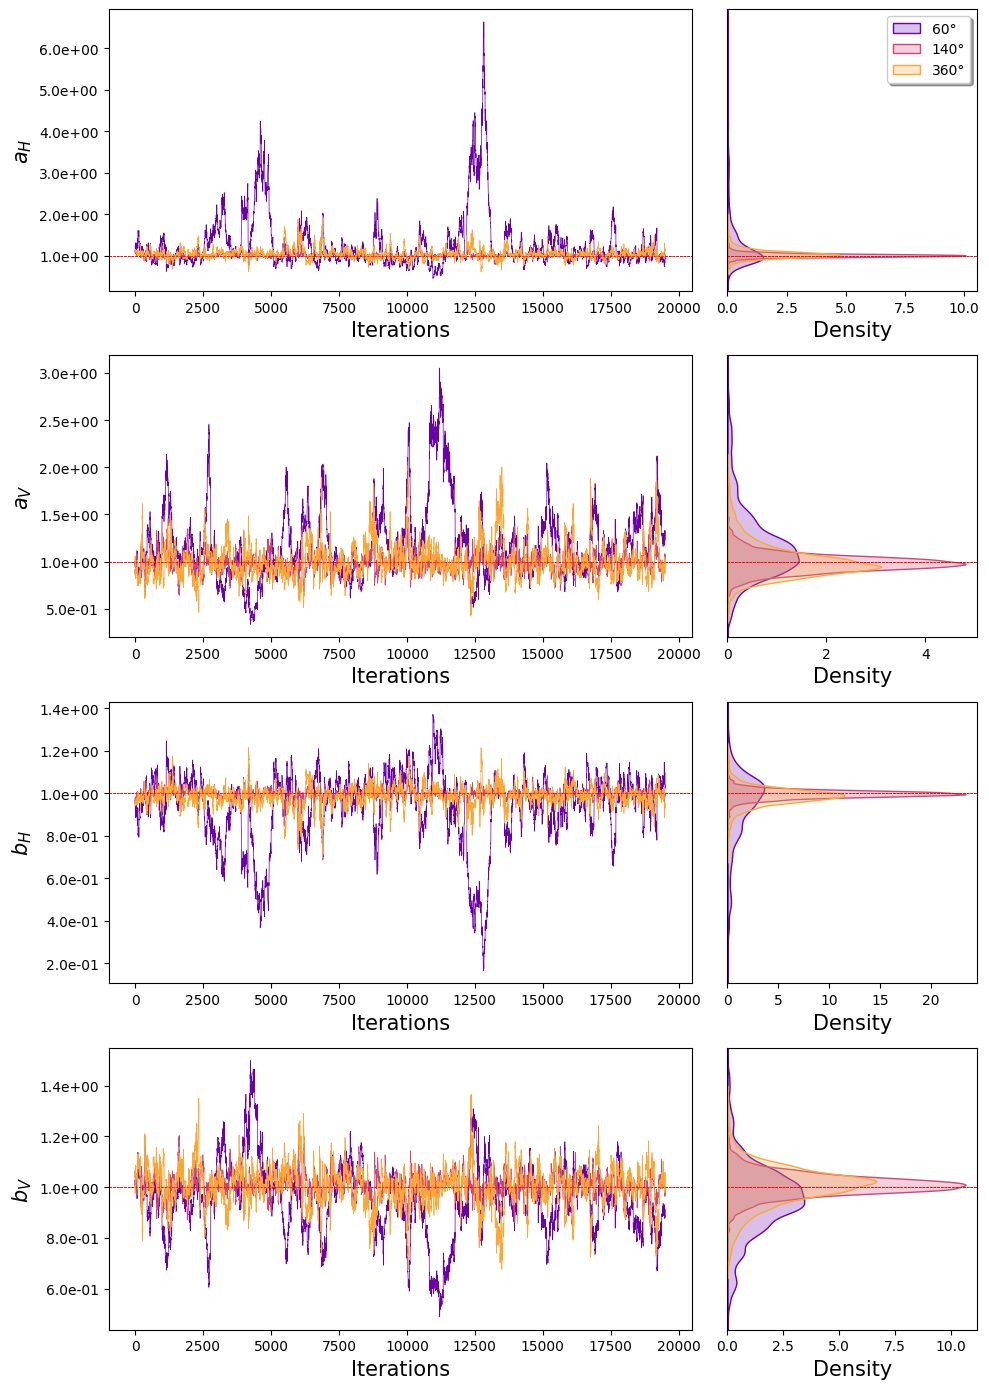

In [18]:
with open('../../Data/MCMC_chains/Simulation_study/Varying parameters/Varying wind direction coverage/60_degrees.pkl', 'rb') as f:
    sixty_degrees = pickle.load(f)

with open('../../Data/MCMC_chains/Simulation_study/Varying parameters/Varying wind direction coverage/360_degrees.pkl', 'rb') as f:
    three_sixty_degrees = pickle.load(f)

varying_wind_direction_coverage = {
    '60°': sixty_degrees,
    '140°': level_M,
    '360°': three_sixty_degrees,
}

plot_source_location_estimates(500, True, varying_wind_direction_coverage, dark=False, save=False)
plot_source_location_densities(500, True, varying_wind_direction_coverage, dark=False, save=False)
plot_source_emission_rate(500, True, varying_wind_direction_coverage, dark=False, save=False)
plot_sensor_measurement_error_variance(500, varying_wind_direction_coverage, dark=False, save=False)
plot_background(500, varying_wind_direction_coverage, dark=False, save=False)
plot_diffusion_parameters(500, True, varying_wind_direction_coverage, dark=False, save=False)

In-depth wind direction coverage

<div class="alert alert-block alert-info">
<b>DATA:</b> Need to replace data file paths with your own local path. The files are all located in the folder:<br>
Paper 1: Code/Data/MCMC_chains/Simulation_study/In-depth simulations/Wind direction coverage/...
</div>

In [19]:
with open('../../Data/MCMC_chains/Simulation_study/In-depth simulations/Wind direction coverage/five_degrees.pkl', 'rb') as f:
    five = pickle.load(f)
with open('../../Data/MCMC_chains/Simulation_study/In-depth simulations/Wind direction coverage/ten_degrees.pkl', 'rb') as f:
    ten = pickle.load(f)
with open('../../Data/MCMC_chains/Simulation_study/In-depth simulations/Wind direction coverage/twenty_degrees.pkl', 'rb') as f:
    twenty = pickle.load(f)
with open('../../Data/MCMC_chains/Simulation_study/In-depth simulations/Wind direction coverage/fourty_degrees.pkl', 'rb') as f:
    fourty = pickle.load(f)
with open('../../Data/MCMC_chains/Simulation_study/In-depth simulations/Wind direction coverage/seventy_degrees.pkl', 'rb') as f:
    seventy = pickle.load(f)
with open('../../Data/MCMC_chains/Simulation_study/In-depth simulations/Wind direction coverage/hundred_degrees.pkl', 'rb') as f:
    hundred = pickle.load(f)
with open('../../Data/MCMC_chains/Simulation_study/In-depth simulations/Wind direction coverage/one_sixty_degrees.pkl', 'rb') as f:
    one_thirty = pickle.load(f)
with open('../../Data/MCMC_chains/Simulation_study/In-depth simulations/Wind direction coverage/one_sixty_degrees.pkl', 'rb') as f:
    one_sixty = pickle.load(f)
with open('../../Data/MCMC_chains/Simulation_study/In-depth simulations/Wind direction coverage/one_ninety_degrees.pkl', 'rb') as f:
    one_ninety = pickle.load(f)
with open('../../Data/MCMC_chains/Simulation_study/In-depth simulations/Wind direction coverage/three_sixty_degrees.pkl', 'rb') as f:
    three_sixty = pickle.load(f)

in_depth_varying_wind_direction_coverage = {
    '5 degrees': five,
    '10 degrees': ten,
    '20 degrees': twenty,
    '40 degrees': fourty,
    '70 degrees': seventy,
    '100 degrees': hundred,
    '130 degrees': one_thirty,
    '160 degrees': one_sixty,
    '190 degrees': one_ninety,
    '360 degrees': three_sixty,
}

C:\Users\teresa-klatzer\AppData\Local\Temp\ipykernel_16844\3936232438.py:2: DeprecationWarning: Pickled array contains an aval with a named_shape attribute. This is deprecated and the code path supporting such avals will be removed. Please re-pickle the array.
  five = pickle.load(f)
C:\Users\teresa-klatzer\AppData\Local\Temp\ipykernel_16844\3936232438.py:4: DeprecationWarning: Pickled array contains an aval with a named_shape attribute. This is deprecated and the code path supporting such avals will be removed. Please re-pickle the array.
  ten = pickle.load(f)
C:\Users\teresa-klatzer\AppData\Local\Temp\ipykernel_16844\3936232438.py:6: DeprecationWarning: Pickled array contains an aval with a named_shape attribute. This is deprecated and the code path supporting such avals will be removed. Please re-pickle the array.
  twenty = pickle.load(f)
C:\Users\teresa-klatzer\AppData\Local\Temp\ipykernel_16844\3936232438.py:8: DeprecationWarning: Pickled array contains an aval with a named_shap

In [20]:

def plot_boxplots_diffusion_parameters(data, burn_in = 1000, save = False):
    # Create a figure with 4 subplots sharing a single common x-axis
    fig, axs = plt.subplots(2, 2, figsize=(20, 13), sharex=True)

    # List of keys to plot
    keys_to_plot = ['a_H', 'b_H', 'a_V', 'b_V']

    # Get the rainbow colormap
    colors = cm.rainbow(np.linspace(0, 1, len(data.keys())))

    # For each subplot
    for i, ax in enumerate(axs.flatten()):
        # Extract the values for the current key from each dictionary and store them in a list
        values = [sub_dict[keys_to_plot[i]][burn_in:] for sub_dict in data.values()]

        # Create the boxplot without outliers
        boxplot = ax.boxplot(values, labels=data.keys(), vert=True, patch_artist=True, showfliers=False)

        # Color each box with a color from the rainbow colormap
        for patch, color in zip(boxplot['boxes'], colors):
            patch.set_facecolor(color)

        # Set the label of the y-axis
        ax.set_ylabel(keys_to_plot[i], fontsize=16)

        # Add a horizontal dashed line at 1.0
        ax.axhline(y=1.0, color='r', linestyle='--')

    # Set a common x-axis title
    # fig.suptitle("Wind Sigmas VS Wind direction coverage (degree)", fontsize=16)

    # Create a legend with the colors and labels
    patches = [mpatches.Patch(color=color, label=label) for color, label in zip(colors, data.keys())]
    fig.legend(handles=patches, bbox_to_anchor=(0.04, 0.95), loc='upper left', fontsize=12)

    # Adjust the layout
    plt.tight_layout()

    if save:
        plt.savefig('wind_sigmas_boxplots.pdf', dpi=300, bbox_inches='tight', transparent=False)
    # Show the plot
    plt.show()


def plot_boxplots_source(data, burn_in = 1000, save=False):
    # Create a figure with 4 subplots sharing a single common x-axis
    fig, axs = plt.subplots(2, 2, figsize=(20, 13), sharex=True)

    # List of keys to plot
    keys_to_plot = ['s', 'source_x', 'source_y', 'sigma_squared']
    horizontal_values = [0.00039, 50.0, 50.0, 1e-6]

    # Get the rainbow colormap
    colors = cm.rainbow(np.linspace(0, 1, len(data.keys())))

    # For each subplot
    for i, ax in enumerate(axs.flatten()):
        # Extract the values for the current key from each dictionary and store them in a list
        values = [sub_dict[keys_to_plot[i]].flatten()[burn_in:] for sub_dict in data.values()]

        # Create the boxplot without outliers
        boxplot = ax.boxplot(values, labels=data.keys(), vert=True, patch_artist=True, showfliers=False)

        # Color each box with a color from the rainbow colormap
        for patch, color in zip(boxplot['boxes'], colors):
            patch.set_facecolor(color)

        # Set the label of the y-axis
        ax.set_ylabel(keys_to_plot[i], fontsize=16)

        # Add a horizontal dashed line at 1.0
        ax.axhline(y=horizontal_values[i], color='r', linestyle='--')

    # Set a common x-axis title
    # fig.suptitle("Wind Sigmas VS Wind direction coverage (degree)", fontsize=16)

    # Create a legend with the colors and labels
    patches = [mpatches.Patch(color=color, label=label) for color, label in zip(colors, data.keys())]
    fig.legend(handles=patches, bbox_to_anchor=(0.05, 0.96), loc='upper left', fontsize=12)

    # Adjust the layout
    plt.tight_layout()

    if save:
        plt.savefig('source_boxplots.pdf', dpi=300, bbox_inches='tight', transparent=False)
    # Show the plot
    plt.show()

C:\Users\teresa-klatzer\AppData\Local\Temp\ipykernel_16844\3733537598.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = ax.boxplot(values, labels=data.keys(), vert=True, patch_artist=True, showfliers=False)


C:\Users\teresa-klatzer\AppData\Local\Temp\ipykernel_16844\3733537598.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = ax.boxplot(values, labels=data.keys(), vert=True, patch_artist=True, showfliers=False)
C:\Users\teresa-klatzer\AppData\Local\Temp\ipykernel_16844\3733537598.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = ax.boxplot(values, labels=data.keys(), vert=True, patch_artist=True, showfliers=False)
C:\Users\teresa-klatzer\AppData\Local\Temp\ipykernel_16844\3733537598.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = ax.boxplot(values, labels=data.keys(), vert=True, pa

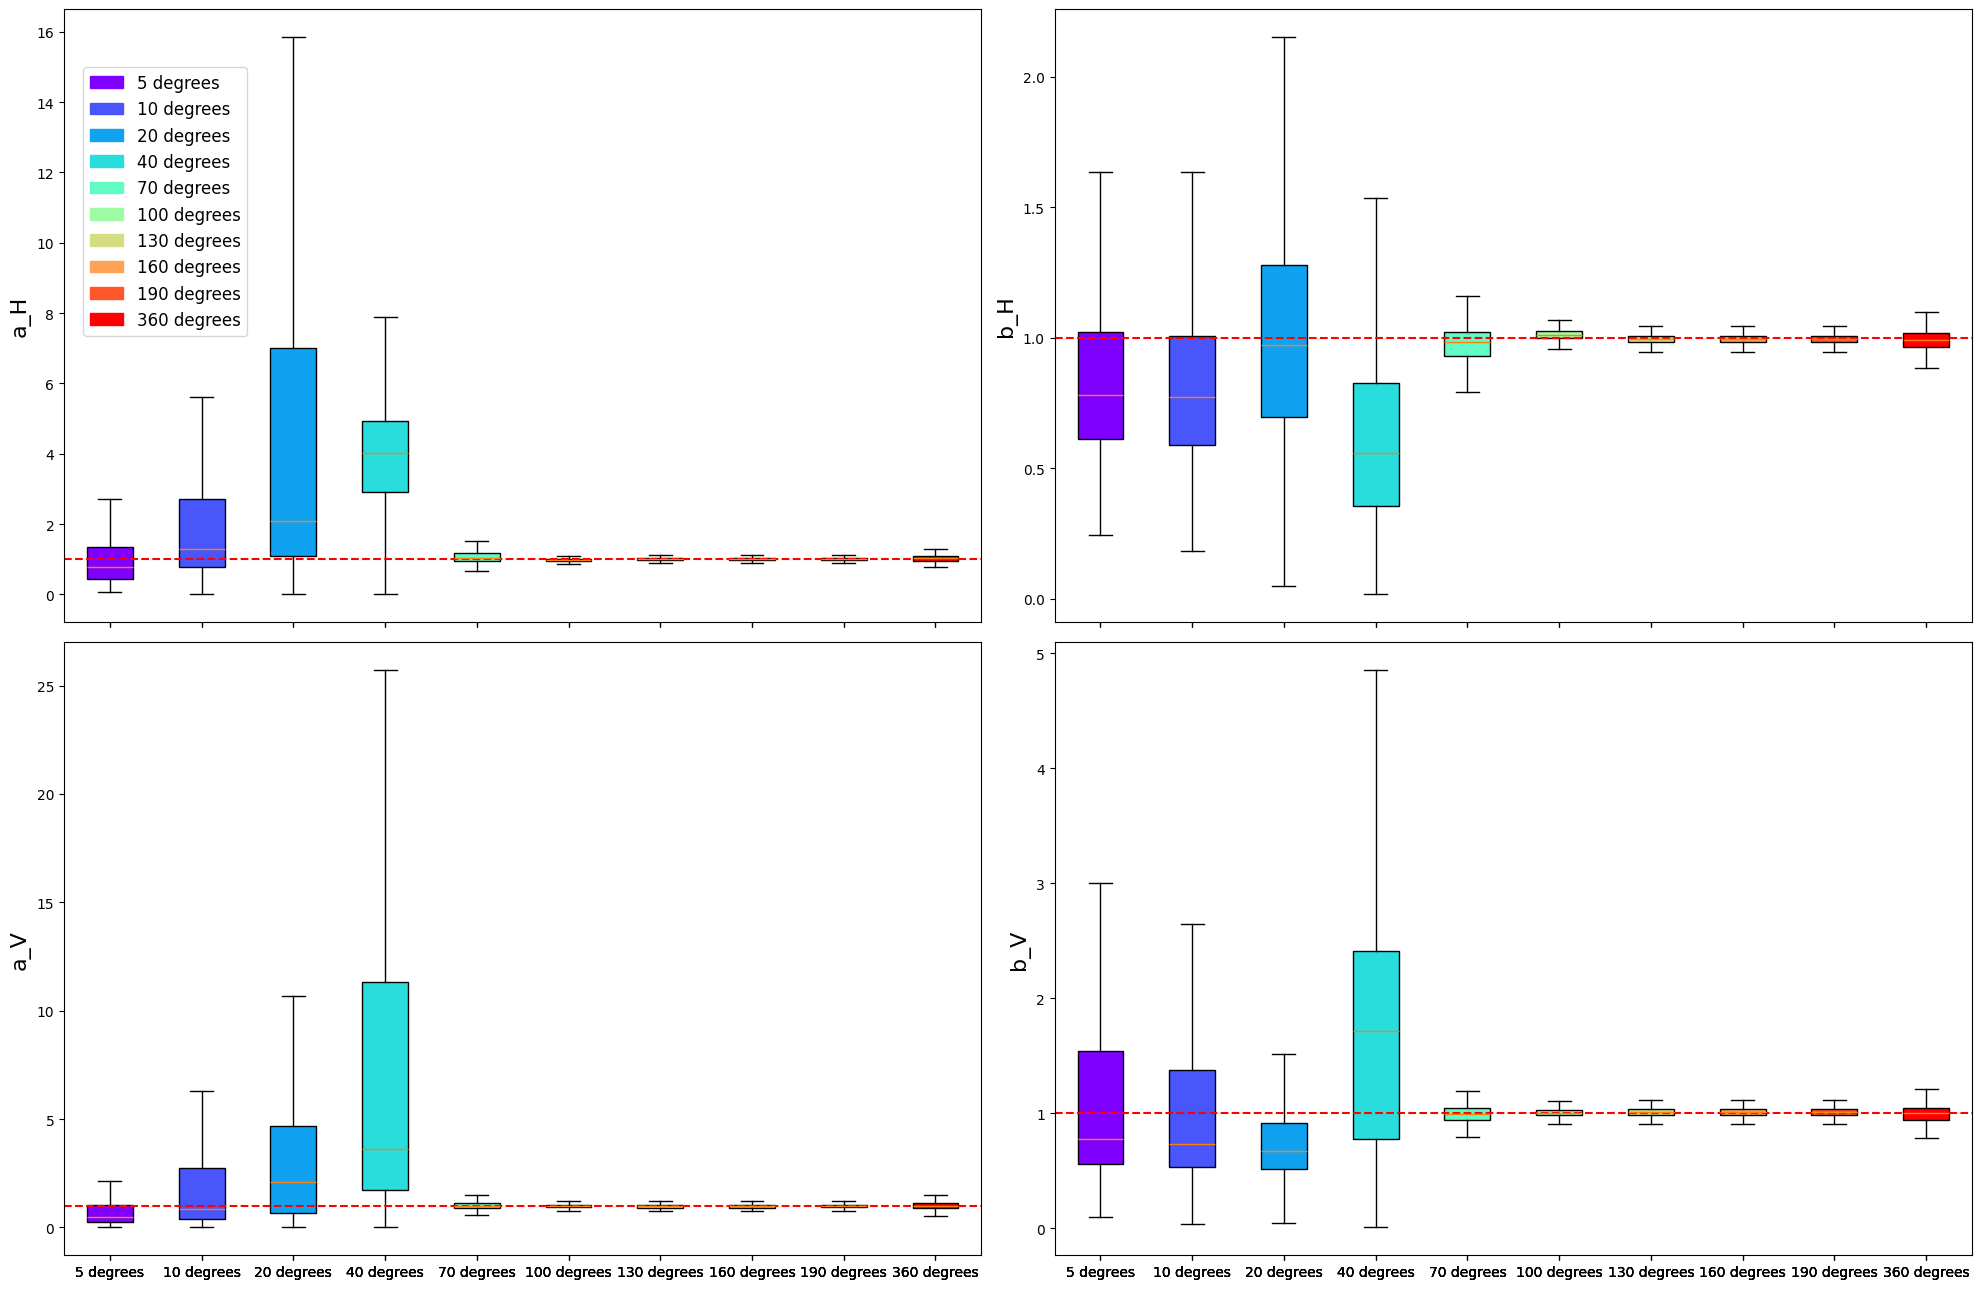

C:\Users\teresa-klatzer\AppData\Local\Temp\ipykernel_16844\3733537598.py:62: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = ax.boxplot(values, labels=data.keys(), vert=True, patch_artist=True, showfliers=False)
C:\Users\teresa-klatzer\AppData\Local\Temp\ipykernel_16844\3733537598.py:62: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = ax.boxplot(values, labels=data.keys(), vert=True, patch_artist=True, showfliers=False)
C:\Users\teresa-klatzer\AppData\Local\Temp\ipykernel_16844\3733537598.py:62: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = ax.boxplot(values, labels=data.keys(), vert=True, pa

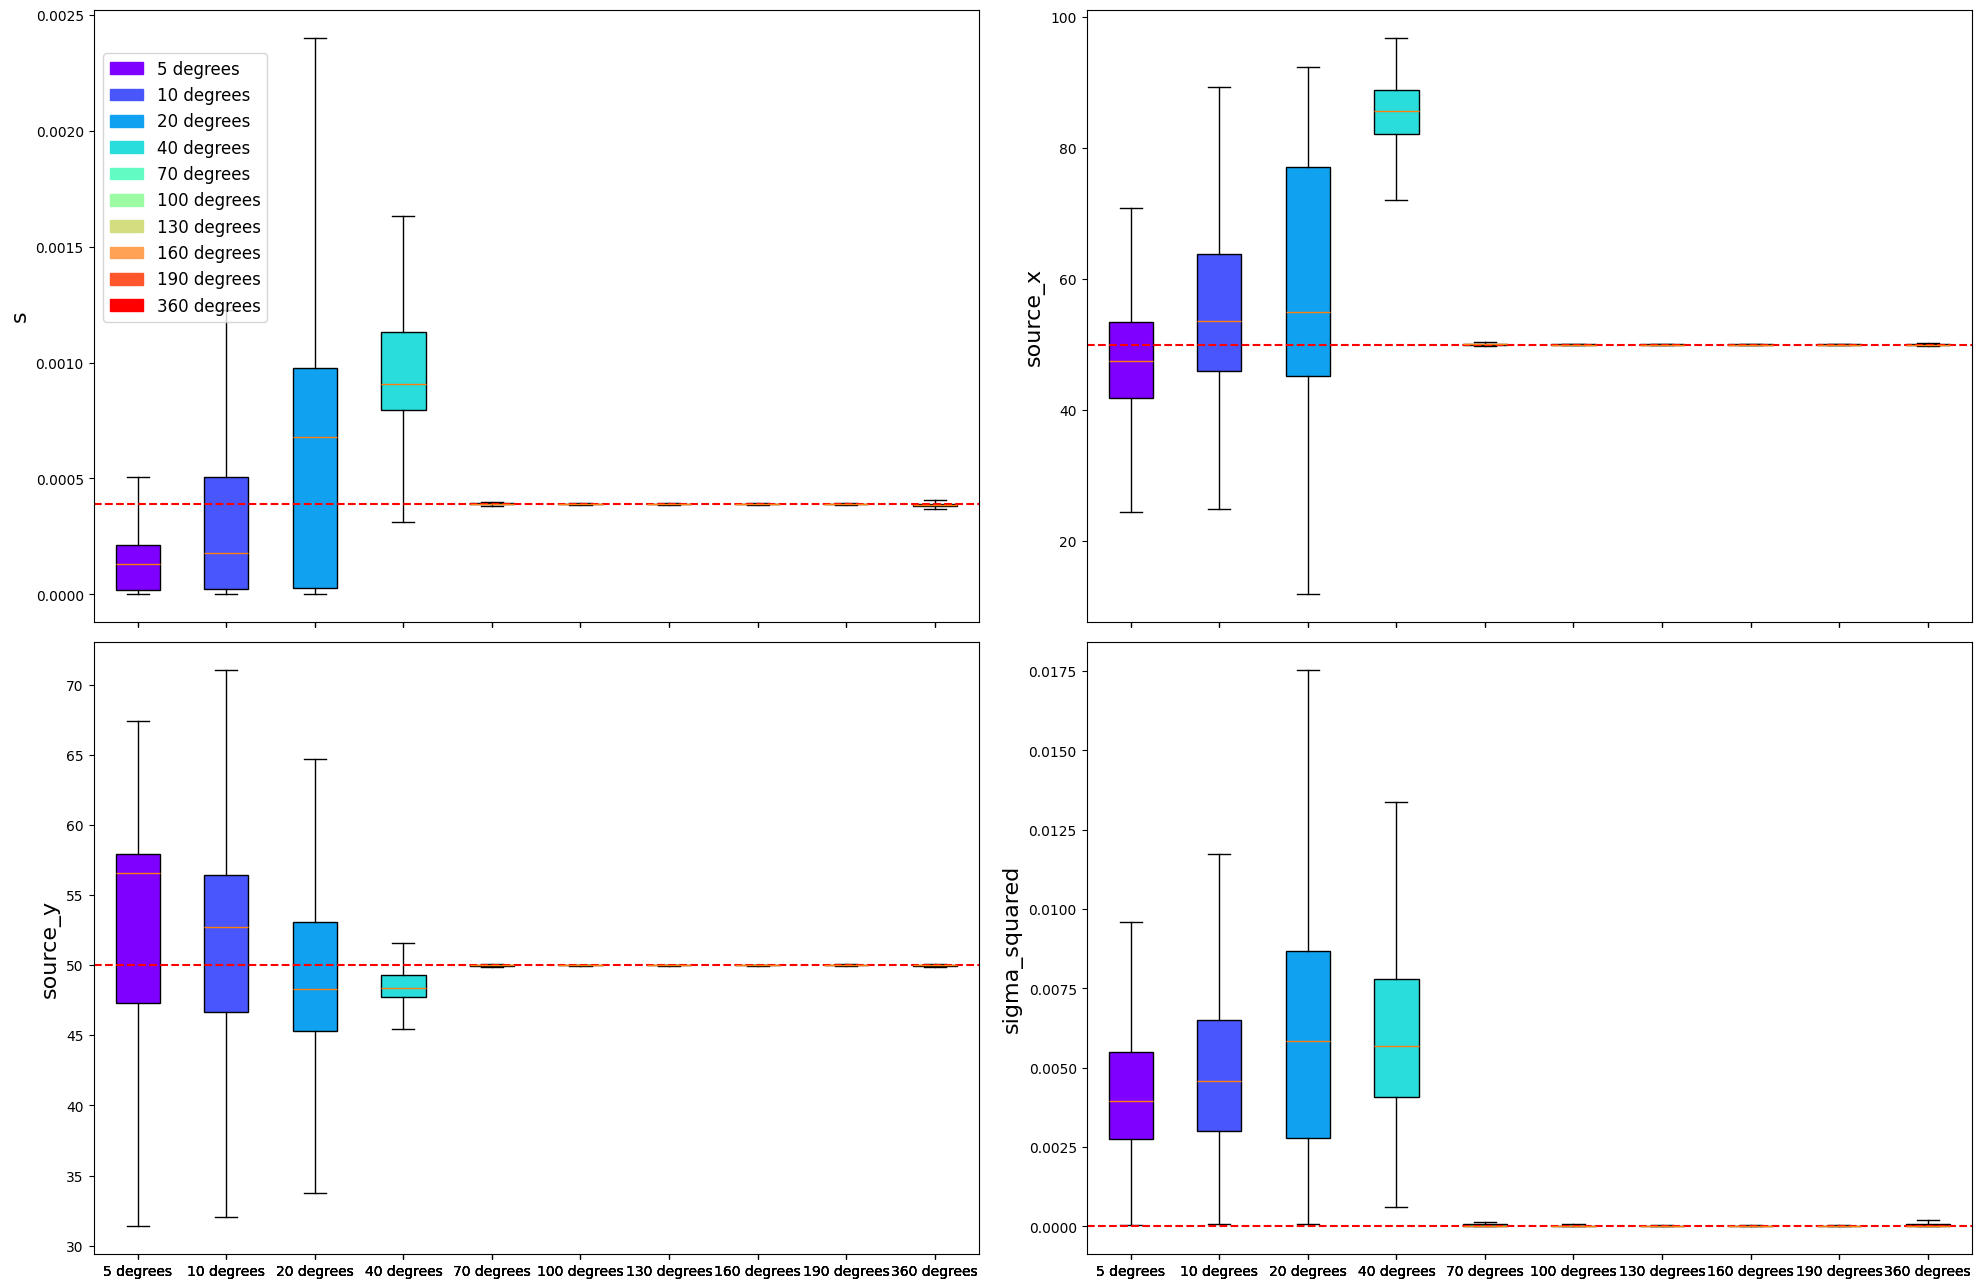

In [21]:
plot_boxplots_diffusion_parameters(in_depth_varying_wind_direction_coverage)
plot_boxplots_source(in_depth_varying_wind_direction_coverage)

<Figure size 1000x1000 with 0 Axes>

c:\Users\teresa-klatzer\anaconda3\envs\plumes\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


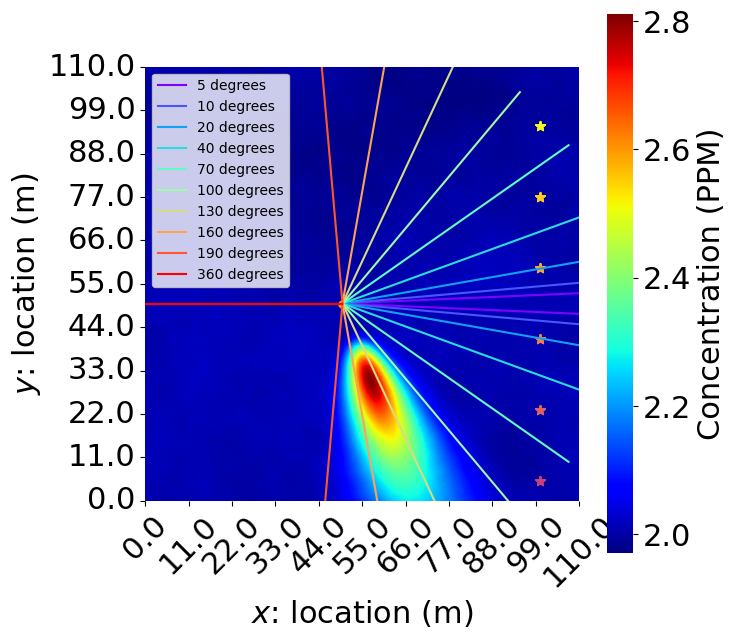

In [22]:
sensors.atmospheric_methane_and_sensors(False, format='png', angles = True)

## 1.2 Varying the Dispersion Parameter Values

<div class="alert alert-block alert-info">
<b>DATA:</b> Need to replace data file paths with your own local path. The files are all located in the folder:<br>
Paper 1: Code/Data/MCMC_chains/Simulation_study/Varying parameters/Varying dispersion parameters/...
</div>

C:\Users\teresa-klatzer\AppData\Local\Temp\ipykernel_16844\4215303692.py:2: DeprecationWarning: Pickled array contains an aval with a named_shape attribute. This is deprecated and the code path supporting such avals will be removed. Please re-pickle the array.
  diffusion_parameters_1 = pickle.load(f)
C:\Users\teresa-klatzer\AppData\Local\Temp\ipykernel_16844\4215303692.py:4: DeprecationWarning: Pickled array contains an aval with a named_shape attribute. This is deprecated and the code path supporting such avals will be removed. Please re-pickle the array.
  diffusion_parameters_2 = pickle.load(f)


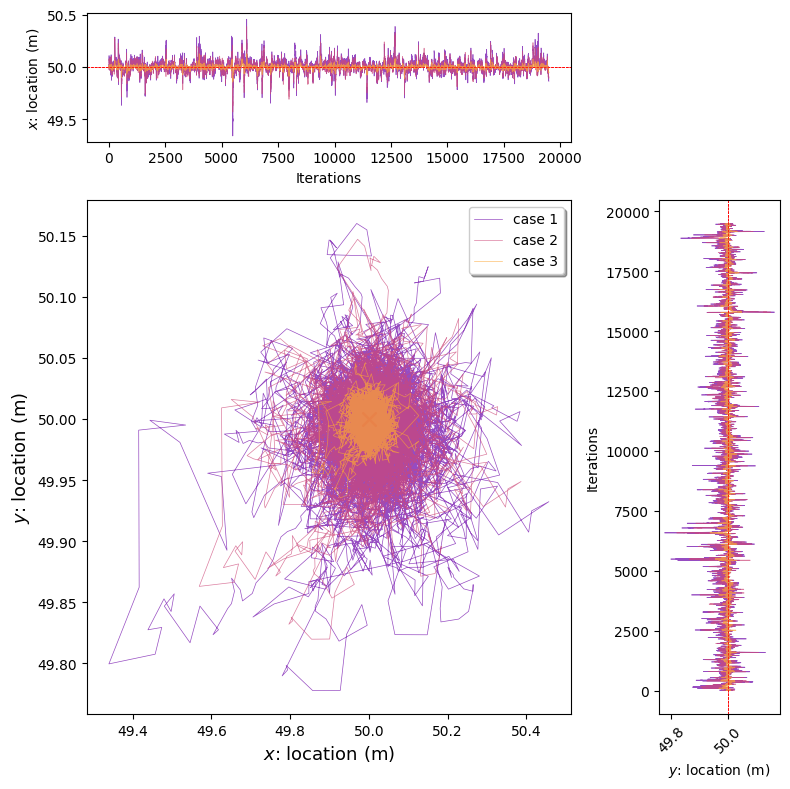

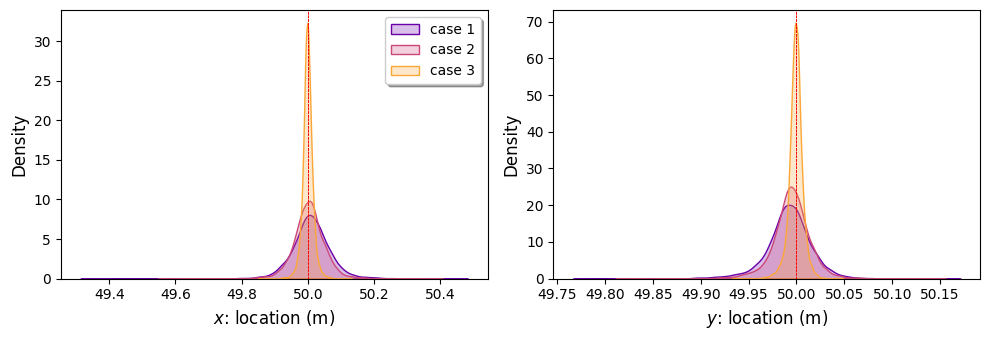

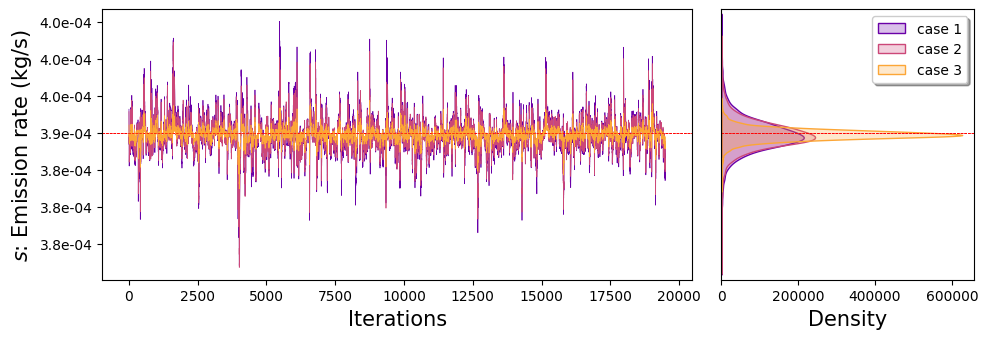

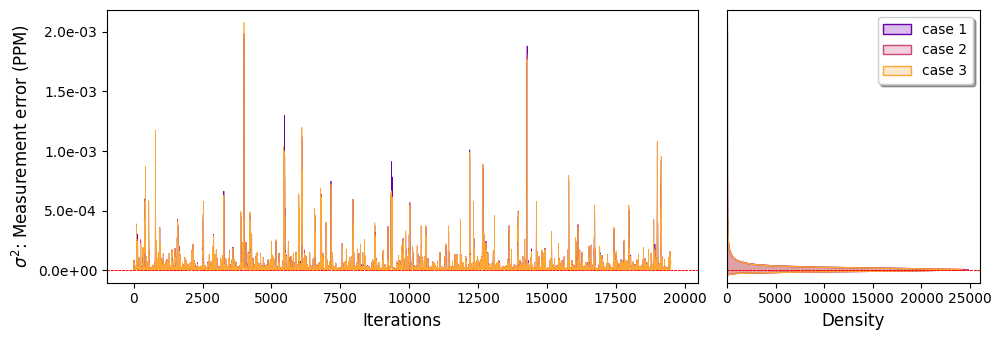

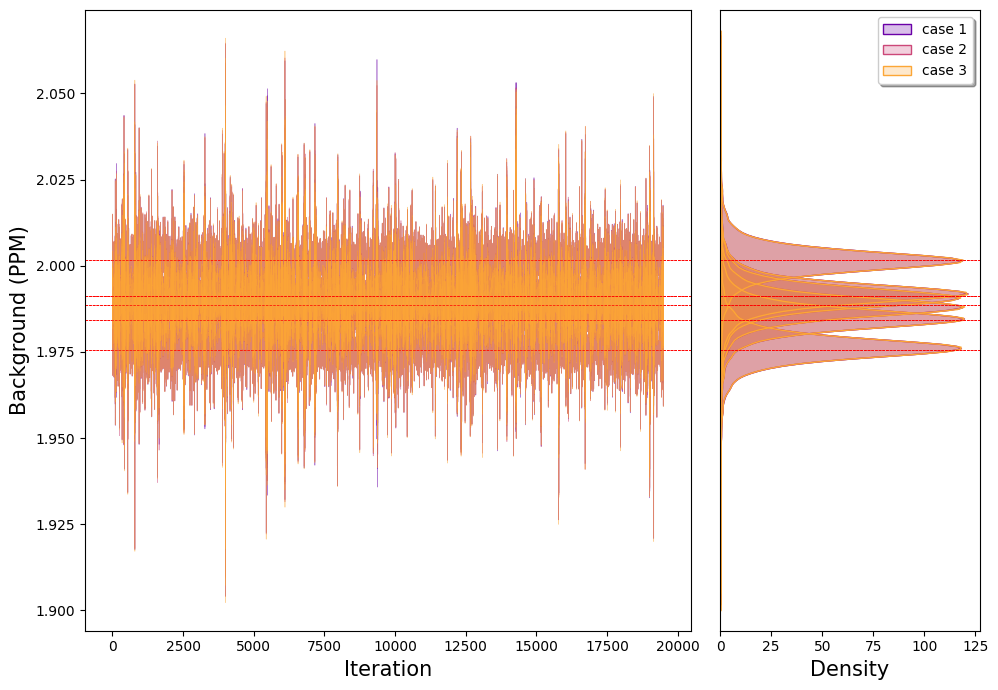

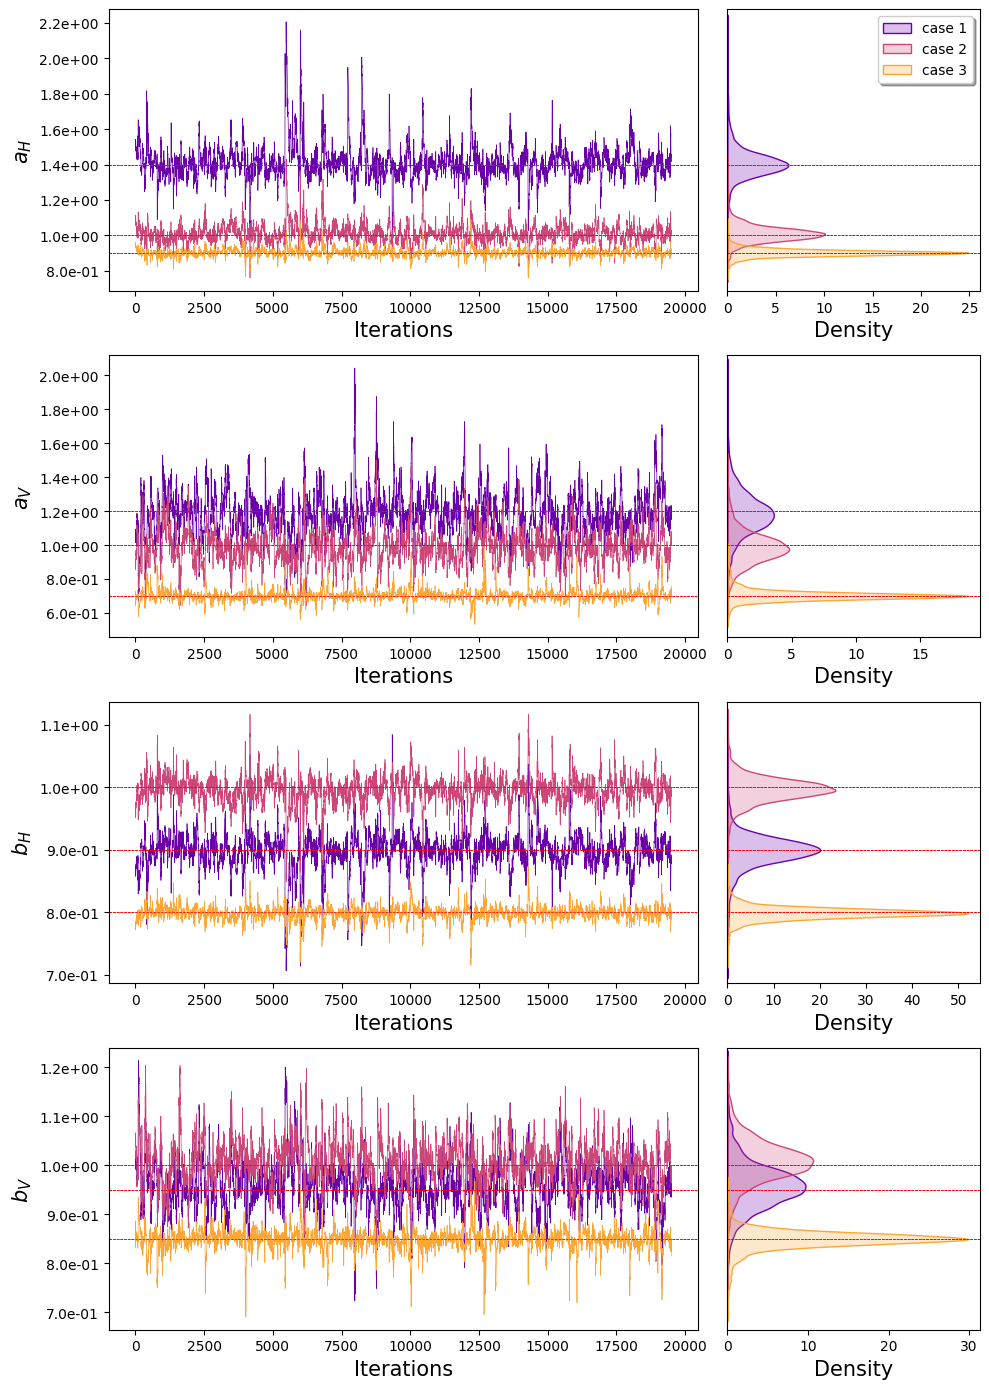

In [23]:
with open('../../Data/MCMC_chains/Simulation_study/Varying parameters/Varying dispersion parameters/case_1.pkl', 'rb') as f:
    diffusion_parameters_1 = pickle.load(f)
with open('../../Data/MCMC_chains/Simulation_study/Varying parameters/Varying dispersion parameters/case_2.pkl', 'rb') as f:
    diffusion_parameters_2 = pickle.load(f)

varying_diffusion_parameters = {
    'case 1': diffusion_parameters_1,
    'case 2': level_M,
    'case 3': diffusion_parameters_2,
}

plot_source_location_estimates(500, True, varying_diffusion_parameters, dark=False, save=False)
plot_source_location_densities(500, True, varying_diffusion_parameters, dark=False, save=False)
plot_source_emission_rate(500, True, varying_diffusion_parameters, dark=False, save=False)
plot_sensor_measurement_error_variance(500, varying_diffusion_parameters, dark=False, save=False)
plot_background(500, varying_diffusion_parameters, dark=False, save=False)
plot_diffusion_parameters(500, False, varying_diffusion_parameters, dark=False, save=False)

## 1.3 Varying the Source Emission Rate

<div class="alert alert-block alert-info">
<b>DATA:</b> Need to replace data file paths with your own local path. The files are all located in the folder:<br>
Paper 1: Code/Data/MCMC_chains/Simulation_study/Varying parameters/Varying source strength/...
</div>

C:\Users\teresa-klatzer\AppData\Local\Temp\ipykernel_16844\3991223905.py:2: DeprecationWarning: Pickled array contains an aval with a named_shape attribute. This is deprecated and the code path supporting such avals will be removed. Please re-pickle the array.
  low_emission_rate = pickle.load(f)
C:\Users\teresa-klatzer\AppData\Local\Temp\ipykernel_16844\3991223905.py:4: DeprecationWarning: Pickled array contains an aval with a named_shape attribute. This is deprecated and the code path supporting such avals will be removed. Please re-pickle the array.
  high_emission_rate = pickle.load(f)


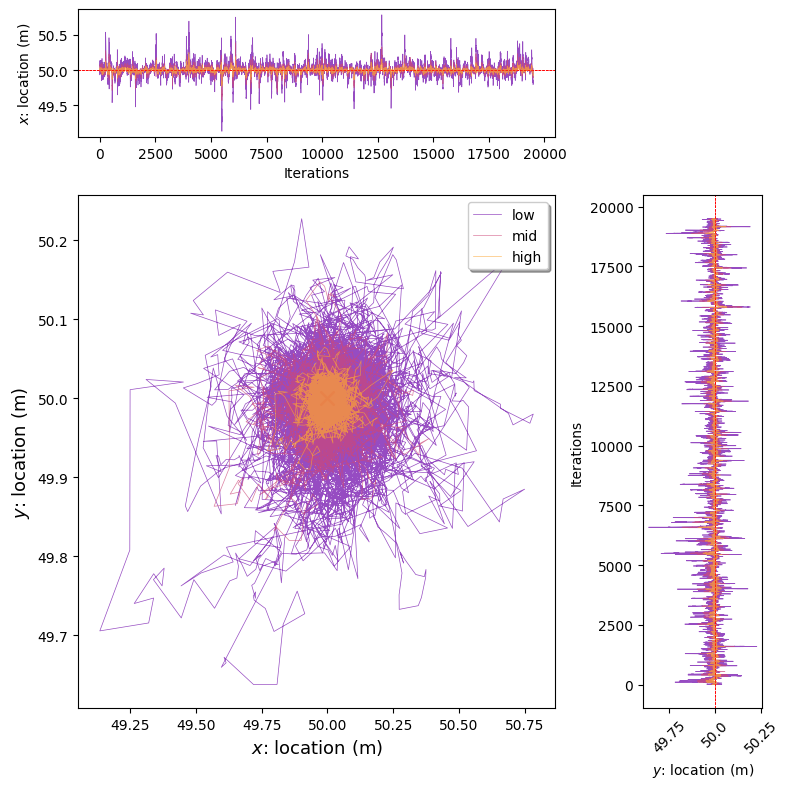

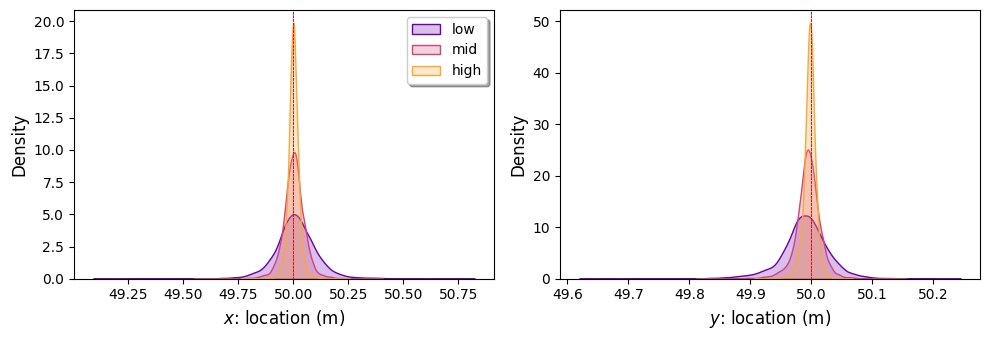

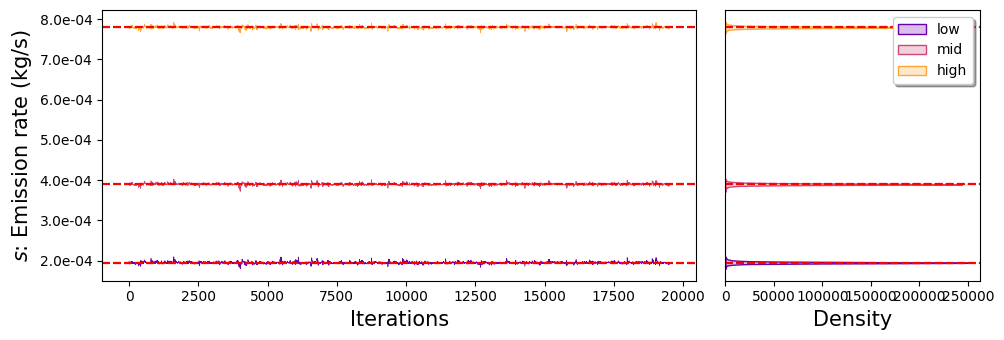

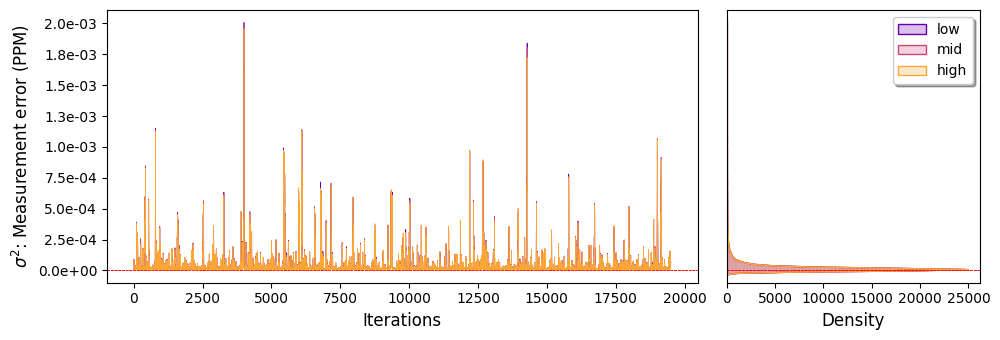

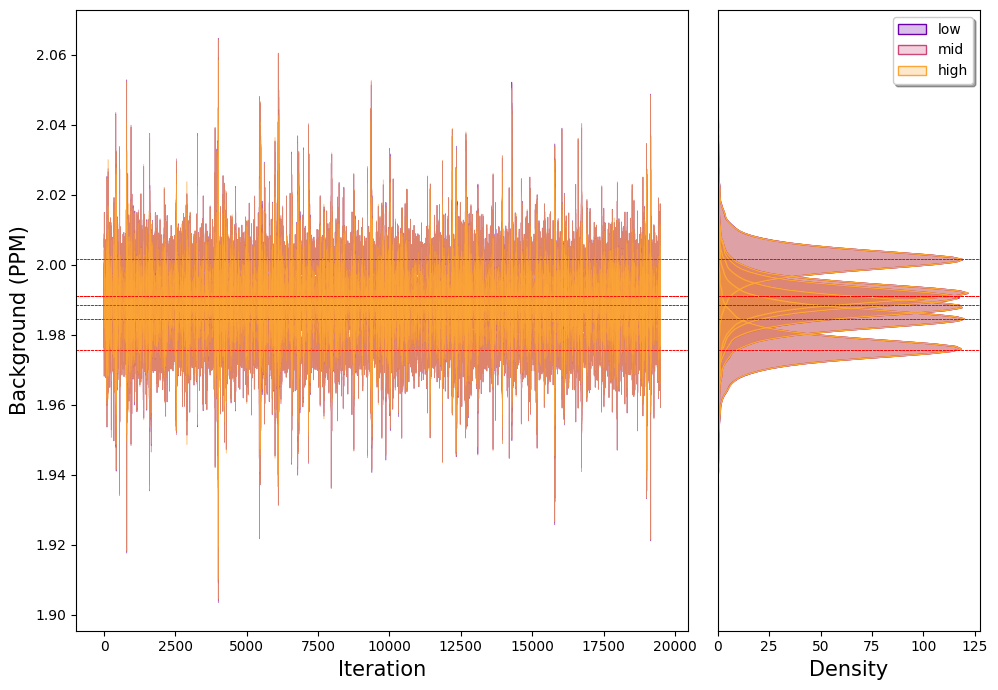

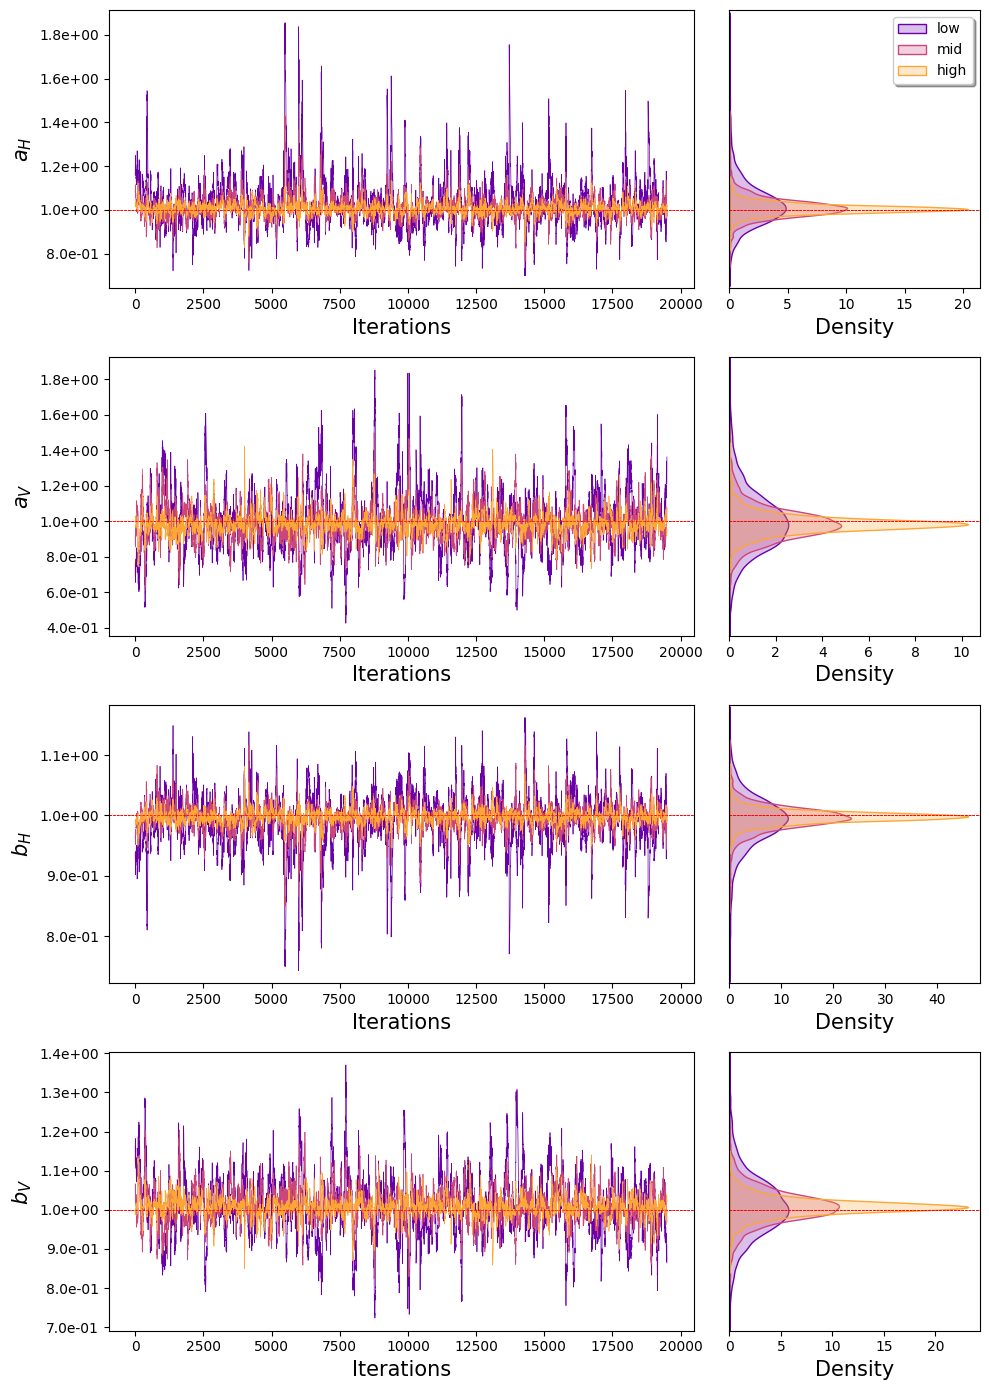

In [24]:
with open('../../Data/MCMC_chains/Simulation_study/Varying parameters/Varying source strength/low_emission_rate.pkl', 'rb') as f:
    low_emission_rate = pickle.load(f)
with open('../../Data/MCMC_chains/Simulation_study/Varying parameters/Varying source strength/high_emission_rate.pkl', 'rb') as f:
    high_emission_rate = pickle.load(f)

varying_emission_rate = {
    'low': low_emission_rate,
    'mid': level_M,
    'high': high_emission_rate
}
plot_source_location_estimates(500, True, varying_emission_rate, dark=False, save=False)
plot_source_location_densities(500, True, varying_emission_rate, dark=False, save=False)
plot_source_emission_rate(500, False, varying_emission_rate, dark=False, save=False)
plot_sensor_measurement_error_variance(500, varying_emission_rate, dark=False, save=False)
plot_background(500, varying_emission_rate, dark=False, save=False)
plot_diffusion_parameters(500, True, varying_emission_rate, dark=False, save=False)

## 1.4 Varying the Distance Between Source and Sensors

<div class="alert alert-block alert-info">
<b>DATA:</b> Need to replace data file paths with your own local path. The files are all located in the folder:<br>
Paper 1: Code/Data/MCMC_chains/Simulation_study/Varying parameters/Varying source distance/...
</div>

C:\Users\teresa-klatzer\AppData\Local\Temp\ipykernel_16844\260507406.py:2: DeprecationWarning: Pickled array contains an aval with a named_shape attribute. This is deprecated and the code path supporting such avals will be removed. Please re-pickle the array.
  distance_30_meters = pickle.load(f)
C:\Users\teresa-klatzer\AppData\Local\Temp\ipykernel_16844\260507406.py:4: DeprecationWarning: Pickled array contains an aval with a named_shape attribute. This is deprecated and the code path supporting such avals will be removed. Please re-pickle the array.
  distance_70_meters = pickle.load(f)


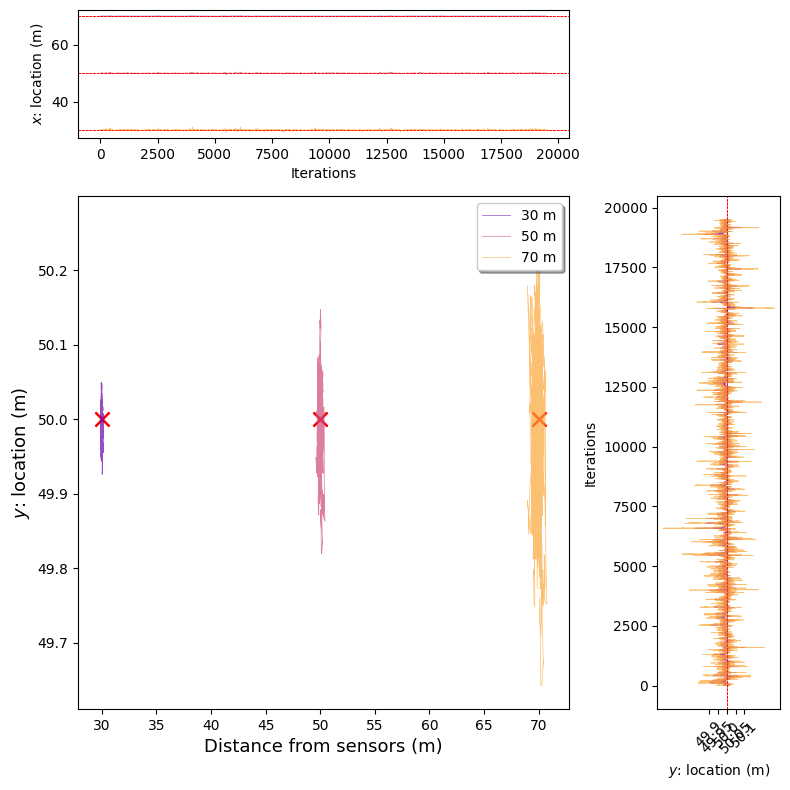

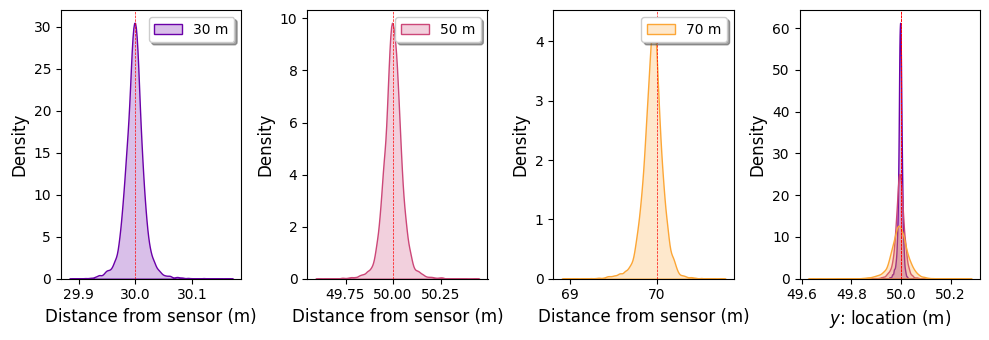

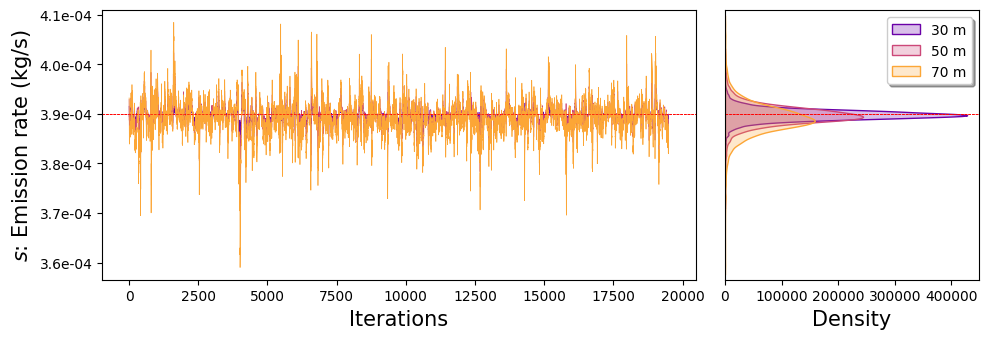

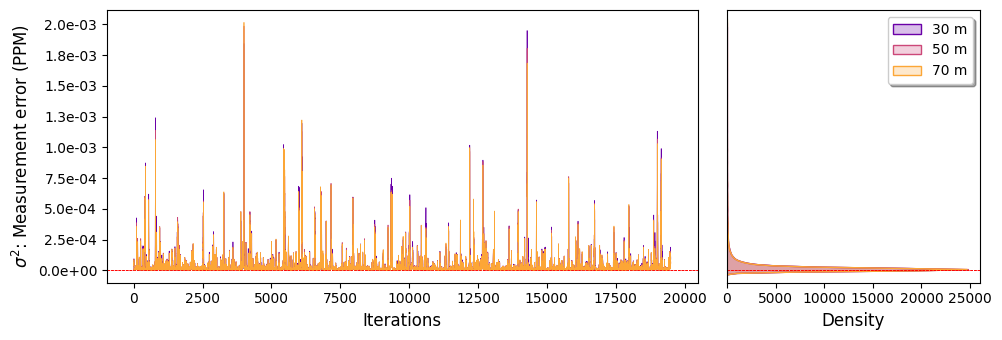

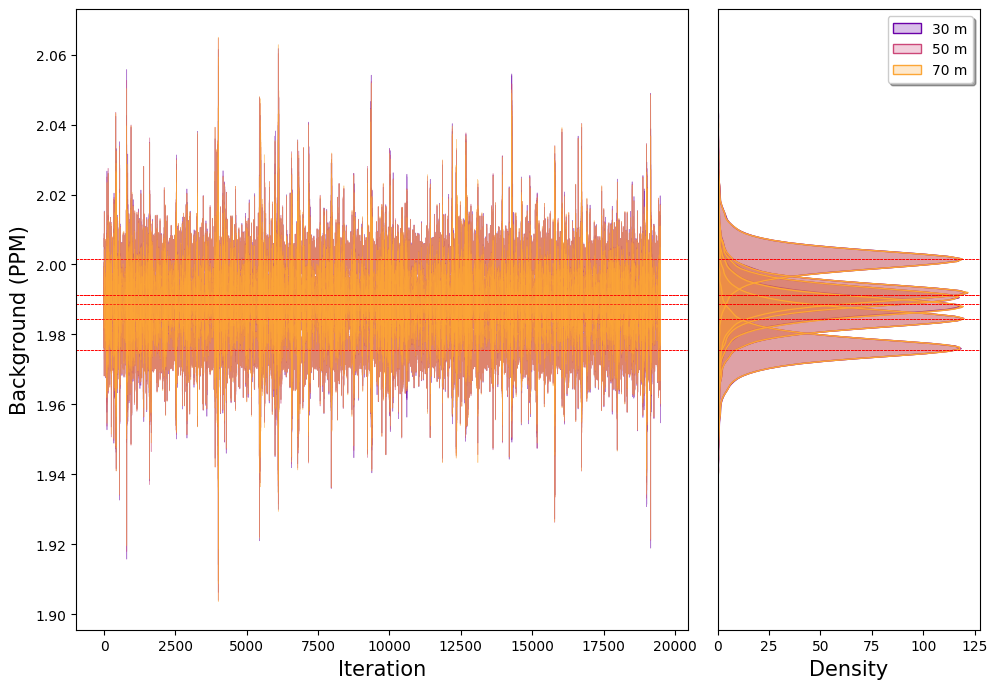

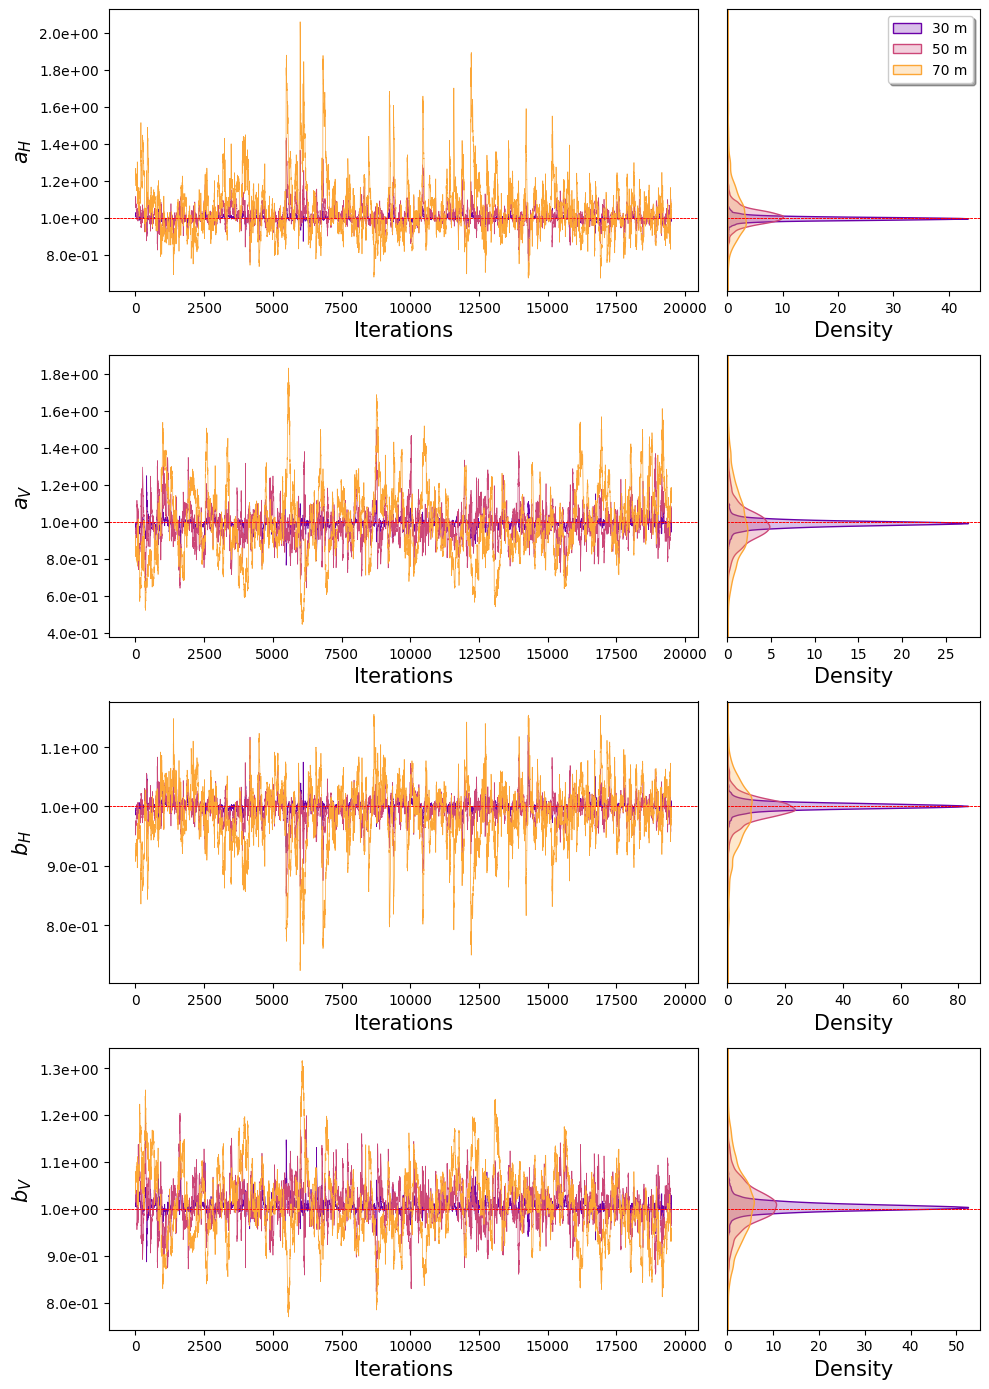

In [25]:
with open('../../Data/MCMC_chains/Simulation_study/Varying parameters/Varying source distance/distance_30_meters.pkl', 'rb') as f:
    distance_30_meters = pickle.load(f)
with open('../../Data/MCMC_chains/Simulation_study/Varying parameters/Varying source distance/distance_70_meters.pkl', 'rb') as f:
    distance_70_meters = pickle.load(f)

varying_distances = {
    '30 m': distance_30_meters,
    '50 m': level_M,
    '70 m': distance_70_meters
}

plot_source_location_estimates(500, False, varying_distances, dark=False, save=False)  
plot_source_location_densities(500, False, varying_distances, dark=False, save=False)
plot_source_emission_rate(500, True, varying_distances, dark=False, save=False)
plot_sensor_measurement_error_variance(500, varying_distances, dark=False, save=False)
plot_background(500, varying_distances, dark=False, save=False)
plot_diffusion_parameters(500, True, varying_distances, dark=False, save=False)

## 1.5 Varying the Number of Observations per Sensor

<div class="alert alert-block alert-info">
<b>DATA:</b> Need to replace data file paths with your own local path. The files are all located in the folder:<br>
Paper 1: Code/Data/MCMC_chains/Simulation_study/Varying parameters/Varying number of obs per sensor/...
</div>

C:\Users\teresa-klatzer\AppData\Local\Temp\ipykernel_16844\1809951014.py:2: DeprecationWarning: Pickled array contains an aval with a named_shape attribute. This is deprecated and the code path supporting such avals will be removed. Please re-pickle the array.
  ten_per_sensor = pickle.load(f)
C:\Users\teresa-klatzer\AppData\Local\Temp\ipykernel_16844\1809951014.py:4: DeprecationWarning: Pickled array contains an aval with a named_shape attribute. This is deprecated and the code path supporting such avals will be removed. Please re-pickle the array.
  thousand_per_sensor = pickle.load(f)


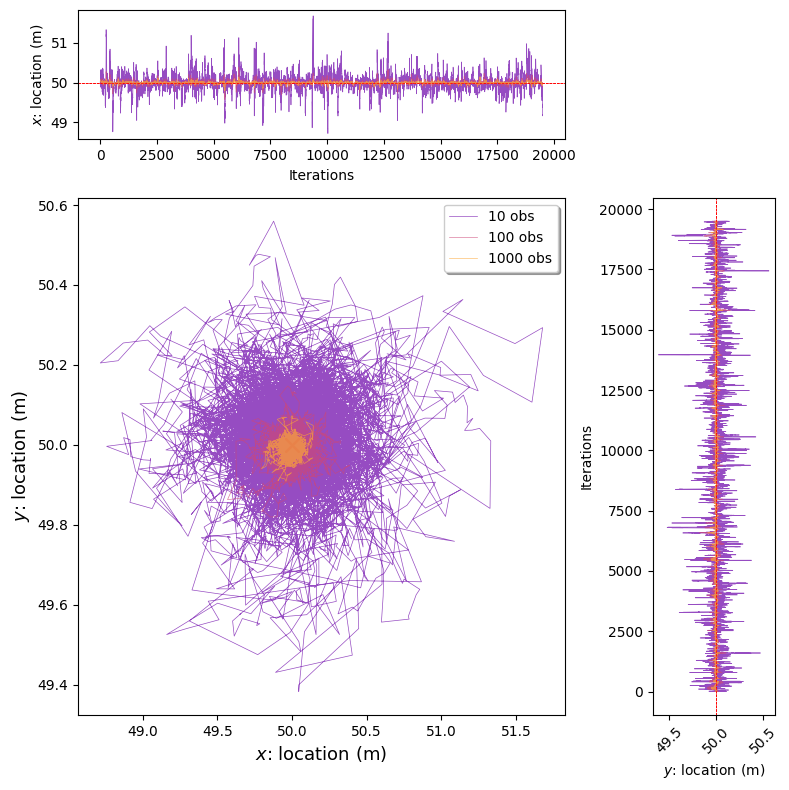

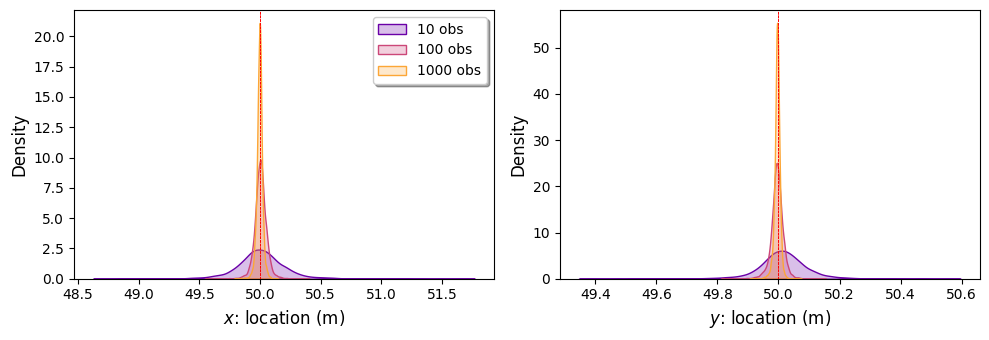

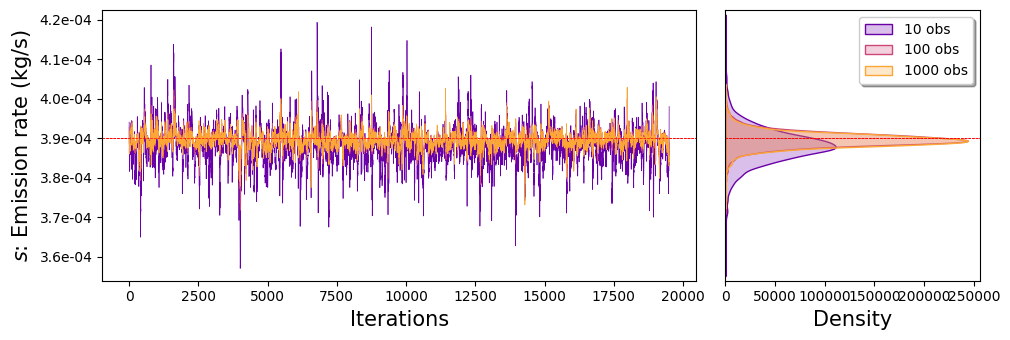

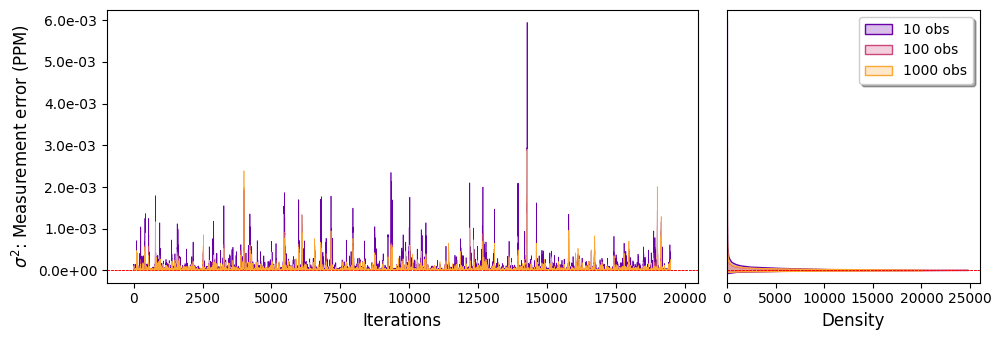

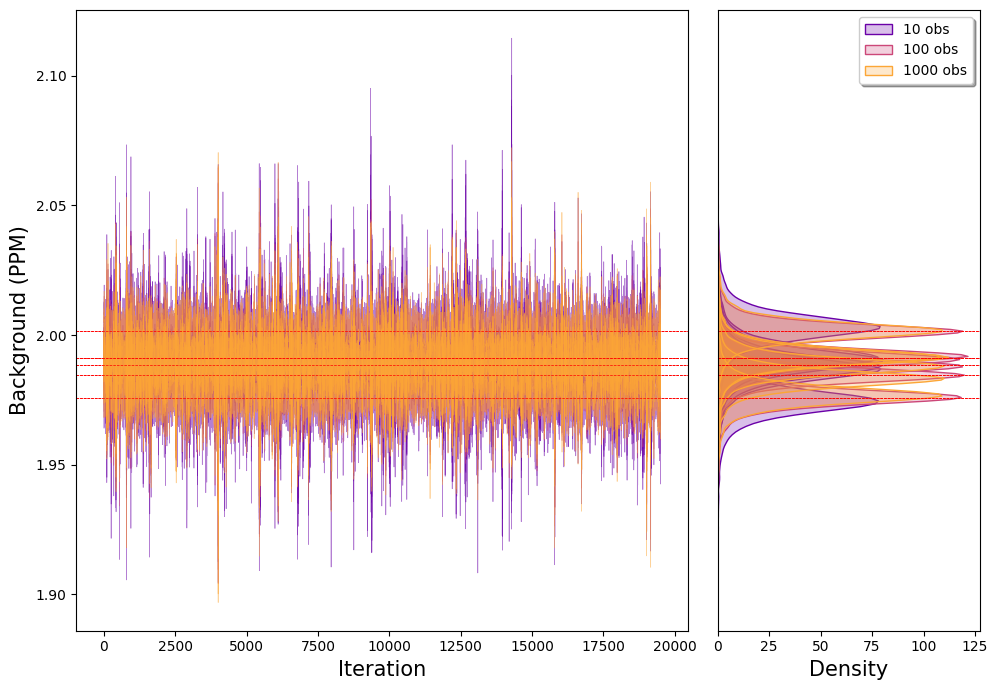

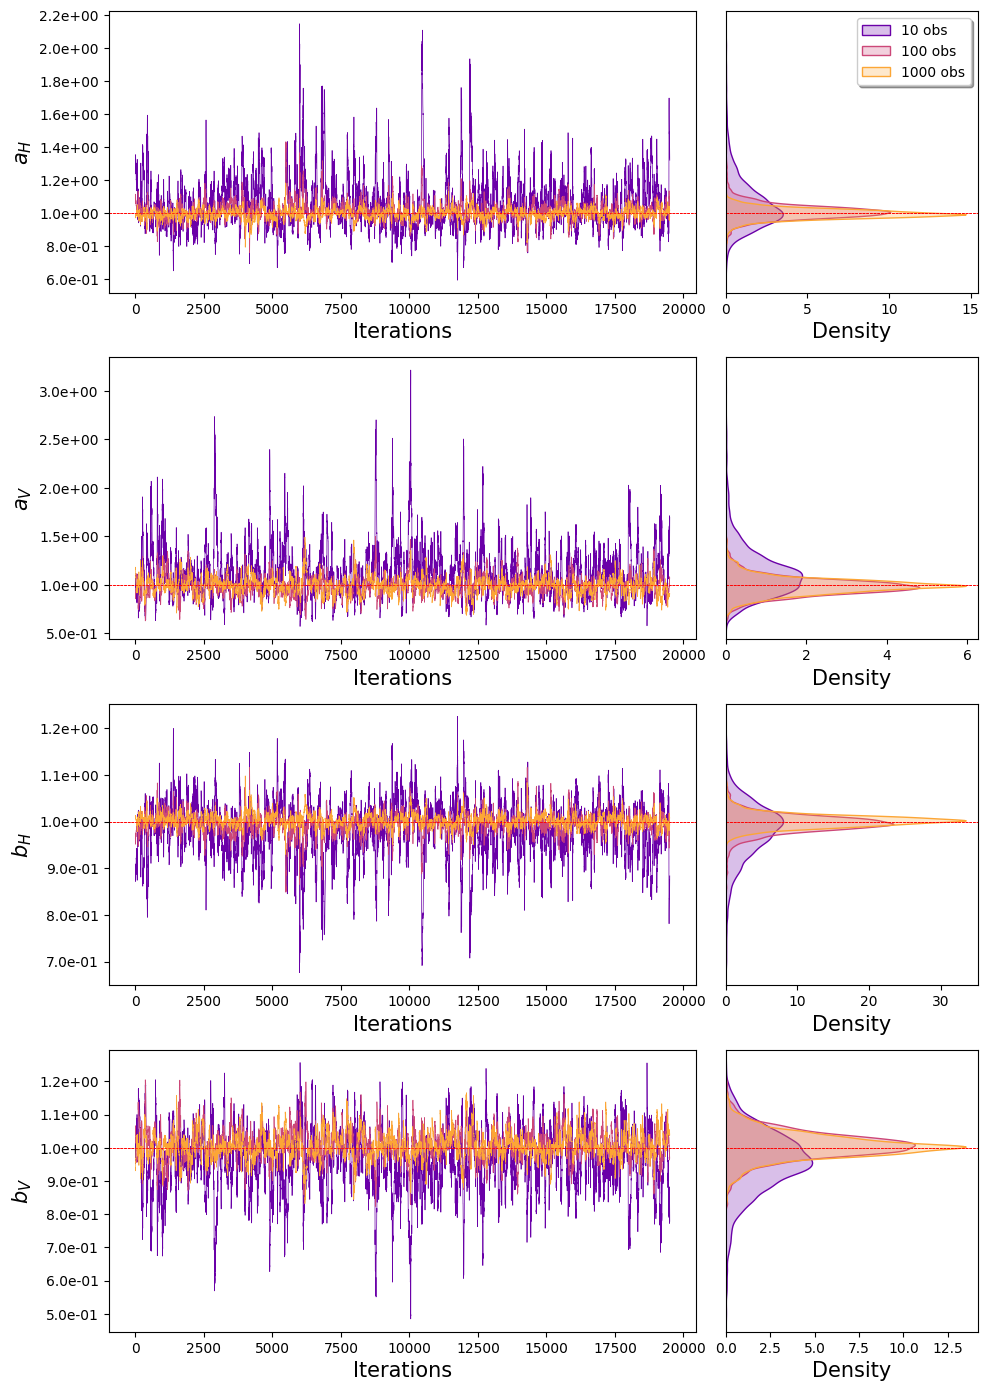

In [26]:
with open('../../Data/MCMC_chains/Simulation_study/Varying parameters/Varying number of obs per sensor/10_per_sensor.pkl', 'rb') as f:
    ten_per_sensor = pickle.load(f)
with open('../../Data/MCMC_chains/Simulation_study/Varying parameters/Varying number of obs per sensor/1000_per_sensor.pkl', 'rb') as f:
    thousand_per_sensor = pickle.load(f)

varying_observations_per_sensor = {
    '10 obs': ten_per_sensor,
    '100 obs': level_M,
    '1000 obs': thousand_per_sensor,
}

plot_source_location_estimates(500, True, varying_observations_per_sensor, dark=False, save=False)
plot_source_location_densities(500, True, varying_observations_per_sensor, dark=False, save=False)
plot_source_emission_rate(500, True, varying_observations_per_sensor, dark=False, save=False)
plot_sensor_measurement_error_variance(500, varying_observations_per_sensor, dark=False, save=False)
plot_background(500, varying_observations_per_sensor, dark=False, save=False)
plot_diffusion_parameters(500, True, varying_observations_per_sensor, dark=False, save=False)

## 1.6 Varying the Sensor Layout

<div class="alert alert-block alert-info">
<b>DATA:</b> Need to replace data file paths with your own local path. The files are all located in the folder:<br>
Paper 1: Code/Data/MCMC_chains/Simulation_study/Varying parameters/Varying sensor layout/...
</div>

C:\Users\teresa-klatzer\AppData\Local\Temp\ipykernel_16844\3356035549.py:2: DeprecationWarning: Pickled array contains an aval with a named_shape attribute. This is deprecated and the code path supporting such avals will be removed. Please re-pickle the array.
  line = pickle.load(f)
C:\Users\teresa-klatzer\AppData\Local\Temp\ipykernel_16844\3356035549.py:4: DeprecationWarning: Pickled array contains an aval with a named_shape attribute. This is deprecated and the code path supporting such avals will be removed. Please re-pickle the array.
  sparse_line = pickle.load(f)


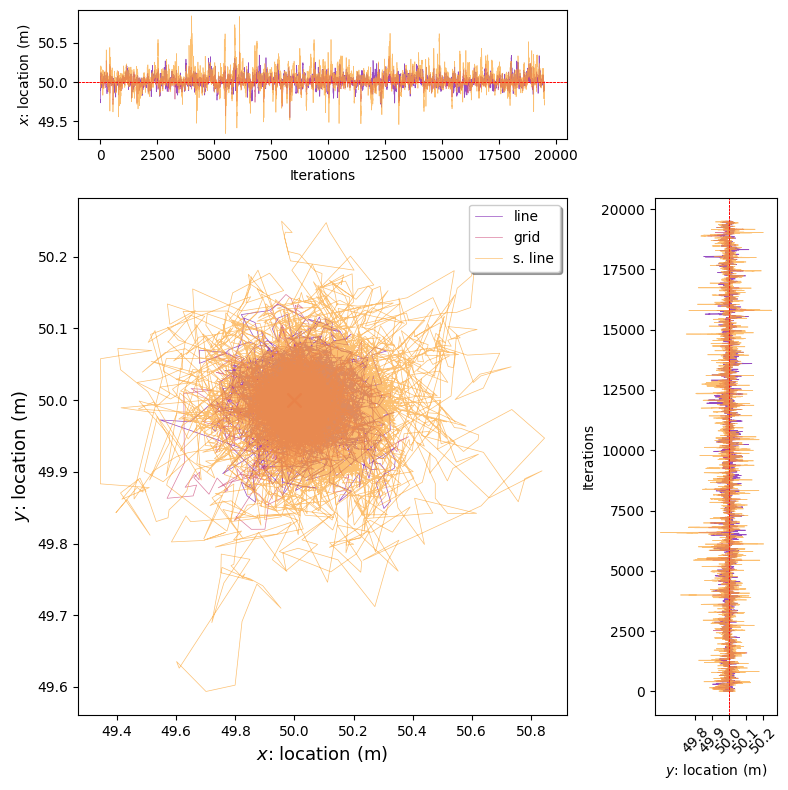

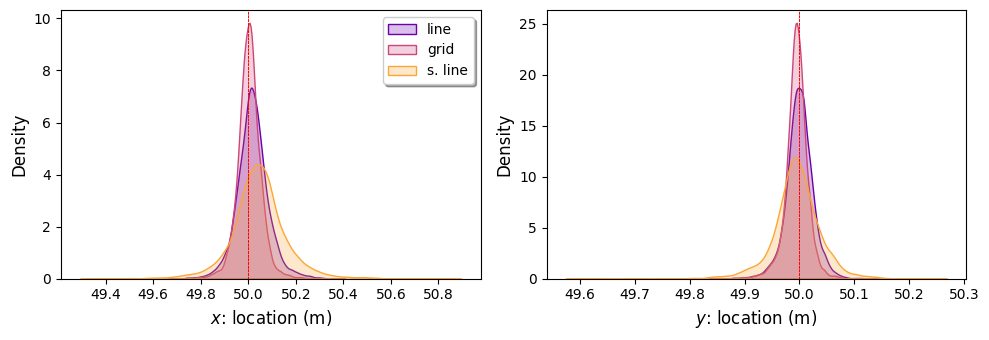

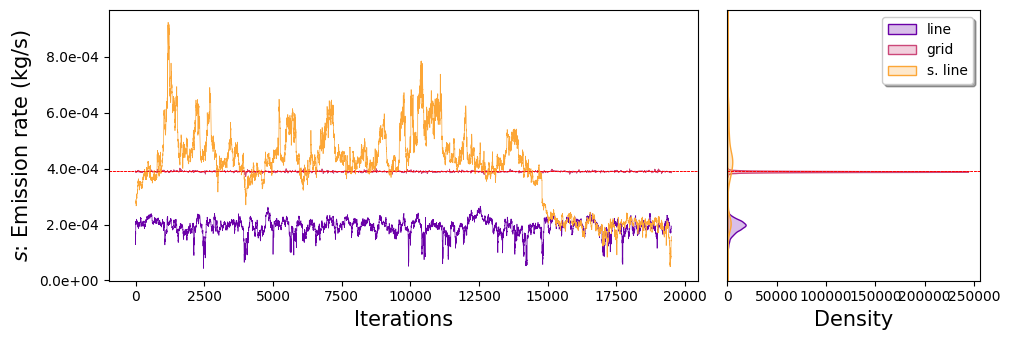

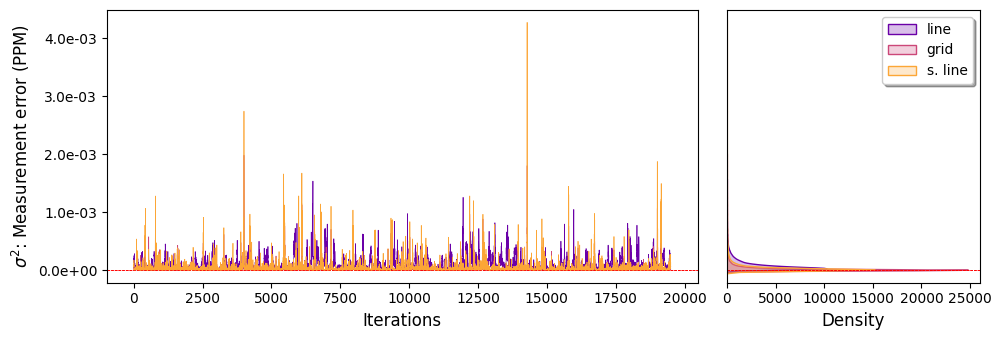

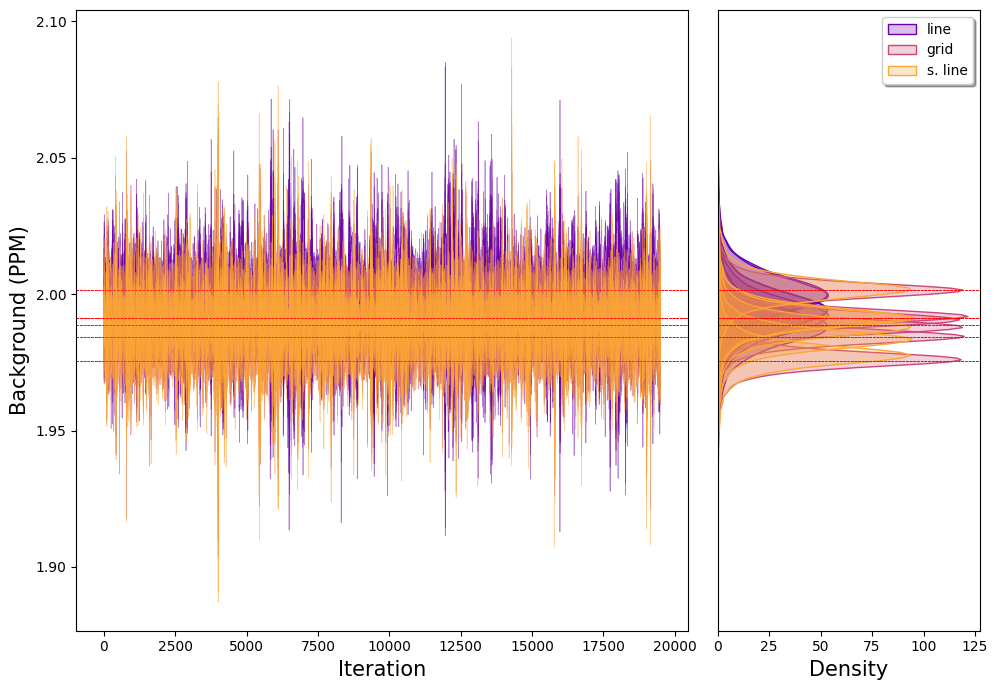

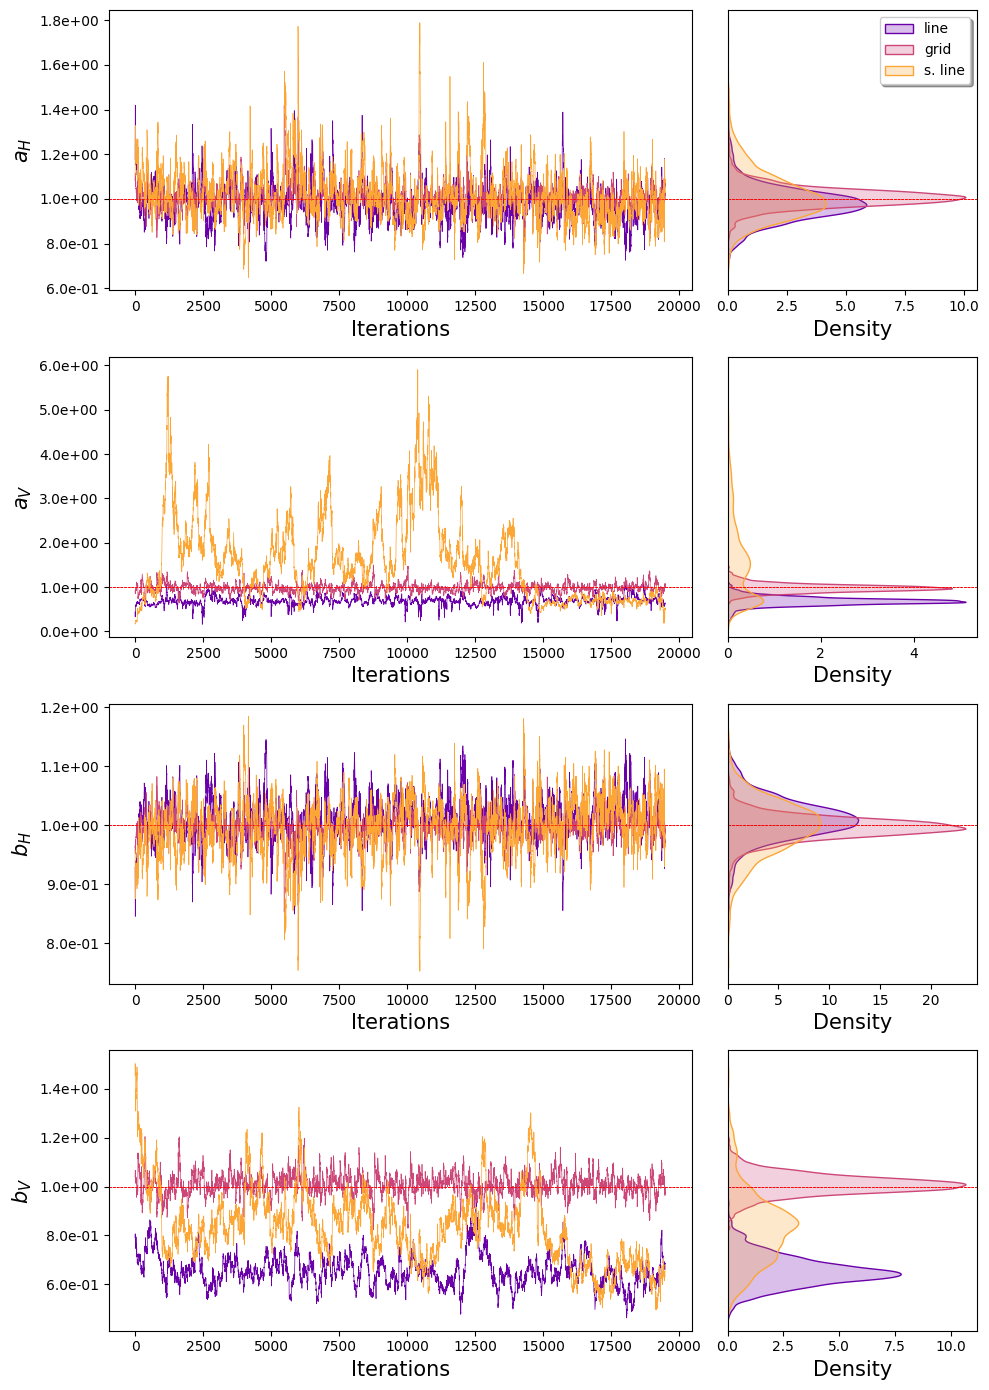

In [27]:
with open('../../Data/MCMC_chains/Simulation_study/Varying parameters/Varying sensor layout/line.pkl', 'rb') as f:
    line = pickle.load(f)
with open('../../Data/MCMC_chains/Simulation_study/Varying parameters/Varying sensor layout/sparse_line.pkl', 'rb') as f:
    sparse_line = pickle.load(f)

varying_sensor_layout = {
    'line': line,
    'grid': level_M,
    's. line': sparse_line,
}

plot_source_location_estimates(500, True, varying_sensor_layout, dark=False, save=False)
plot_source_location_densities(500, True, varying_sensor_layout, dark=False, save=False)
plot_source_emission_rate(500, True, varying_sensor_layout, dark=False, save=False)
plot_sensor_measurement_error_variance(500, varying_sensor_layout, dark=False, save=False)
plot_background(500, varying_sensor_layout, dark=False, save=False)
plot_diffusion_parameters(500, True, varying_sensor_layout, dark=False, save=False)

In-depth sensor layout

<div class="alert alert-block alert-info">
<b>DATA:</b> Need to replace data file paths with your own local path. The files are all located in the folder:<br>
Paper 1: Code/Data/MCMC_chains/Simulation_study/In-depth simulations/Sensor layout/...
</div>

In [28]:
# Line layouts
with open('../../Data/MCMC_chains/Simulation_study/In-depth simulations/Sensor layout/4_by_1_grid.pkl', 'rb') as f:
    four_by_one = pickle.load(f)
with open('../../Data/MCMC_chains/Simulation_study/In-depth simulations/Sensor layout/9_by_1_grid.pkl', 'rb') as f:
    nine_by_one = pickle.load(f)
with open('../../Data/MCMC_chains/Simulation_study/In-depth simulations/Sensor layout/16_by_1_grid.pkl', 'rb') as f:
    sixteen_by_one = pickle.load(f)
with open('../../Data/MCMC_chains/Simulation_study/In-depth simulations/Sensor layout/36_by_1_grid.pkl', 'rb') as f:
    thirtysix_by_one = pickle.load(f)

# Grid layouts
with open('../../Data/MCMC_chains/Simulation_study/In-depth simulations/Sensor layout/2_by_2_grid.pkl', 'rb') as f:
    two_by_two = pickle.load(f)
with open('../../Data/MCMC_chains/Simulation_study/In-depth simulations/Sensor layout/3_by_3_grid.pkl', 'rb') as f:
    three_by_three = pickle.load(f)
with open('../../Data/MCMC_chains/Simulation_study/In-depth simulations/Sensor layout/4_by_4_grid.pkl', 'rb') as f:
    four_by_four = pickle.load(f)
with open('../../Data/MCMC_chains/Simulation_study/In-depth simulations/Sensor layout/6_by_6_grid.pkl', 'rb') as f:
    six_by_six = pickle.load(f)
    


in_depth_varying_sensor_layout = {

    # 4 sensors
    '4x1' : four_by_one,
    '2x2' : two_by_two,

    # 9 sensors
    '9x1' : nine_by_one,
    '3x3' : three_by_three,

    # 16 sensors
    '16x1' : sixteen_by_one,
    '4x4' : four_by_four,

    # 36 sensors
    '36x1' : thirtysix_by_one,
    '6x6' : six_by_six,

}


in_depth_varying_sensor_layout = {
    # 4 sensors
    '4x1' : four_by_one,
    '9x1' : nine_by_one,
    '16x1' : sixteen_by_one,
    '36x1' : thirtysix_by_one,

    '2x2' : two_by_two,
    '3x3' : three_by_three,
    '4x4' : four_by_four,
    '6x6' : six_by_six,
}

C:\Users\teresa-klatzer\AppData\Local\Temp\ipykernel_16844\2310556077.py:3: DeprecationWarning: Pickled array contains an aval with a named_shape attribute. This is deprecated and the code path supporting such avals will be removed. Please re-pickle the array.
  four_by_one = pickle.load(f)
C:\Users\teresa-klatzer\AppData\Local\Temp\ipykernel_16844\2310556077.py:5: DeprecationWarning: Pickled array contains an aval with a named_shape attribute. This is deprecated and the code path supporting such avals will be removed. Please re-pickle the array.
  nine_by_one = pickle.load(f)
C:\Users\teresa-klatzer\AppData\Local\Temp\ipykernel_16844\2310556077.py:7: DeprecationWarning: Pickled array contains an aval with a named_shape attribute. This is deprecated and the code path supporting such avals will be removed. Please re-pickle the array.
  sixteen_by_one = pickle.load(f)
C:\Users\teresa-klatzer\AppData\Local\Temp\ipykernel_16844\2310556077.py:9: DeprecationWarning: Pickled array contains an

C:\Users\teresa-klatzer\AppData\Local\Temp\ipykernel_16844\3733537598.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = ax.boxplot(values, labels=data.keys(), vert=True, patch_artist=True, showfliers=False)
C:\Users\teresa-klatzer\AppData\Local\Temp\ipykernel_16844\3733537598.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = ax.boxplot(values, labels=data.keys(), vert=True, patch_artist=True, showfliers=False)
C:\Users\teresa-klatzer\AppData\Local\Temp\ipykernel_16844\3733537598.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = ax.boxplot(values, labels=data.keys(), vert=True, pa

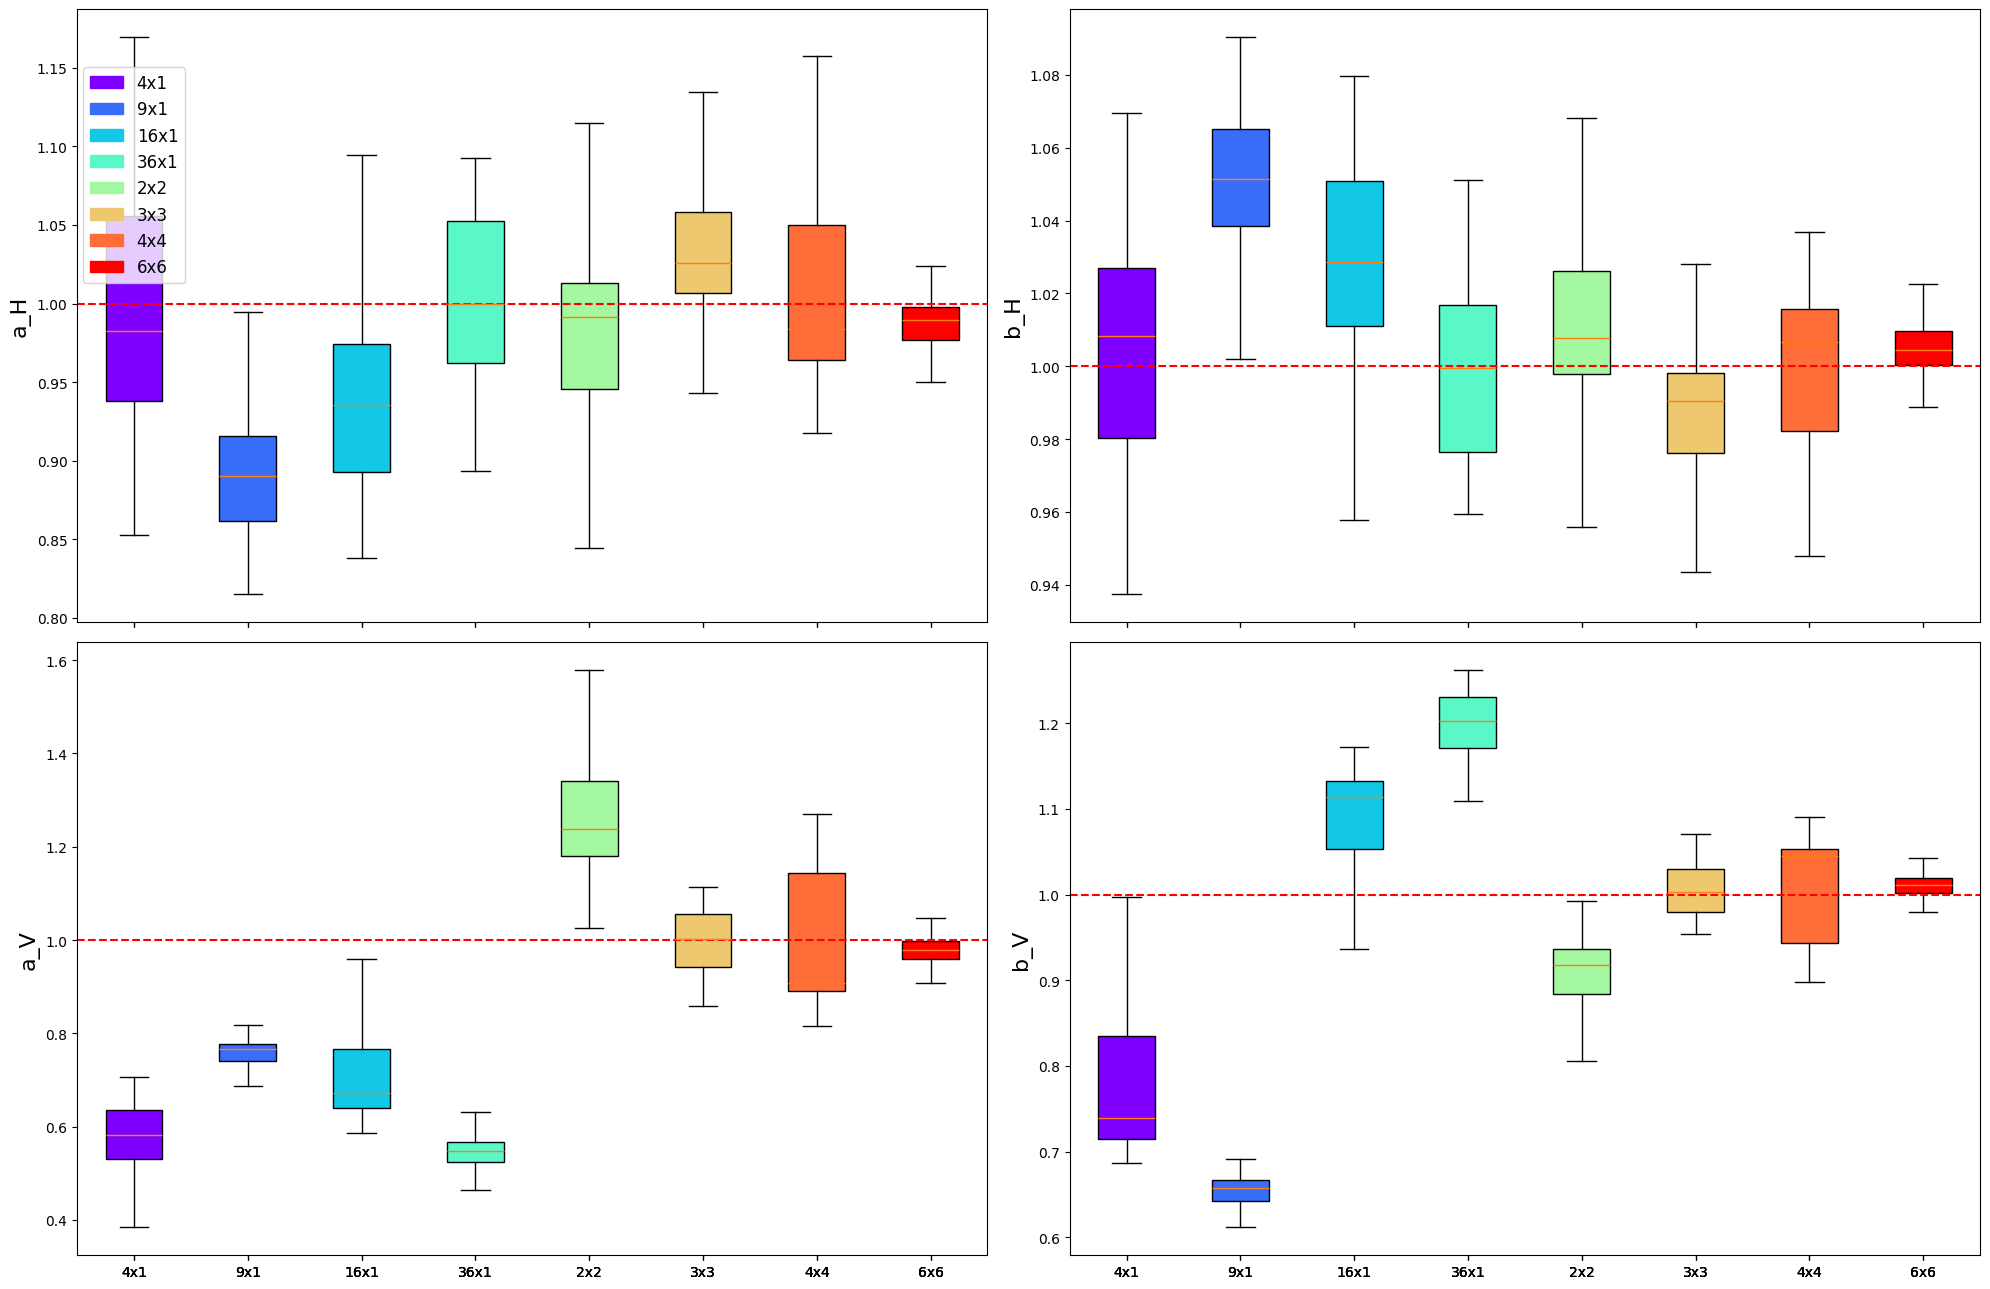

C:\Users\teresa-klatzer\AppData\Local\Temp\ipykernel_16844\3733537598.py:62: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = ax.boxplot(values, labels=data.keys(), vert=True, patch_artist=True, showfliers=False)
C:\Users\teresa-klatzer\AppData\Local\Temp\ipykernel_16844\3733537598.py:62: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = ax.boxplot(values, labels=data.keys(), vert=True, patch_artist=True, showfliers=False)
C:\Users\teresa-klatzer\AppData\Local\Temp\ipykernel_16844\3733537598.py:62: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = ax.boxplot(values, labels=data.keys(), vert=True, pa

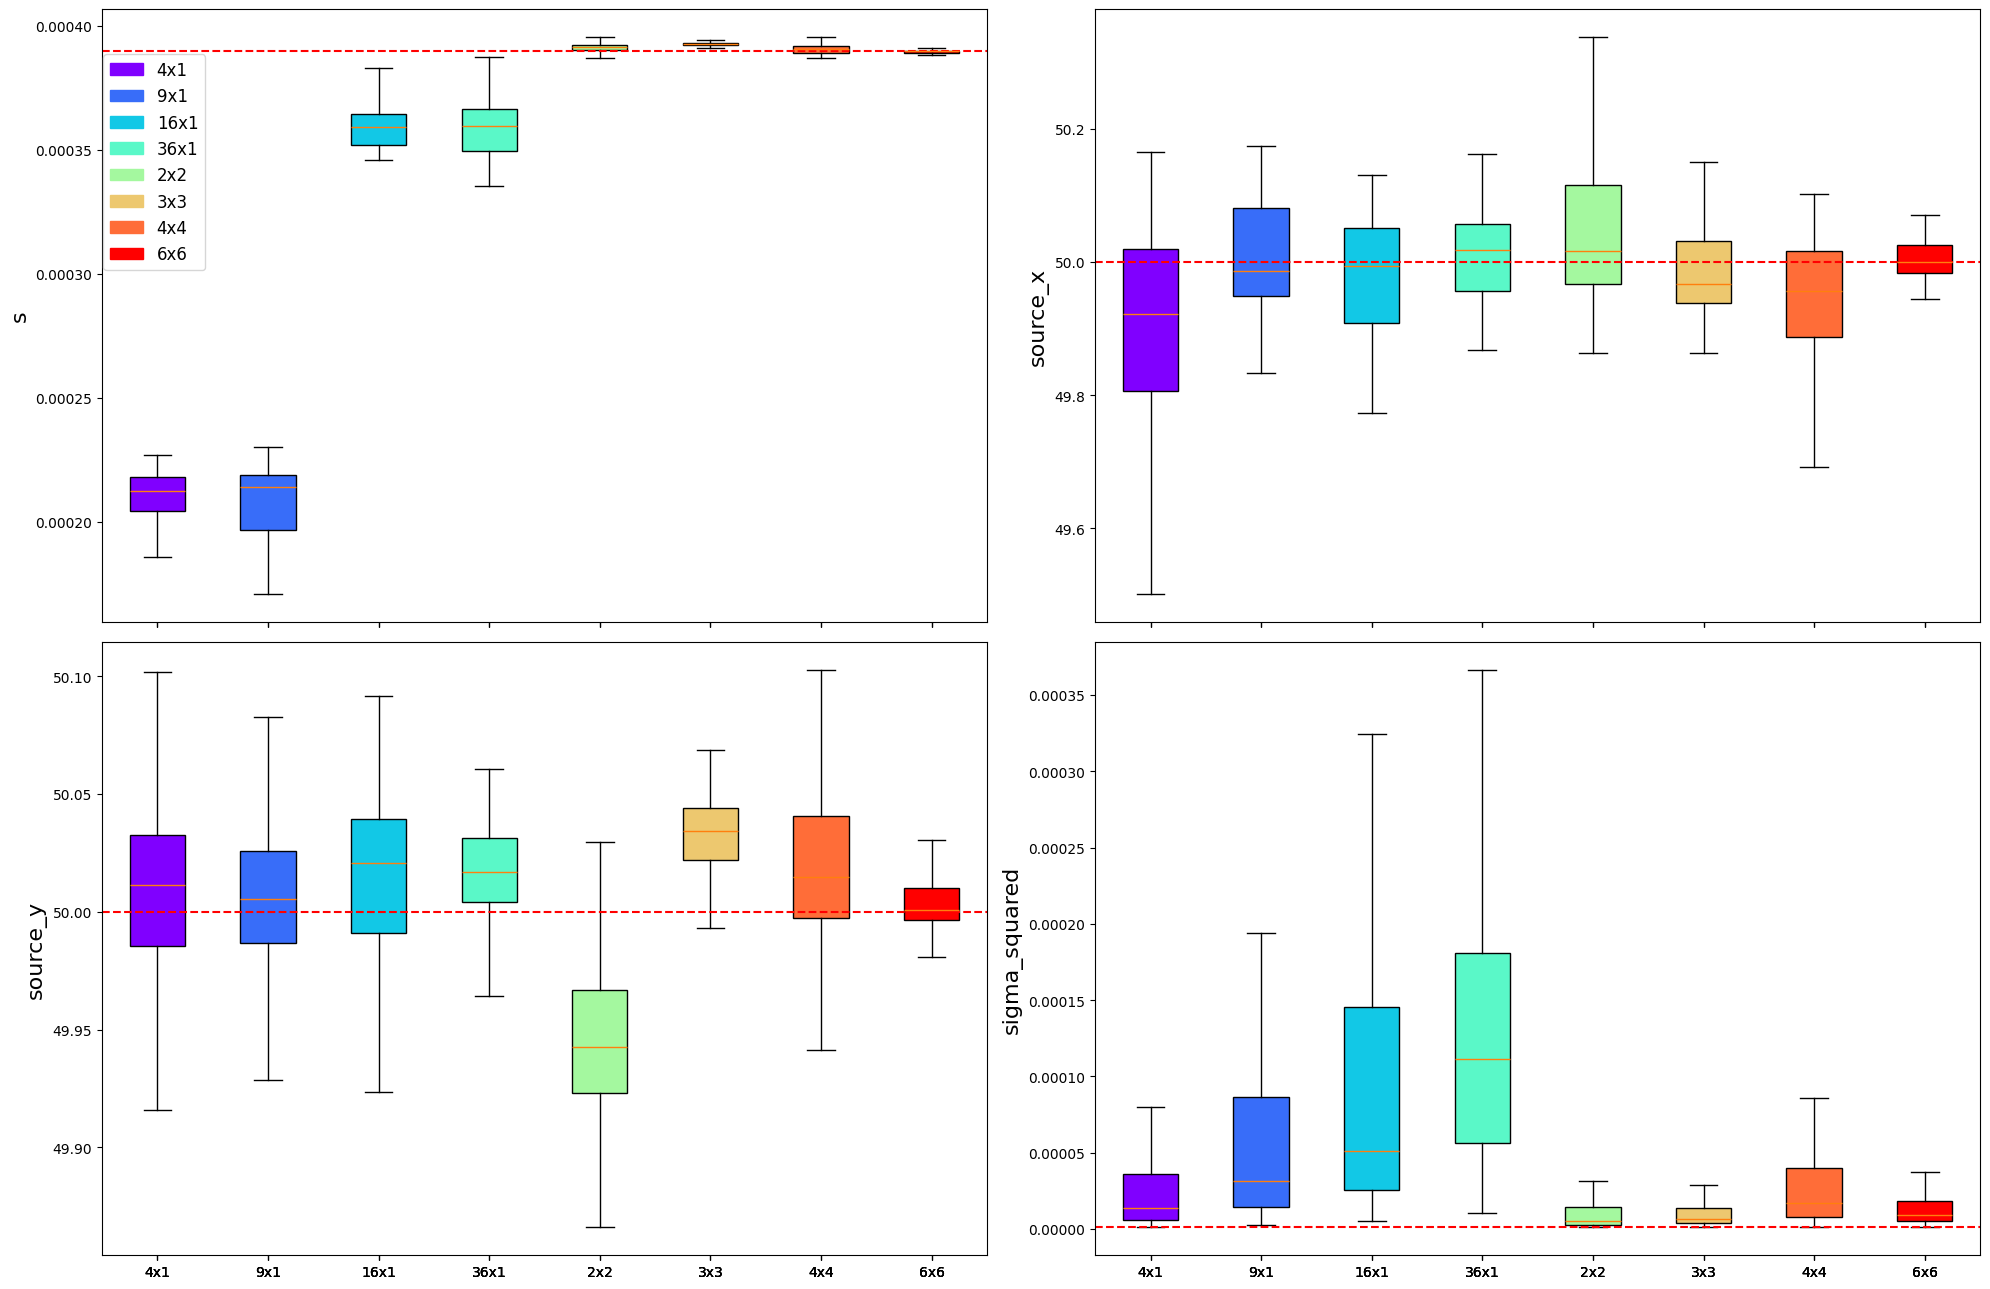

In [29]:
plot_boxplots_diffusion_parameters(in_depth_varying_sensor_layout, burn_in=39_000)
plot_boxplots_source(in_depth_varying_sensor_layout, burn_in=39_000)

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Main paper

# Section 4.1: Single Source Estimation

In [30]:
all_simulations = [varying_wind_direction_coverage, varying_diffusion_parameters, varying_emission_rate, varying_distances, varying_observations_per_sensor, varying_sensor_layout]

In [31]:
def plot_boxplots(data, burn_in, error=True, shared_y = True, save=False):
    # Create a figure and a set of subplots
    if shared_y:
        fig, axs = plt.subplots(8, len(data), figsize=(18, 23), sharex='col', sharey='row')
    else:
        fig, axs = plt.subplots(8, len(data), figsize=(18, 23), sharex='col')
    plt.style.use('default')
    # Define the variables to plot
    variables = ["s", "source_x", "source_y", "a_H", "b_H", "a_V", "b_V", 'sigma_squared']
    variable_labels = ["$s$", "$x$", "$y$", "$a_H$", "$b_H$", "$a_V$", "$b_V$", '$\sigma^2$']
    # Get the rainbow colormap
    cmap = plt.get_cmap('plasma')
    # Column titles
    column_titles = ["WDC", "DPV", "SER", "DTS", "OPS", "SL"]
    # True parameter values
    true_values = [0.00039, 50.0, 50.0, 1.0, 1.0, 1.0, 1.0, 1e-6]
    # Special cases with multiple truths
    varying_location = [70, 50, 30]
    varying_emission = [0.00039/2, 0.00039, 0.00039*2]
    varying_a_H = [1.4, 1.0, 0.9]
    varying_b_H = [0.9, 1.0, 0.8]
    varying_a_V = [1.2, 1.0, 0.7]
    varying_b_V = [0.95, 1.0, 0.85]

    if error == True:
        # For each dictionary in the list
        for i, d in enumerate(data):
            # For each variable
            for j, var in enumerate(variables):
                # Extract the values of the variable from the dictionaries
                values = [inner_d[var].flatten()[burn_in:] for inner_d in d.values()]
                # Plot a boxplot of the values
                if j == 0 and i == 2:
                    box = axs[j, i].boxplot(jnp.array(varying_emission).reshape(-1,1) - jnp.array(values), showfliers=False, patch_artist=True, labels=d.keys())
                elif j == 1 and i == 1:
                    box = axs[j, i].boxplot(jnp.array(varying_location).reshape(-1,1) - jnp.array(values), showfliers=False, patch_artist=True, labels=d.keys())
                elif j == 3 and i == 4:
                    box = axs[j, i].boxplot(jnp.array(varying_a_H).reshape(-1,1) - jnp.array(values), showfliers=False, patch_artist=True, labels=d.keys())
                elif j == 4 and i == 4:
                    box = axs[j, i].boxplot(jnp.array(varying_b_H).reshape(-1,1) - jnp.array(values), showfliers=False, patch_artist=True, labels=d.keys())
                elif j == 5 and i == 4:
                    box = axs[j, i].boxplot(jnp.array(varying_a_V).reshape(-1,1) - jnp.array(values), showfliers=False, patch_artist=True, labels=d.keys())
                elif j == 6 and i == 4:
                    box = axs[j, i].boxplot(jnp.array(varying_b_V).reshape(-1,1) - jnp.array(values), showfliers=False, patch_artist=True, labels=d.keys())
                else:
                    box = axs[j, i].boxplot(true_values[j] - jnp.array(values), showfliers=False, patch_artist=True, labels=d.keys())

                colors = [cmap(k) for k in np.linspace(0, 0.9, len(box['boxes']))]
                for patch, color in zip(box['boxes'], colors):
                    patch.set_facecolor(color)
                axs[j,i].axhline(y=0.0, color='r', linestyle='--', lw=0.4)
                axs[j,i].grid(True, which='both', linestyle='--', lw=0.5) 

    
    elif error == False:
        # For each dictionary in the list
        for i, d in enumerate(data):
            # For each variable
            for j, var in enumerate(variables):
                # Extract the values of the variable from the dictionaries
                values = [inner_d[var].flatten()[burn_in:] for inner_d in d.values()]
                box = axs[j, i].boxplot(values, showfliers=False, patch_artist=True, labels=d.keys())
                colors = [cmap(k) for k in np.linspace(0, 0.95, len(box['boxes']))]
                for patch, color in zip(box['boxes'], colors):
                    patch.set_facecolor(color)
                axs[j,i].grid(True, which='both', linestyle='--', lw=0.5) 
                if j == 0:
                    axs[j,i].axhline(y=true_values[0], color='r', linestyle='--', lw=0.4)
                    scale_factor = 1e5
                    axs[j,i].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x*scale_factor)))
                    if i == 2:
                        axs[j,i].axhline(y=varying_emission[0], color='r', linestyle='--', lw=0.4)
                        axs[j,i].axhline(y=varying_emission[2], color='r', linestyle='--', lw=0.4)
                if j == 1:
                    axs[j,i].axhline(y=true_values[1], color='r', linestyle='--', lw=0.4)
                    if i == 3:
                        axs[j,i].axhline(y=varying_location[0], color='r', linestyle='--', lw=0.4)
                        axs[j,i].axhline(y=varying_location[2], color='r', linestyle='--', lw=0.4)
                if j == 2:
                    axs[j,i].axhline(y=true_values[2], color='r', linestyle='--', lw=0.4)
                if j == 3:
                    axs[j,i].axhline(y=true_values[3], color='r', linestyle='--', lw=0.4)
                    if i == 1:
                        axs[j,i].axhline(y=varying_a_H[0], color='r', linestyle='--', lw=0.4)
                        axs[j,i].axhline(y=varying_a_H[2], color='r', linestyle='--', lw=0.4)
                if j == 4:
                    axs[j,i].axhline(y=true_values[4], color='r', linestyle='--', lw=0.4)
                    if i == 1:
                        axs[j,i].axhline(y=varying_b_H[0], color='r', linestyle='--', lw=0.4)
                        axs[j,i].axhline(y=varying_b_H[2], color='r', linestyle='--', lw=0.4)
                if j == 5:
                    axs[j,i].axhline(y=true_values[5], color='r', linestyle='--', lw=0.4)
                    if i == 1:
                        axs[j,i].axhline(y=varying_a_V[0], color='r', linestyle='--', lw=0.4)
                        axs[j,i].axhline(y=varying_a_V[2], color='r', linestyle='--', lw=0.4)
                if j == 6:
                    axs[j,i].axhline(y=true_values[6], color='r', linestyle='--', lw=0.4)
                    if i == 1:
                        axs[j,i].axhline(y=varying_b_V[0], color='r', linestyle='--', lw=0.4)
                        axs[j,i].axhline(y=varying_b_V[2], color='r', linestyle='--', lw=0.4)
                if j == 7:
                    axs[j,i].axhline(y=true_values[7], color='r', linestyle='--', lw=0.4)  
                

        
    # Set the y-axis labels
    for j, var in enumerate(variables):
        axs[j, 0].set_ylabel(variable_labels[j], fontsize=18)
    for i, d in enumerate(data):
        # Set the title for the column
        axs[0, i].set_title(column_titles[i], fontsize=18)    # Adjust the layout of the subplots
    
    plt.tight_layout()
    if save:
        plt.savefig('huge_boxplots.pdf', dpi=300, bbox_inches='tight', transparent=False)
    # Show the plot
    plt.show()



def plot_boxplots_1(data, burn_in, error=True, shared_y = True, save=False):
    # Create a figure and a set of subplots
    if shared_y:
        fig, axs = plt.subplots(4, len(data), figsize=(15, 8.5), sharex='col', sharey='row')
    else:
        fig, axs = plt.subplots(4, len(data), figsize=(15, 8.5), sharex='col')
    plt.style.use('default')
    # Define the variables to plot
    variables = ["s", "source_x", "source_y", 'sigma_squared']
    variable_labels = ["$s$", "$x$", "$y$", '$\sigma^2$']
    # Get the rainbow colormap
    cmap = plt.get_cmap('plasma')
    # Column titles
    column_titles = ["WDC", "DPV", "SER", "DTS", "OPS", "SL"]
    # True parameter values
    true_values = [0.00039, 50.0, 50.0, 1e-6]
    # Special cases with multiple truths
    varying_location = [70, 50, 30]
    varying_emission = [0.00039/2, 0.00039, 0.00039*2]
    varying_a_H = [1.4, 1.0, 0.9]
    varying_b_H = [0.9, 1.0, 0.8]
    varying_a_V = [1.2, 1.0, 0.7]
    varying_b_V = [0.95, 1.0, 0.85]

    if error == True:
        # For each dictionary in the list
        for i, d in enumerate(data):
            # For each variable
            for j, var in enumerate(variables):
                # Extract the values of the variable from the dictionaries
                values = [inner_d[var].flatten()[burn_in:] for inner_d in d.values()]
                # Plot a boxplot of the values
                if j == 0 and i == 2:
                    box = axs[j, i].boxplot(jnp.array(varying_emission).reshape(-1,1) - jnp.array(values), showfliers=False, patch_artist=True, labels=d.keys())
                elif j == 1 and i == 1:
                    box = axs[j, i].boxplot(jnp.array(varying_location).reshape(-1,1) - jnp.array(values), showfliers=False, patch_artist=True, labels=d.keys())
                elif j == 3 and i == 4:
                    box = axs[j, i].boxplot(jnp.array(varying_a_H).reshape(-1,1) - jnp.array(values), showfliers=False, patch_artist=True, labels=d.keys())
                elif j == 4 and i == 4:
                    box = axs[j, i].boxplot(jnp.array(varying_b_H).reshape(-1,1) - jnp.array(values), showfliers=False, patch_artist=True, labels=d.keys())
                elif j == 5 and i == 4:
                    box = axs[j, i].boxplot(jnp.array(varying_a_V).reshape(-1,1) - jnp.array(values), showfliers=False, patch_artist=True, labels=d.keys())
                elif j == 6 and i == 4:
                    box = axs[j, i].boxplot(jnp.array(varying_b_V).reshape(-1,1) - jnp.array(values), showfliers=False, patch_artist=True, labels=d.keys())
                else:
                    box = axs[j, i].boxplot(true_values[j] - jnp.array(values), showfliers=False, patch_artist=True, labels=d.keys())

                colors = [cmap(k) for k in np.linspace(0, 0.9, len(box['boxes']))]
                for patch, color in zip(box['boxes'], colors):
                    patch.set_facecolor(color)
                axs[j,i].axhline(y=0.0, color='r', linestyle='--', lw=0.7)
                axs[j,i].grid(True, which='both', linestyle='--', lw=0.5) 

    
    elif error == False:
        # For each dictionary in the list
        for i, d in enumerate(data):
            # For each variable
            for j, var in enumerate(variables):
                # Extract the values of the variable from the dictionaries
                values = [inner_d[var].flatten()[burn_in:] for inner_d in d.values()]
                box = axs[j, i].boxplot(values, showfliers=False, patch_artist=True, labels=d.keys())
                colors = [cmap(k) for k in np.linspace(0, 0.95, len(box['boxes']))]
                for patch, color in zip(box['boxes'], colors):
                    patch.set_facecolor(color)
                axs[j,i].grid(True, which='both', linestyle='--', lw=0.5) 
                axs[j,i].tick_params(axis='x', labelsize=15)  # change '10' to your desired font size
                plt.setp(axs[j,i].get_xticklabels(), rotation=45)  # change '45' to your desired tilt angle
                axs[j,i].ticklabel_format(style='sci', axis='y', scilimits=(0, 0), useMathText=True)

                if j == 0:
                    axs[j,i].axhline(y=varying_emission[1], color='r', linestyle='--', lw=0.7)
                    if i == 2:
                        axs[j,i].axhline(y=varying_emission[0], color='r', linestyle='--', lw=0.7)
                        axs[j,i].axhline(y=varying_emission[2], color='r', linestyle='--', lw=0.7)
                if j == 1:
                    axs[j,i].axhline(y=true_values[1], color='r', linestyle='--', lw=0.7)
                    if i == 3:
                        axs[j,i].axhline(y=varying_location[0], color='r', linestyle='--', lw=0.7)
                        axs[j,i].axhline(y=varying_location[2], color='r', linestyle='--', lw=0.7)
                if j == 2:
                    axs[j,i].axhline(y=true_values[2], color='r', linestyle='--', lw=0.7)
                if j == 3:
                    axs[j,i].axhline(y=true_values[3], color='r', linestyle='--', lw=0.7)  
                

        
    # Set the y-axis labels
    for j, var in enumerate(variables):
        axs[j, 0].set_ylabel(variable_labels[j], fontsize=20)
    for i, d in enumerate(data):
        # Set the title for the column
        axs[0, i].set_title(column_titles[i], fontsize=18)    # Adjust the layout of the subplots

    plt.tight_layout()
    if save:
        plt.savefig('huge_boxplots_1.pdf', dpi=300, bbox_inches='tight', transparent=False)
    # Show the plot
    plt.show()



def plot_boxplots_2(data, burn_in, error=True, shared_y = True, save=False):
    # Create a figure and a set of subplots
    if shared_y:
        fig, axs = plt.subplots(4, len(data), figsize=(15, 8.5), sharex='col', sharey='row')
    else:
        fig, axs = plt.subplots(4, len(data), figsize=(15, 8.5), sharex='col')
    plt.style.use('default')
    # Define the variables to plot
    variables = ["a_H", "b_H", "a_V", "b_V"]
    variable_labels = ["$a_H$", "$b_H$", "$a_V$", "$b_V$"]
    # Get the rainbow colormap
    cmap = plt.get_cmap('plasma')
    # Column titles
    column_titles = ["WDC", "DPV", "SER", "DTS", "OPS", "SL"]
    # True parameter values
    true_values = [1.0, 1.0, 1.0, 1.0]
    # Special cases with multiple truths
    varying_location = [70, 50, 30]
    varying_emission = [0.00039/2, 0.00039, 0.00039*2]
    varying_a_H = [1.4, 1.0, 0.9]
    varying_b_H = [0.9, 1.0, 0.8]
    varying_a_V = [1.2, 1.0, 0.7]
    varying_b_V = [0.95, 1.0, 0.85]

    if error == True:
        # For each dictionary in the list
        for i, d in enumerate(data):
            # For each variable
            for j, var in enumerate(variables):
                # Extract the values of the variable from the dictionaries
                values = [inner_d[var].flatten()[burn_in:] for inner_d in d.values()]
                # Plot a boxplot of the values
                if j == 0 and i == 2:
                    box = axs[j, i].boxplot(jnp.array(varying_emission).reshape(-1,1) - jnp.array(values), showfliers=False, patch_artist=True, labels=d.keys())
                elif j == 1 and i == 1:
                    box = axs[j, i].boxplot(jnp.array(varying_location).reshape(-1,1) - jnp.array(values), showfliers=False, patch_artist=True, labels=d.keys())
                elif j == 3 and i == 4:
                    box = axs[j, i].boxplot(jnp.array(varying_a_H).reshape(-1,1) - jnp.array(values), showfliers=False, patch_artist=True, labels=d.keys())
                elif j == 4 and i == 4:
                    box = axs[j, i].boxplot(jnp.array(varying_b_H).reshape(-1,1) - jnp.array(values), showfliers=False, patch_artist=True, labels=d.keys())
                elif j == 5 and i == 4:
                    box = axs[j, i].boxplot(jnp.array(varying_a_V).reshape(-1,1) - jnp.array(values), showfliers=False, patch_artist=True, labels=d.keys())
                elif j == 6 and i == 4:
                    box = axs[j, i].boxplot(jnp.array(varying_b_V).reshape(-1,1) - jnp.array(values), showfliers=False, patch_artist=True, labels=d.keys())
                else:
                    box = axs[j, i].boxplot(true_values[j] - jnp.array(values), showfliers=False, patch_artist=True, labels=d.keys())

                colors = [cmap(k) for k in np.linspace(0, 0.9, len(box['boxes']))]
                for patch, color in zip(box['boxes'], colors):
                    patch.set_facecolor(color)
                axs[j,i].axhline(y=0.0, color='r', linestyle='--', lw=0.7)
                axs[j,i].grid(True, which='both', linestyle='--', lw=0.5) 

    
    elif error == False:
        # For each dictionary in the list
        for i, d in enumerate(data):
            # For each variable
            for j, var in enumerate(variables):
                # Extract the values of the variable from the dictionaries
                values = [inner_d[var].flatten()[burn_in:] for inner_d in d.values()]
                box = axs[j, i].boxplot(values, showfliers=False, patch_artist=True, labels=d.keys())
                colors = [cmap(k) for k in np.linspace(0, 0.95, len(box['boxes']))]
                for patch, color in zip(box['boxes'], colors):
                    patch.set_facecolor(color)
                axs[j,i].grid(True, which='both', linestyle='--', lw=0.5) 
                axs[j,i].tick_params(axis='x', labelsize=15)  # change '10' to your desired font size
                plt.setp(axs[j,i].get_xticklabels(), rotation=45)  # change '45' to your desired tilt angle
                axs[j,i].ticklabel_format(style='sci', axis='y', scilimits=(0, 0), useMathText=True)

                if j == 0:
                    axs[j,i].axhline(y=true_values[0], color='r', linestyle='--', lw=0.7)
                    if i == 1:
                        axs[j,i].axhline(y=varying_a_H[0], color='r', linestyle='--', lw=0.7)
                        axs[j,i].axhline(y=varying_a_H[2], color='r', linestyle='--', lw=0.7)
                if j == 1:
                    axs[j,i].axhline(y=true_values[1], color='r', linestyle='--', lw=0.7)
                    if i == 1:
                        axs[j,i].axhline(y=varying_b_H[0], color='r', linestyle='--', lw=0.7)
                        axs[j,i].axhline(y=varying_b_H[2], color='r', linestyle='--', lw=0.7)
                if j == 2:
                    axs[j,i].axhline(y=true_values[2], color='r', linestyle='--', lw=0.7)
                    if i == 1:
                        axs[j,i].axhline(y=varying_a_V[0], color='r', linestyle='--', lw=0.7)
                        axs[j,i].axhline(y=varying_a_V[2], color='r', linestyle='--', lw=0.7)
                if j == 3:
                    axs[j,i].axhline(y=true_values[3], color='r', linestyle='--', lw=0.7)
                    if i == 1:
                        axs[j,i].axhline(y=varying_b_V[0], color='r', linestyle='--', lw=0.7)
                        axs[j,i].axhline(y=varying_b_V[2], color='r', linestyle='--', lw=0.7)
                

        
    # Set the y-axis labels
    for j, var in enumerate(variables):
        axs[j, 0].set_ylabel(variable_labels[j], fontsize=20)
    for i, d in enumerate(data):
        # Set the title for the column
        axs[0, i].set_title(column_titles[i], fontsize=18)    # Adjust the layout of the subplots

    plt.tight_layout()
    if save:
        plt.savefig('huge_boxplots_2.pdf', dpi=300, bbox_inches='tight', transparent=False)
    # Show the plot
    plt.show()

C:\Users\teresa-klatzer\AppData\Local\Temp\ipykernel_16844\3441943836.py:62: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = axs[j, i].boxplot(values, showfliers=False, patch_artist=True, labels=d.keys())
C:\Users\teresa-klatzer\AppData\Local\Temp\ipykernel_16844\3441943836.py:62: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = axs[j, i].boxplot(values, showfliers=False, patch_artist=True, labels=d.keys())
C:\Users\teresa-klatzer\AppData\Local\Temp\ipykernel_16844\3441943836.py:62: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = axs[j, i].boxplot(values, showfliers=False, patch_artist=True, labels=d.keys()

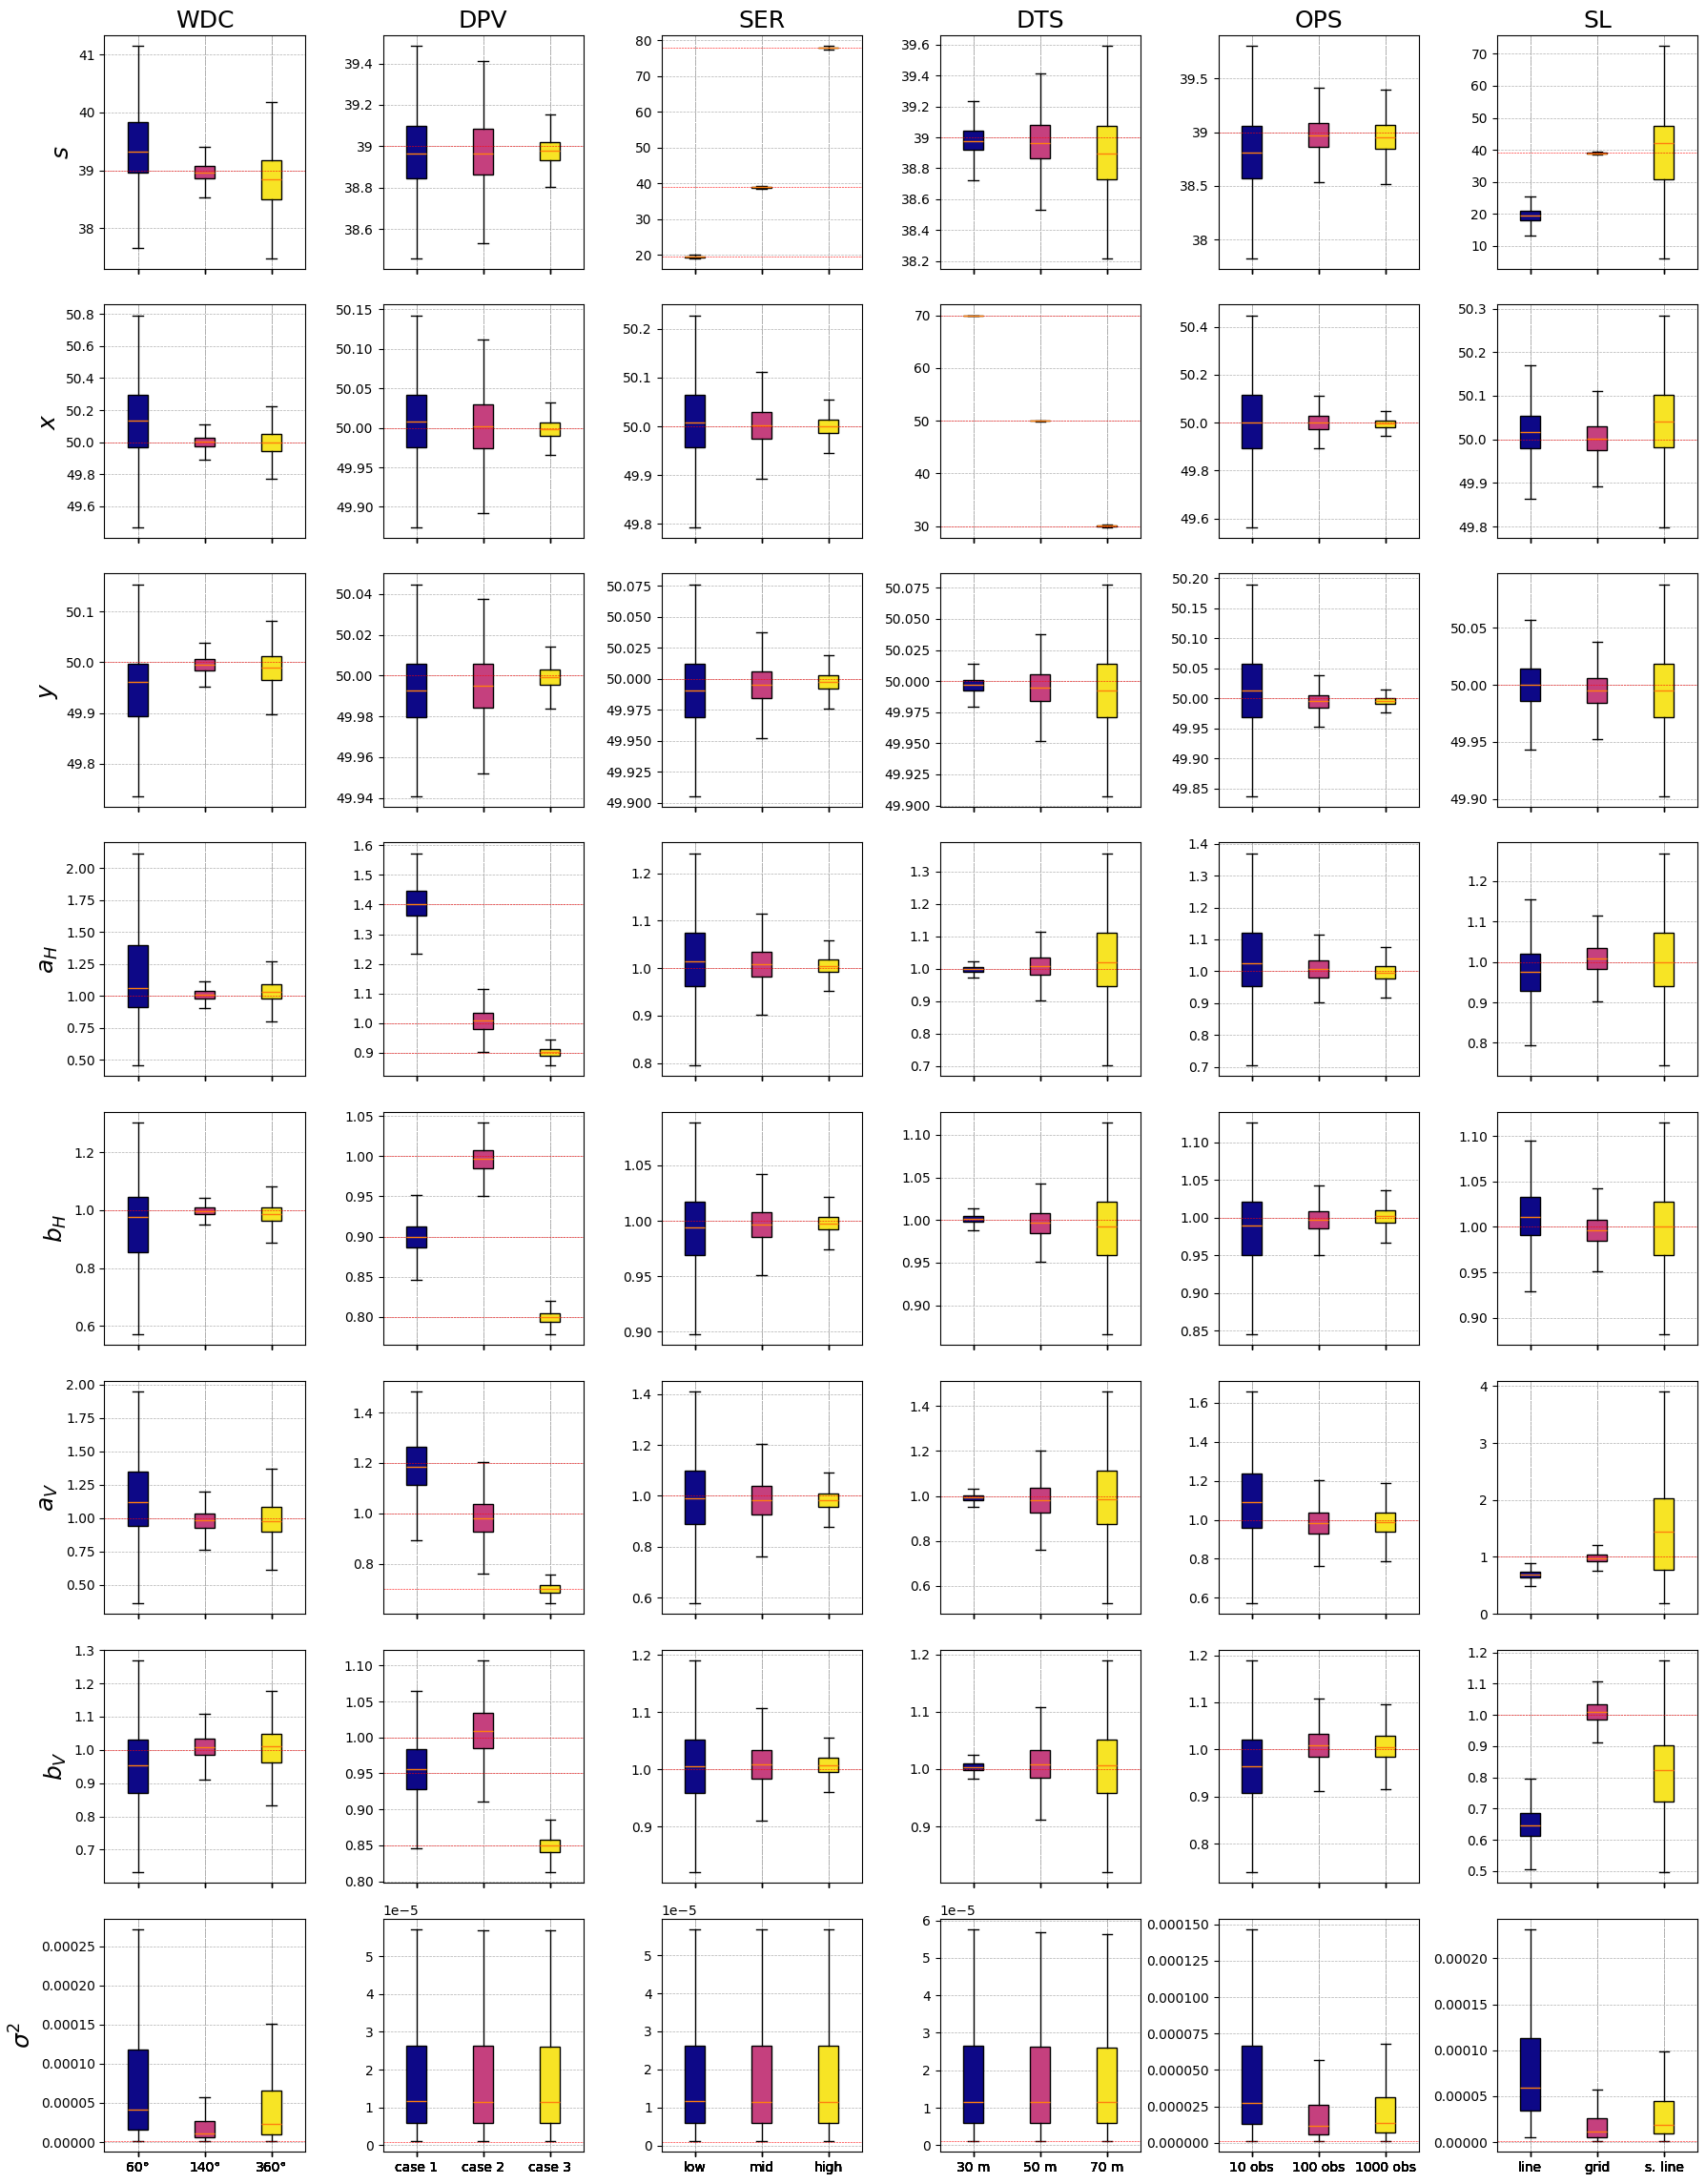

C:\Users\teresa-klatzer\AppData\Local\Temp\ipykernel_16844\3441943836.py:182: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = axs[j, i].boxplot(values, showfliers=False, patch_artist=True, labels=d.keys())
C:\Users\teresa-klatzer\AppData\Local\Temp\ipykernel_16844\3441943836.py:182: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = axs[j, i].boxplot(values, showfliers=False, patch_artist=True, labels=d.keys())
C:\Users\teresa-klatzer\AppData\Local\Temp\ipykernel_16844\3441943836.py:182: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = axs[j, i].boxplot(values, showfliers=False, patch_artist=True, labels=d.key

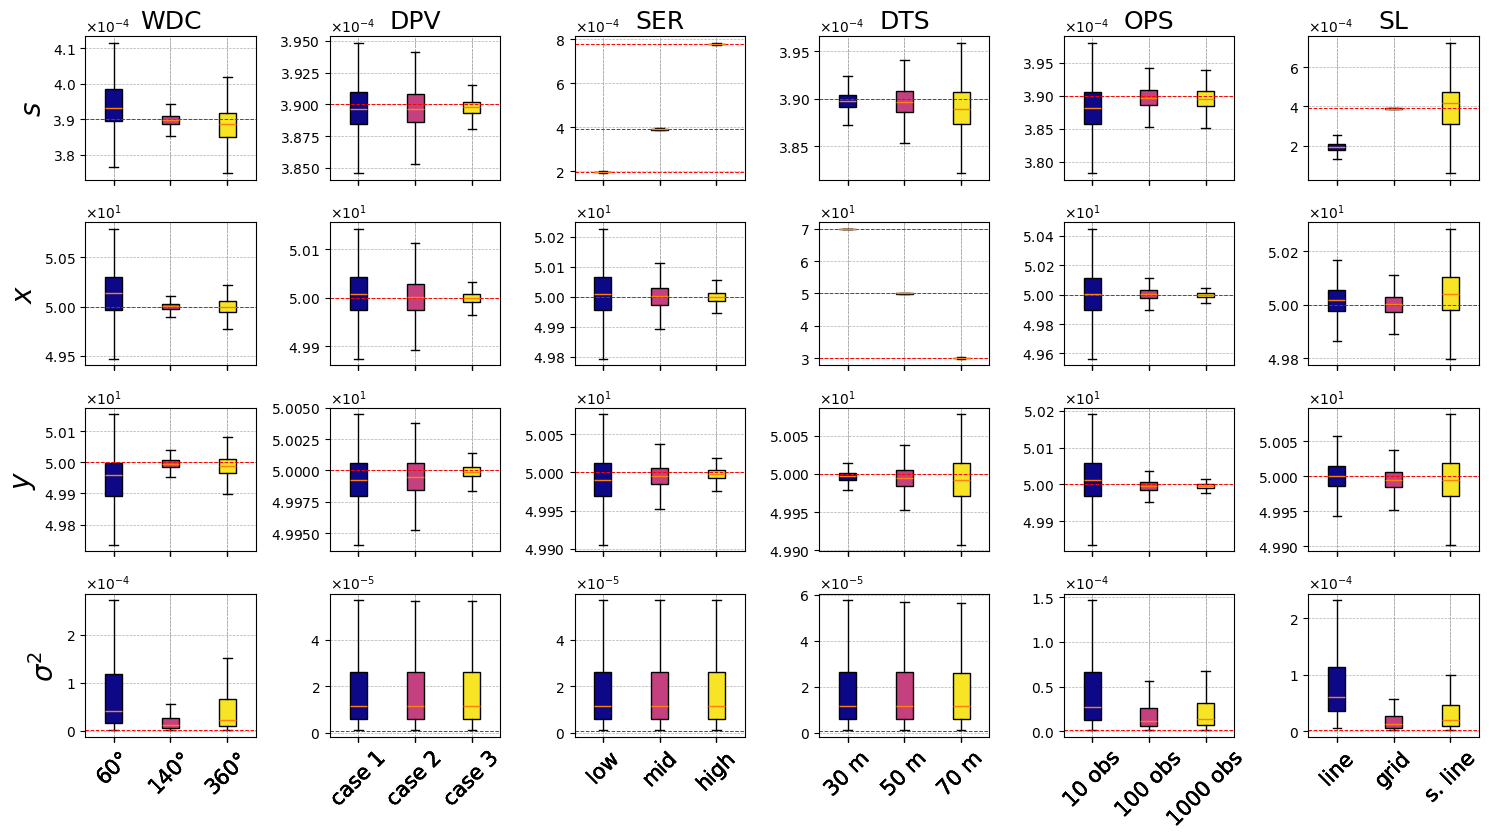

C:\Users\teresa-klatzer\AppData\Local\Temp\ipykernel_16844\3441943836.py:284: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = axs[j, i].boxplot(values, showfliers=False, patch_artist=True, labels=d.keys())
C:\Users\teresa-klatzer\AppData\Local\Temp\ipykernel_16844\3441943836.py:284: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = axs[j, i].boxplot(values, showfliers=False, patch_artist=True, labels=d.keys())
C:\Users\teresa-klatzer\AppData\Local\Temp\ipykernel_16844\3441943836.py:284: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = axs[j, i].boxplot(values, showfliers=False, patch_artist=True, labels=d.key

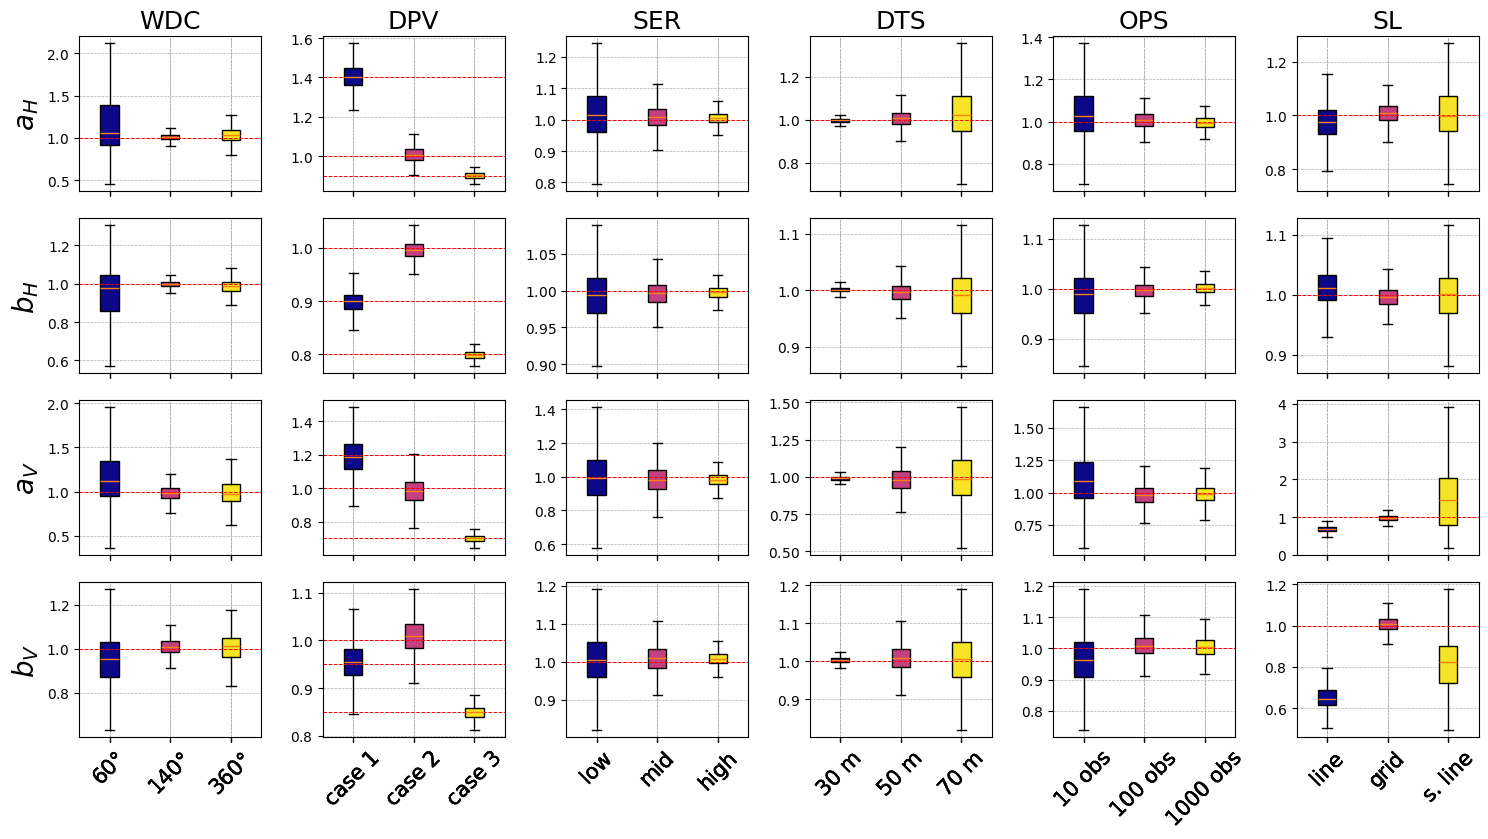

In [32]:
plot_boxplots(all_simulations, 1000, error = False, shared_y = False, save=False)
plot_boxplots_1(all_simulations, 1000, error = False, shared_y = False, save=False)
plot_boxplots_2(all_simulations, 1000, error = False, shared_y = False, save=False)

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br><br><br><br><br><br><br>

# Main paper

# Section 4.2: Estimating Dispersion Parameters

<div class="alert alert-block alert-info">
<b>DATA:</b> Need to replace data file paths with your own local path. The files are all located in the folder:<br>
Paper 1: Code/Data/MCMC_chains/Simulation_study/Estimated vs not estimated wind sigmas/for paper/...
</div>

C:\Users\teresa-klatzer\AppData\Local\Temp\ipykernel_16844\2489030752.py:3: DeprecationWarning: Pickled array contains an aval with a named_shape attribute. This is deprecated and the code path supporting such avals will be removed. Please re-pickle the array.
  center_point = pickle.load(f)
C:\Users\teresa-klatzer\AppData\Local\Temp\ipykernel_16844\2489030752.py:5: DeprecationWarning: Pickled array contains an aval with a named_shape attribute. This is deprecated and the code path supporting such avals will be removed. Please re-pickle the array.
  truth = pickle.load(f)
C:\Users\teresa-klatzer\AppData\Local\Temp\ipykernel_16844\2489030752.py:7: DeprecationWarning: Pickled array contains an aval with a named_shape attribute. This is deprecated and the code path supporting such avals will be removed. Please re-pickle the array.
  zero_six_a_H = pickle.load(f)
C:\Users\teresa-klatzer\AppData\Local\Temp\ipykernel_16844\2489030752.py:9: DeprecationWarning: Pickled array contains an aval w

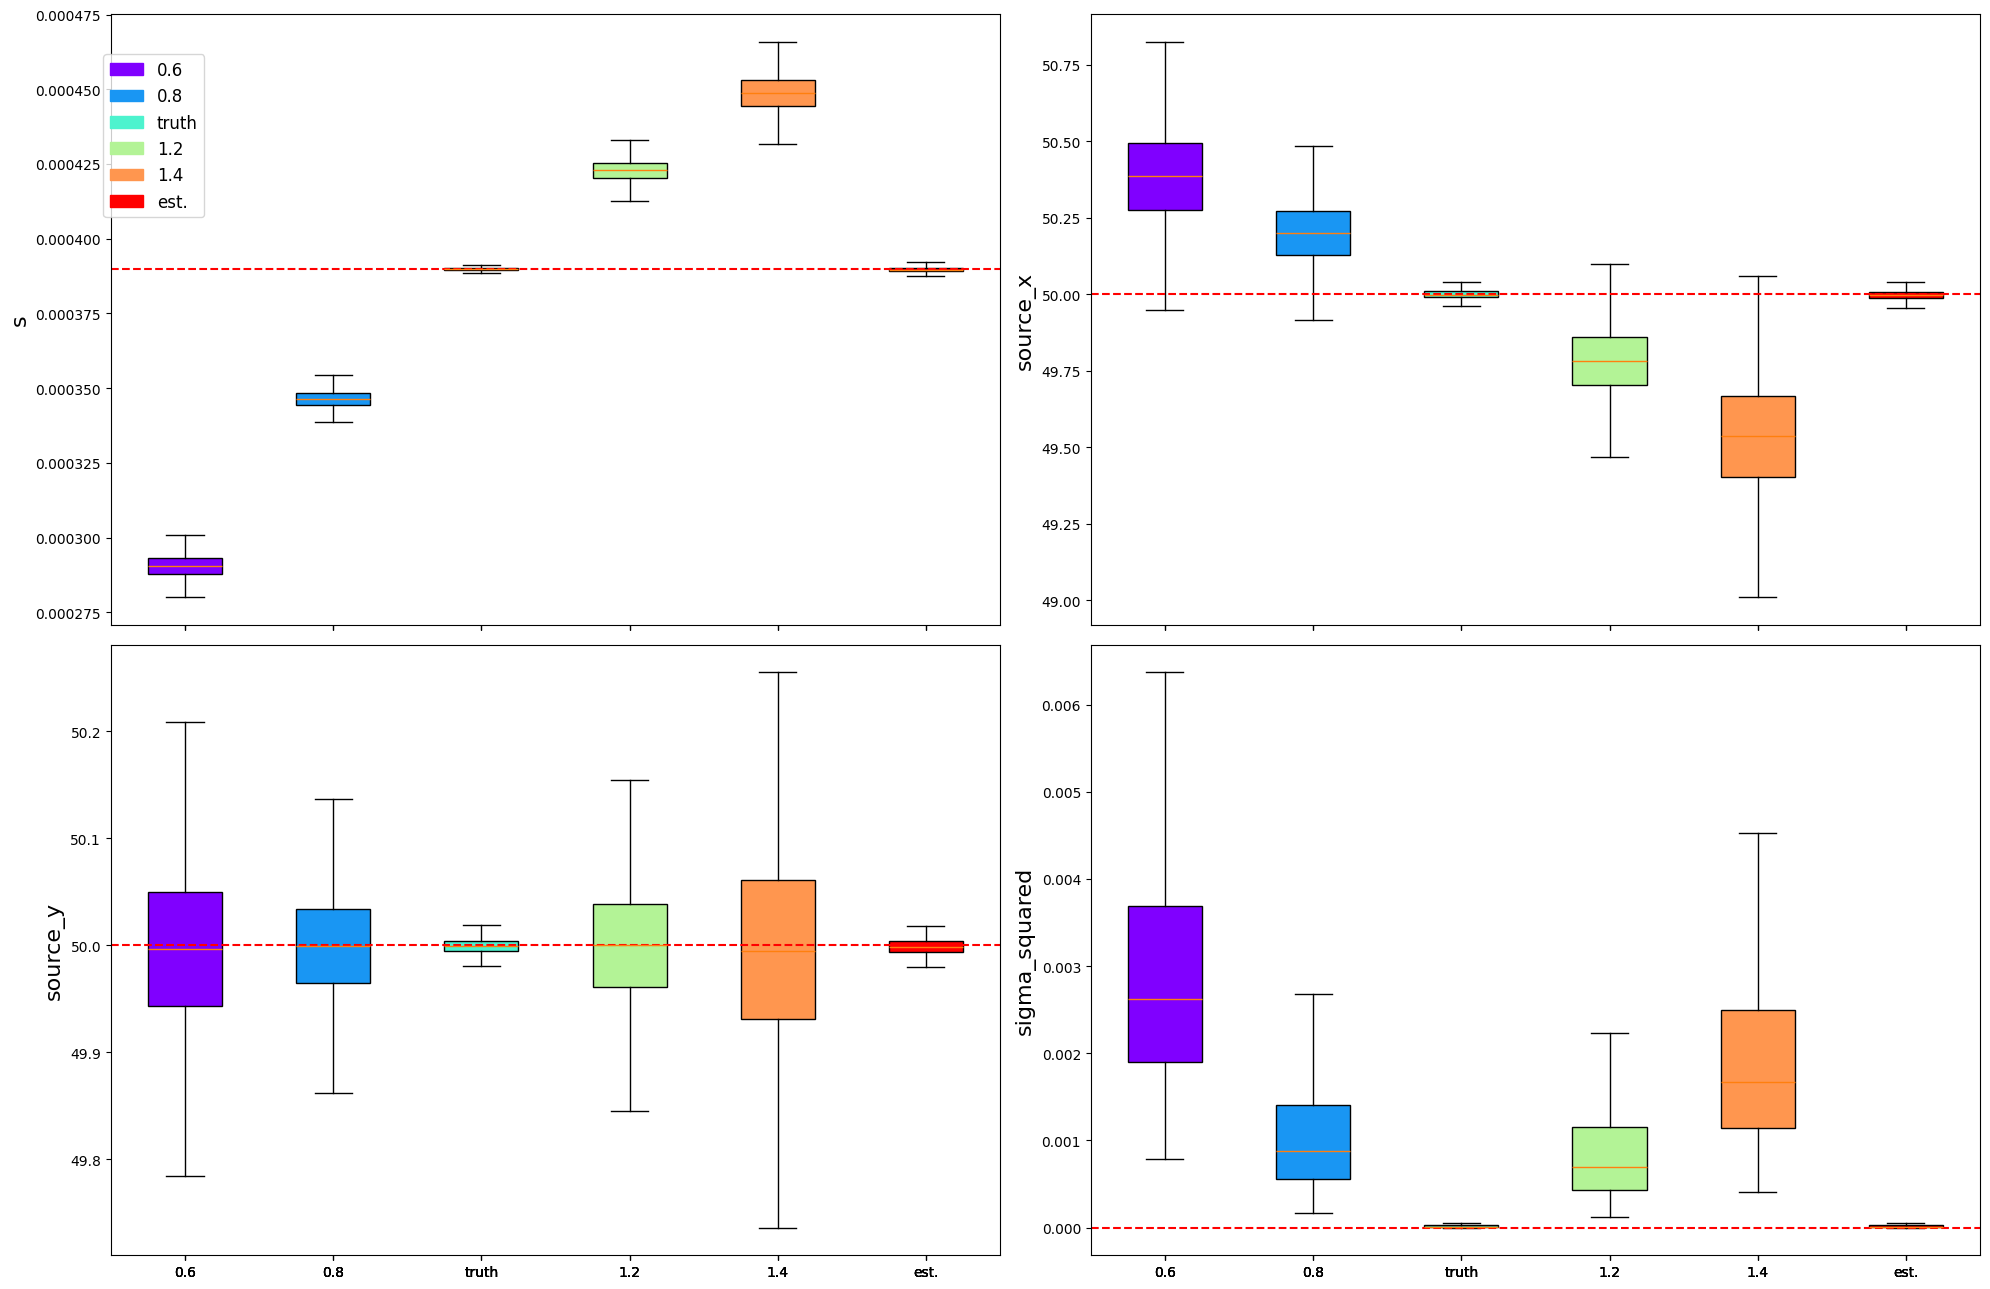

C:\Users\teresa-klatzer\AppData\Local\Temp\ipykernel_16844\2489030752.py:29: DeprecationWarning: Pickled array contains an aval with a named_shape attribute. This is deprecated and the code path supporting such avals will be removed. Please re-pickle the array.
  zero_six_a_V = pickle.load(f)
C:\Users\teresa-klatzer\AppData\Local\Temp\ipykernel_16844\2489030752.py:31: DeprecationWarning: Pickled array contains an aval with a named_shape attribute. This is deprecated and the code path supporting such avals will be removed. Please re-pickle the array.
  zero_eight_a_V = pickle.load(f)
C:\Users\teresa-klatzer\AppData\Local\Temp\ipykernel_16844\2489030752.py:33: DeprecationWarning: Pickled array contains an aval with a named_shape attribute. This is deprecated and the code path supporting such avals will be removed. Please re-pickle the array.
  one_two_a_V = pickle.load(f)
C:\Users\teresa-klatzer\AppData\Local\Temp\ipykernel_16844\2489030752.py:35: DeprecationWarning: Pickled array contai

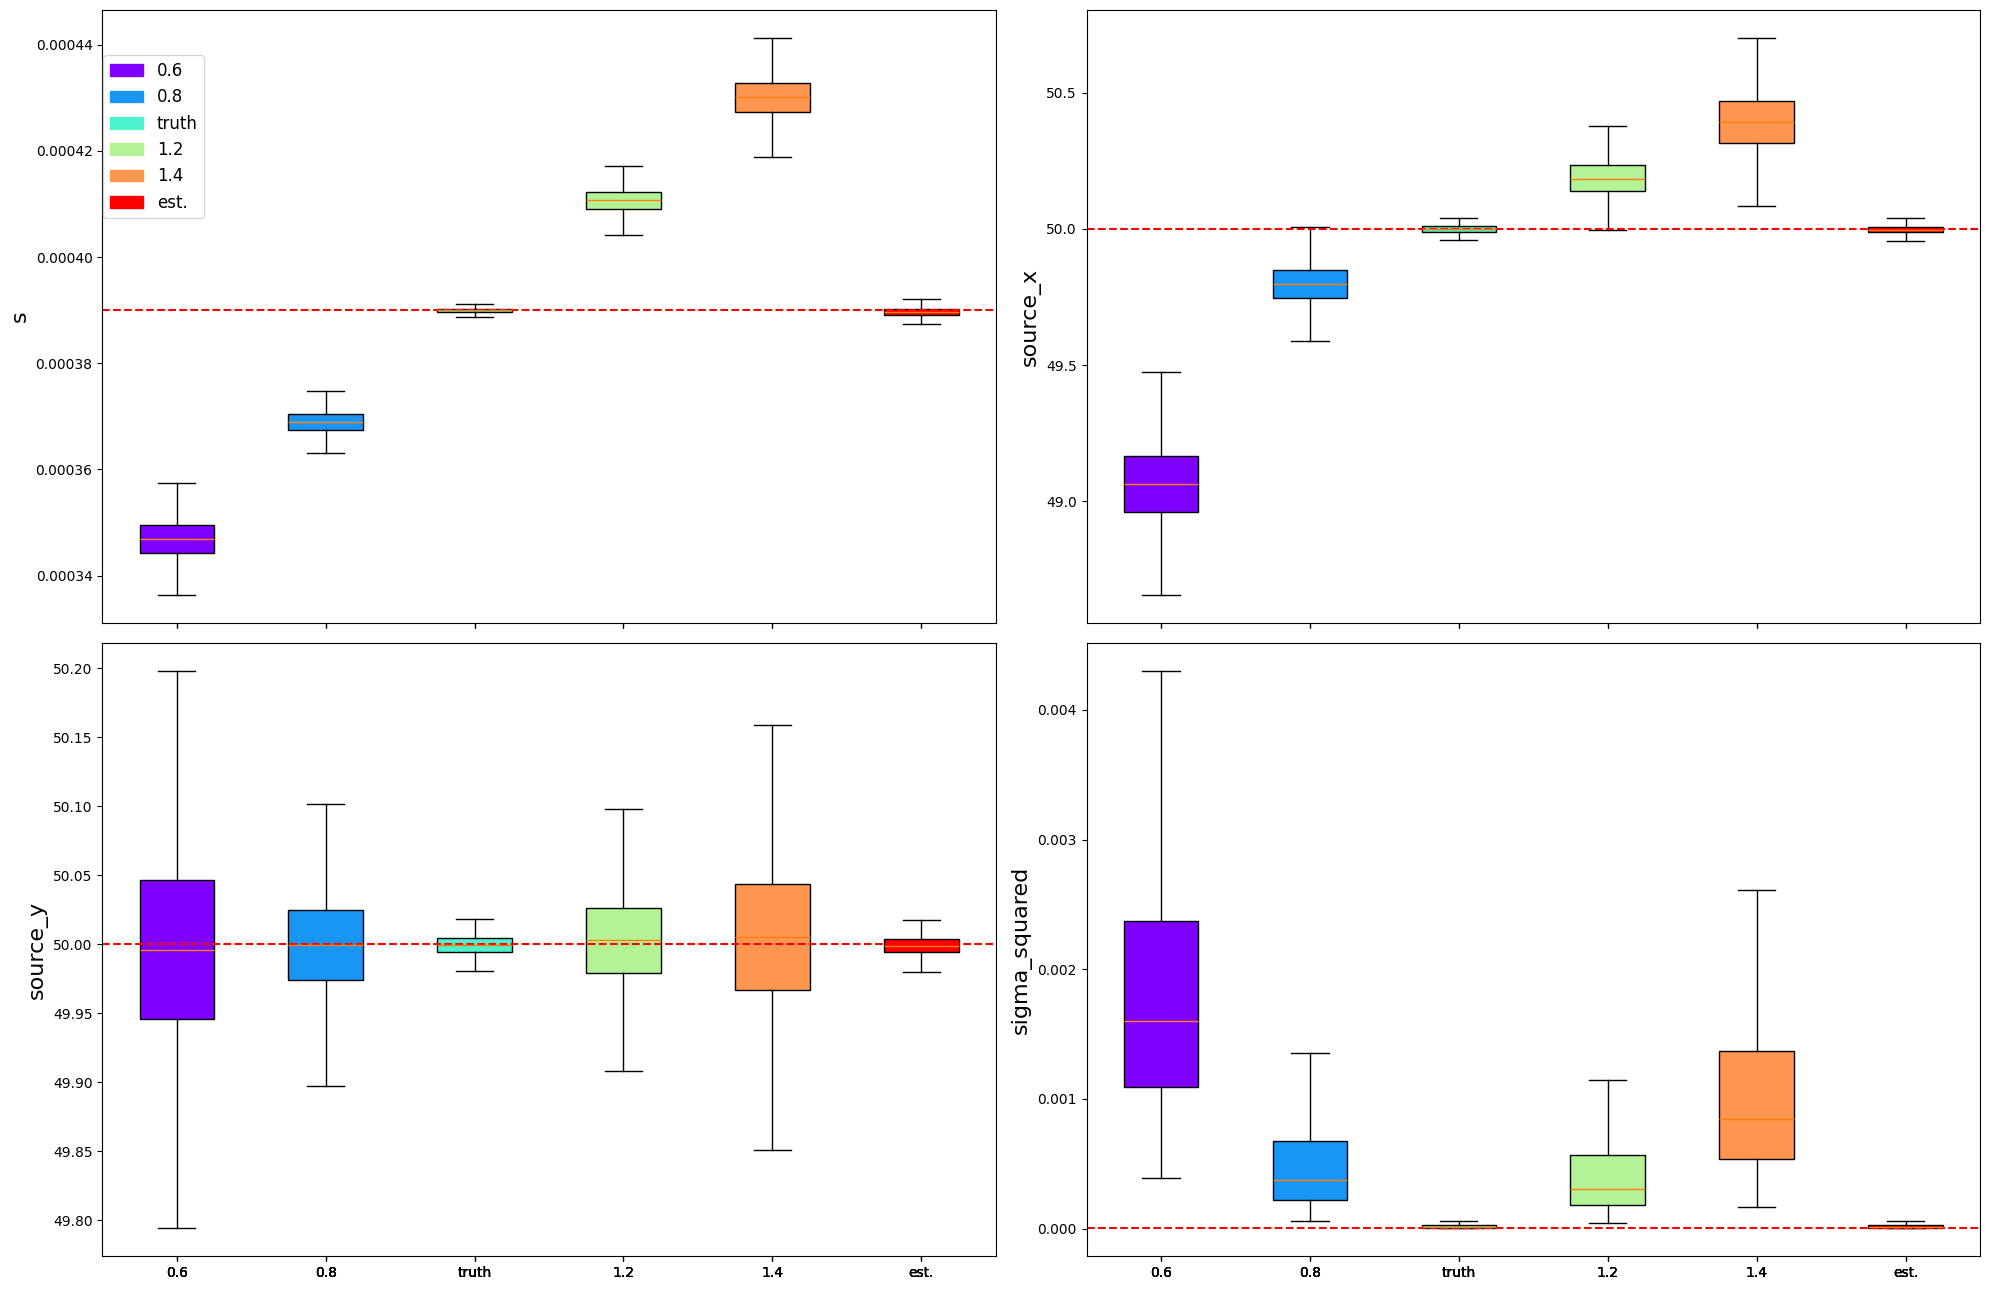

C:\Users\teresa-klatzer\AppData\Local\Temp\ipykernel_16844\2489030752.py:51: DeprecationWarning: Pickled array contains an aval with a named_shape attribute. This is deprecated and the code path supporting such avals will be removed. Please re-pickle the array.
  zero_six_b_H = pickle.load(f)
C:\Users\teresa-klatzer\AppData\Local\Temp\ipykernel_16844\2489030752.py:53: DeprecationWarning: Pickled array contains an aval with a named_shape attribute. This is deprecated and the code path supporting such avals will be removed. Please re-pickle the array.
  zero_seven_b_H = pickle.load(f)
C:\Users\teresa-klatzer\AppData\Local\Temp\ipykernel_16844\2489030752.py:55: DeprecationWarning: Pickled array contains an aval with a named_shape attribute. This is deprecated and the code path supporting such avals will be removed. Please re-pickle the array.
  zero_nine_b_H = pickle.load(f)
C:\Users\teresa-klatzer\AppData\Local\Temp\ipykernel_16844\2489030752.py:57: DeprecationWarning: Pickled array cont

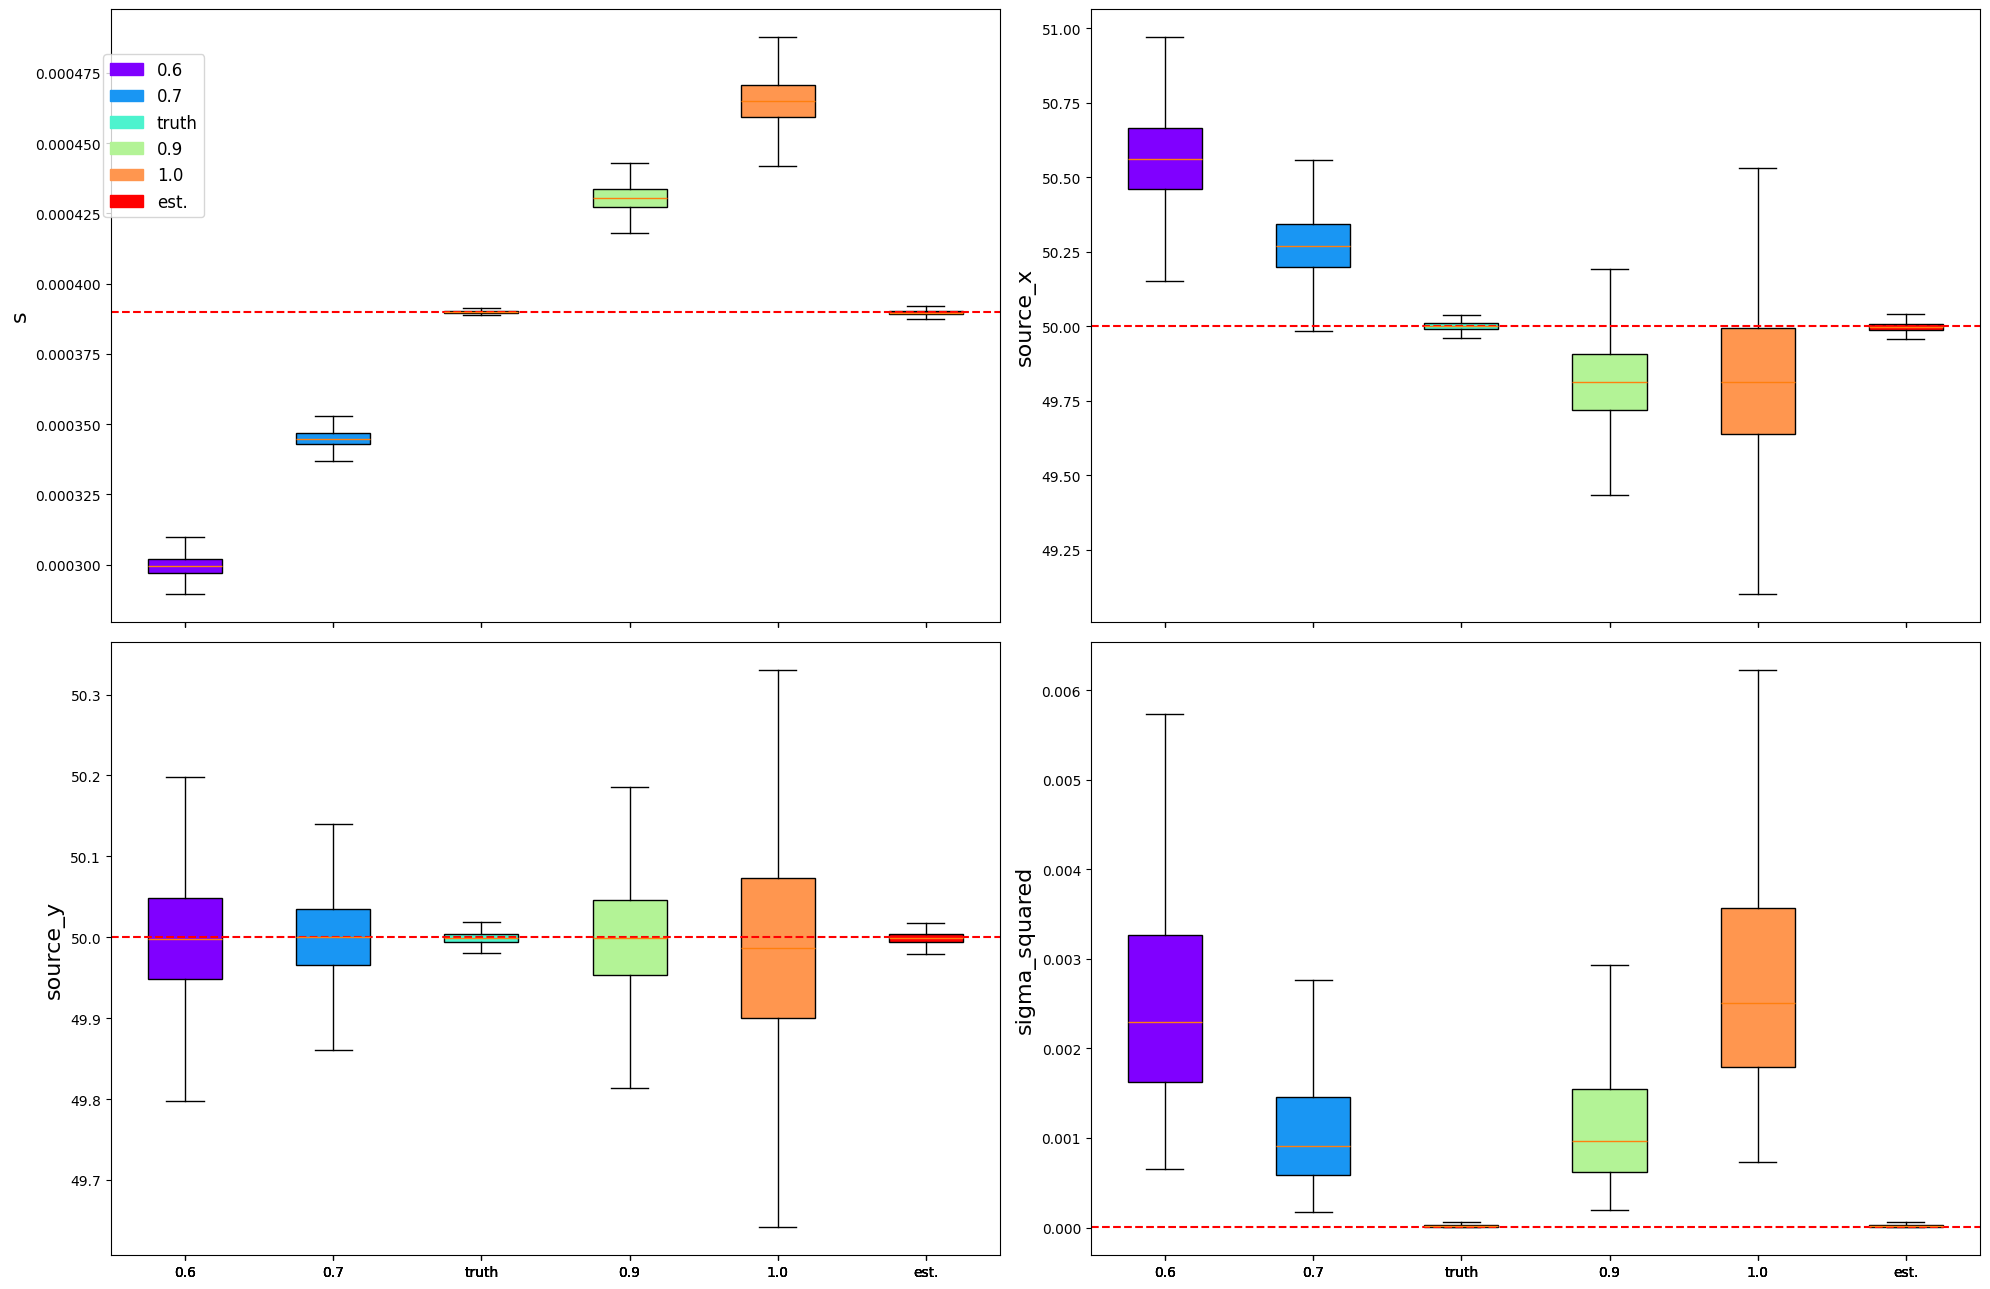

C:\Users\teresa-klatzer\AppData\Local\Temp\ipykernel_16844\2489030752.py:73: DeprecationWarning: Pickled array contains an aval with a named_shape attribute. This is deprecated and the code path supporting such avals will be removed. Please re-pickle the array.
  zero_six_b_V = pickle.load(f)
C:\Users\teresa-klatzer\AppData\Local\Temp\ipykernel_16844\2489030752.py:75: DeprecationWarning: Pickled array contains an aval with a named_shape attribute. This is deprecated and the code path supporting such avals will be removed. Please re-pickle the array.
  zero_seven_b_V = pickle.load(f)
C:\Users\teresa-klatzer\AppData\Local\Temp\ipykernel_16844\2489030752.py:77: DeprecationWarning: Pickled array contains an aval with a named_shape attribute. This is deprecated and the code path supporting such avals will be removed. Please re-pickle the array.
  zero_nine_b_V = pickle.load(f)
C:\Users\teresa-klatzer\AppData\Local\Temp\ipykernel_16844\2489030752.py:79: DeprecationWarning: Pickled array cont

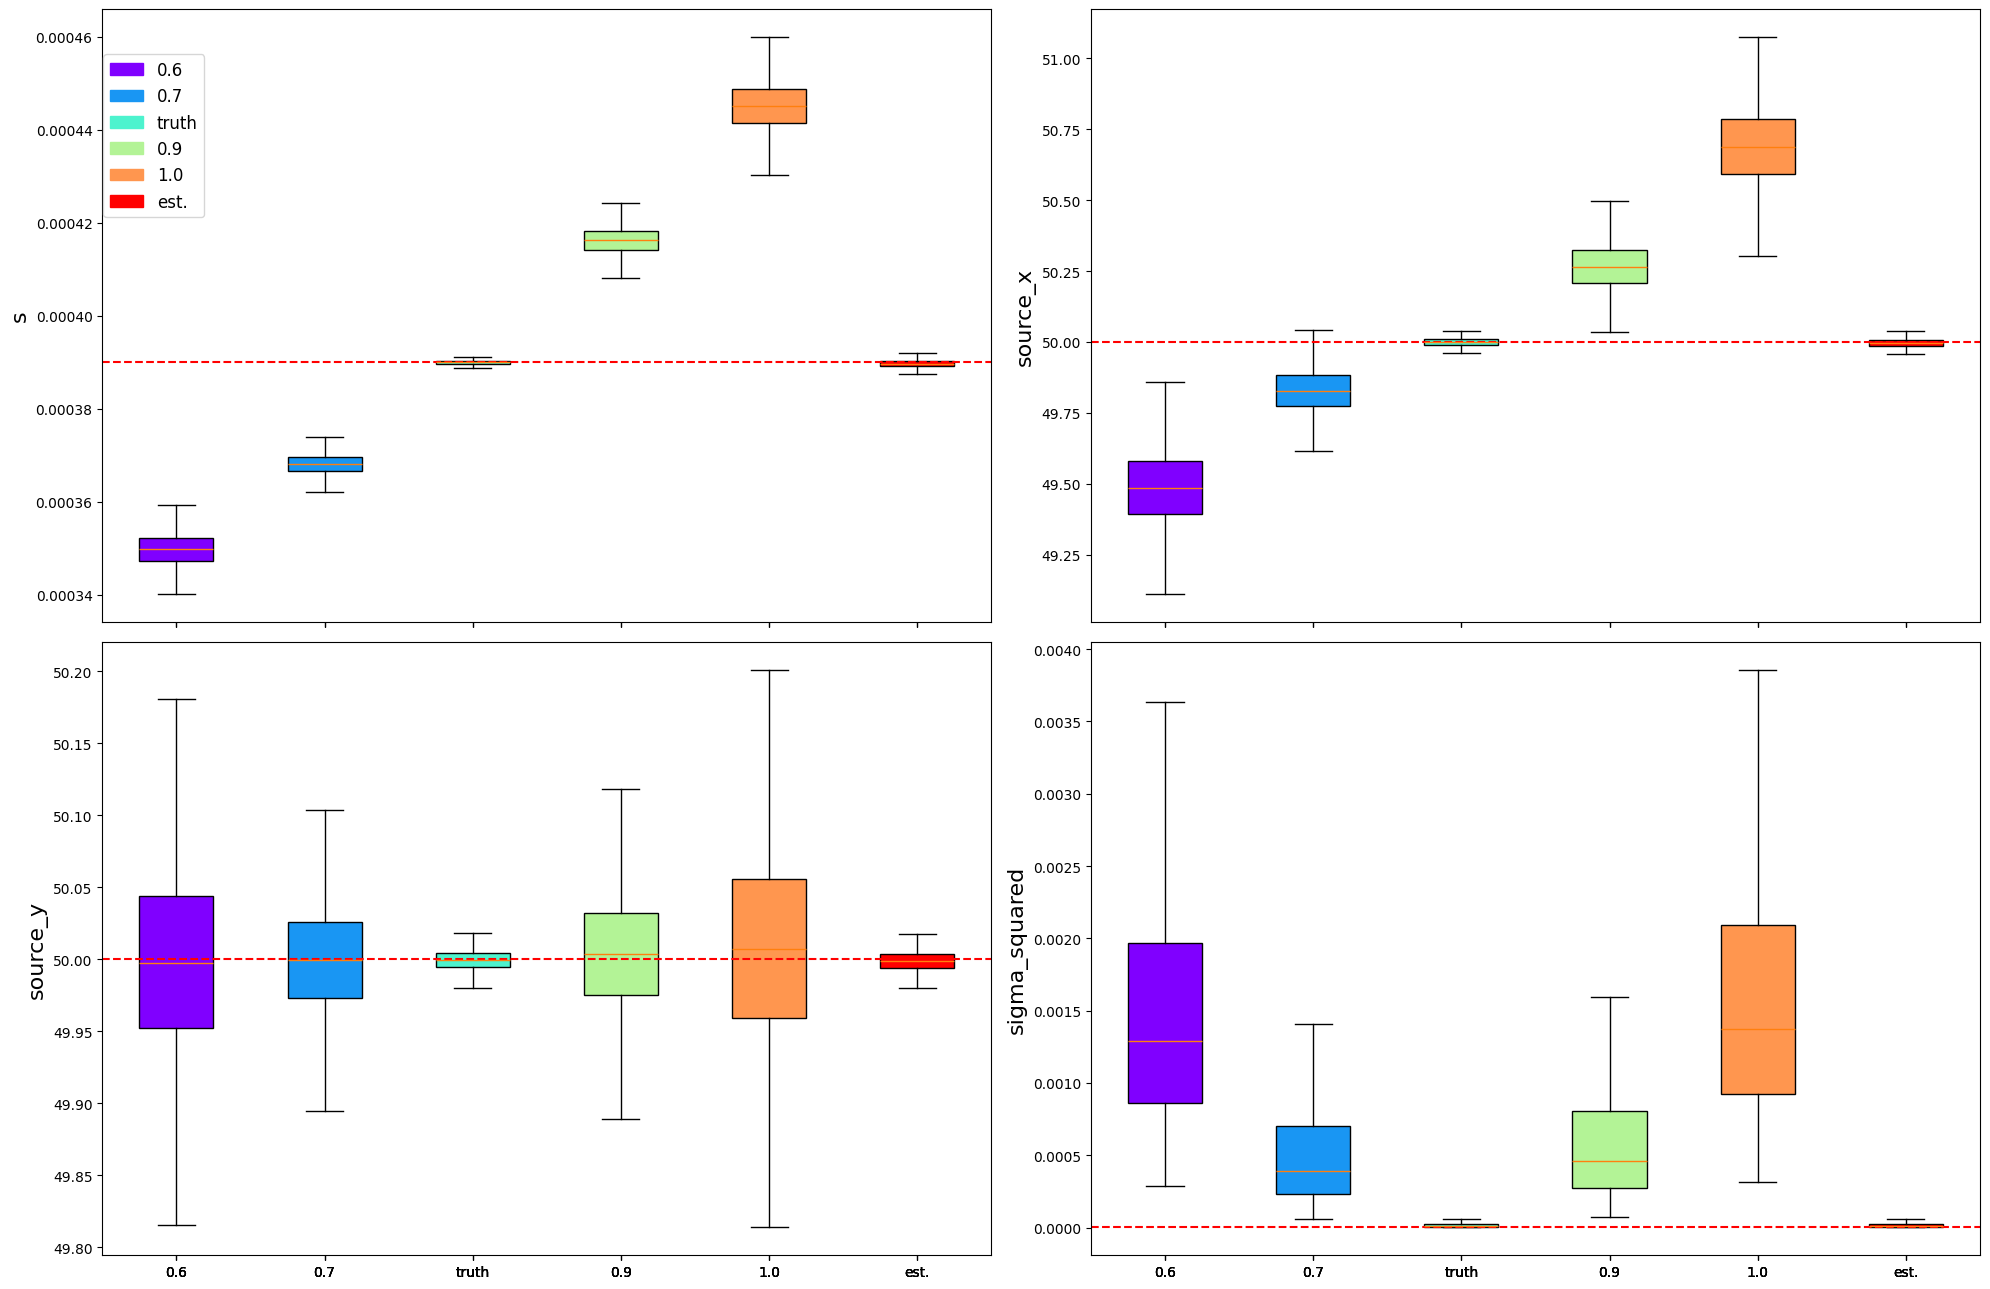

In [33]:

# a_H #
with open('../../Data/MCMC_chains/Simulation_study/Estimated vs not estimated wind sigmas/for paper/center_point_wind_sigmas.pkl', 'rb') as f:
    center_point = pickle.load(f)
with open('../../Data/MCMC_chains/Simulation_study/Estimated vs not estimated wind sigmas/for paper/fixed_to_truth.pkl', 'rb') as f:
    truth = pickle.load(f)
with open('../../Data/MCMC_chains/Simulation_study/Estimated vs not estimated wind sigmas/for paper/0.6_a_H.pkl', 'rb') as f:
    zero_six_a_H = pickle.load(f)
with open('../../Data/MCMC_chains/Simulation_study/Estimated vs not estimated wind sigmas/for paper/0.8_a_H.pkl', 'rb') as f:
    zero_eight_a_H = pickle.load(f)
with open('../../Data/MCMC_chains/Simulation_study/Estimated vs not estimated wind sigmas/for paper/1.2_a_H.pkl', 'rb') as f:
    one_two_a_H = pickle.load(f)
with open('../../Data/MCMC_chains/Simulation_study/Estimated vs not estimated wind sigmas/for paper/1.4_a_H.pkl', 'rb') as f:
    one_four_a_H = pickle.load(f)

missspecify_a_H = {
    '0.6': zero_six_a_H,
    '0.8': zero_eight_a_H,
    'truth': truth,
    '1.2': one_two_a_H,
    '1.4': one_four_a_H,
    'est.': center_point,
}

plot_boxplots_source(missspecify_a_H)


# a_V #
with open('../../Data/MCMC_chains/Simulation_study/Estimated vs not estimated wind sigmas/for paper/0.6_a_V.pkl', 'rb') as f:
    zero_six_a_V = pickle.load(f)
with open('../../Data/MCMC_chains/Simulation_study/Estimated vs not estimated wind sigmas/for paper/0.8_a_V.pkl', 'rb') as f:
    zero_eight_a_V = pickle.load(f)
with open('../../Data/MCMC_chains/Simulation_study/Estimated vs not estimated wind sigmas/for paper/1.2_a_V.pkl', 'rb') as f:
    one_two_a_V = pickle.load(f)
with open('../../Data/MCMC_chains/Simulation_study/Estimated vs not estimated wind sigmas/for paper/1.4_a_V.pkl', 'rb') as f:
    one_four_a_V = pickle.load(f)

missspecify_a_V = {
    '0.6': zero_six_a_V,
    '0.8': zero_eight_a_V,
    'truth': truth,
    '1.2': one_two_a_V,
    '1.4': one_four_a_V,
    'est.': center_point,
}

plot_boxplots_source(missspecify_a_V)


# b_H #
with open('../../Data/MCMC_chains/Simulation_study/Estimated vs not estimated wind sigmas/for paper/0.6_b_H.pkl', 'rb') as f:
    zero_six_b_H = pickle.load(f)
with open('../../Data/MCMC_chains/Simulation_study/Estimated vs not estimated wind sigmas/for paper/0.7_b_H.pkl', 'rb') as f:
    zero_seven_b_H = pickle.load(f)
with open('../../Data/MCMC_chains/Simulation_study/Estimated vs not estimated wind sigmas/for paper/0.9_b_H.pkl', 'rb') as f:
    zero_nine_b_H = pickle.load(f)
with open('../../Data/MCMC_chains/Simulation_study/Estimated vs not estimated wind sigmas/for paper/1.0_b_H.pkl', 'rb') as f:
    one_b_H = pickle.load(f)

missspecify_b_H = {
    '0.6': zero_six_b_H,
    '0.7': zero_seven_b_H,
    'truth': truth,
    '0.9': zero_nine_b_H,
    '1.0': one_b_H,
    'est.': center_point,
}

plot_boxplots_source(missspecify_b_H)


# b_H #
with open('../../Data/MCMC_chains/Simulation_study/Estimated vs not estimated wind sigmas/for paper/0.6_b_V.pkl', 'rb') as f:
    zero_six_b_V = pickle.load(f)
with open('../../Data/MCMC_chains/Simulation_study/Estimated vs not estimated wind sigmas/for paper/0.7_b_V.pkl', 'rb') as f:
    zero_seven_b_V = pickle.load(f)
with open('../../Data/MCMC_chains/Simulation_study/Estimated vs not estimated wind sigmas/for paper/0.9_b_V.pkl', 'rb') as f:
    zero_nine_b_V = pickle.load(f)
with open('../../Data/MCMC_chains/Simulation_study/Estimated vs not estimated wind sigmas/for paper/1.0_b_V.pkl', 'rb') as f:
    one_b_V = pickle.load(f)

missspecify_b_V = {
    '0.6': zero_six_b_V,
    '0.7': zero_seven_b_V,
    'truth': truth,
    '0.9': zero_nine_b_V,
    '1.0': one_b_V,
    'est.': center_point,
}

plot_boxplots_source(missspecify_b_V)


In [34]:
varying_all_diffusion_parameters = [missspecify_a_H, missspecify_b_H, missspecify_a_V, missspecify_b_V]

def plot_boxplots_all_diffusion_parameters(data, burn_in, save=False):
    # Create a figure and a set of subplots
    fig, axs = plt.subplots(3, len(data), figsize=(18, 13), sharex='col', sharey='row')
    plt.style.use('default')
    # Define the variables to plot
    variables = ["s", "source_x", "source_y"]
    variable_labels = ["$s$", "$x$", "$y$"]
    # Get the rainbow colormap
    cmap = plt.get_cmap('plasma')
    # Column titles
    column_titles = ["$a_H$", "$b_H$", "$a_V$", "$b_V$"]
    # True parameter values
    true_values = [0.00039, 50.0, 50.0]



    # For each dictionary in the list
    for i, d in enumerate(data):
        # For each variable
        for j, var in enumerate(variables):
            # Extract the values of the variable from the dictionaries
            values = [inner_d[var].flatten()[burn_in:] for inner_d in d.values()]

            # Plot a boxplot of the values
            box = axs[j, i].boxplot(values, showfliers=False, patch_artist=True, labels=d.keys())
            colors = [cmap(k) for k in np.linspace(0, 1, len(box['boxes']))]
            axs[j,i].ticklabel_format(style='sci', axis='y', scilimits=(0, 0), useMathText=True)
            for patch, color in zip(box['boxes'], colors):
                patch.set_facecolor(color)
            axs[j,i].grid(True, which='both', linestyle='--', lw=0.5)
            if j == 0:
                axs[j,i].axhline(y=true_values[0], color='r', linestyle='--', lw=0.4)
            if j == 1:
                axs[j,i].axhline(y=true_values[1], color='r', linestyle='--', lw=0.4)
            if j == 2:
                axs[j,i].axhline(y=true_values[2], color='r', linestyle='--', lw=0.4)

            # Change the size of the x-axis labels
            axs[j, i].tick_params(axis='both', labelsize=18)    
            # Set the background color of the boxplots to light beige
            
        # Set the title for the column
        axs[0, i].set_title(column_titles[i], fontsize=20)

        # Set the y-axis labels
        for j, var in enumerate(variables):
            axs[j, 0].set_ylabel(variable_labels[j], fontsize=22)
        


    # Adjust the layout of the subplots
    plt.tight_layout()
    if save:
        plt.savefig('boxplots_of_misspecified_wind_sigmas.pdf', dpi=300, bbox_inches='tight', transparent=False)
    # Show the plot
    plt.show()

C:\Users\teresa-klatzer\AppData\Local\Temp\ipykernel_16844\2433137485.py:27: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = axs[j, i].boxplot(values, showfliers=False, patch_artist=True, labels=d.keys())
C:\Users\teresa-klatzer\AppData\Local\Temp\ipykernel_16844\2433137485.py:27: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = axs[j, i].boxplot(values, showfliers=False, patch_artist=True, labels=d.keys())
C:\Users\teresa-klatzer\AppData\Local\Temp\ipykernel_16844\2433137485.py:27: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = axs[j, i].boxplot(values, showfliers=False, patch_artist=True, labels=d.keys()

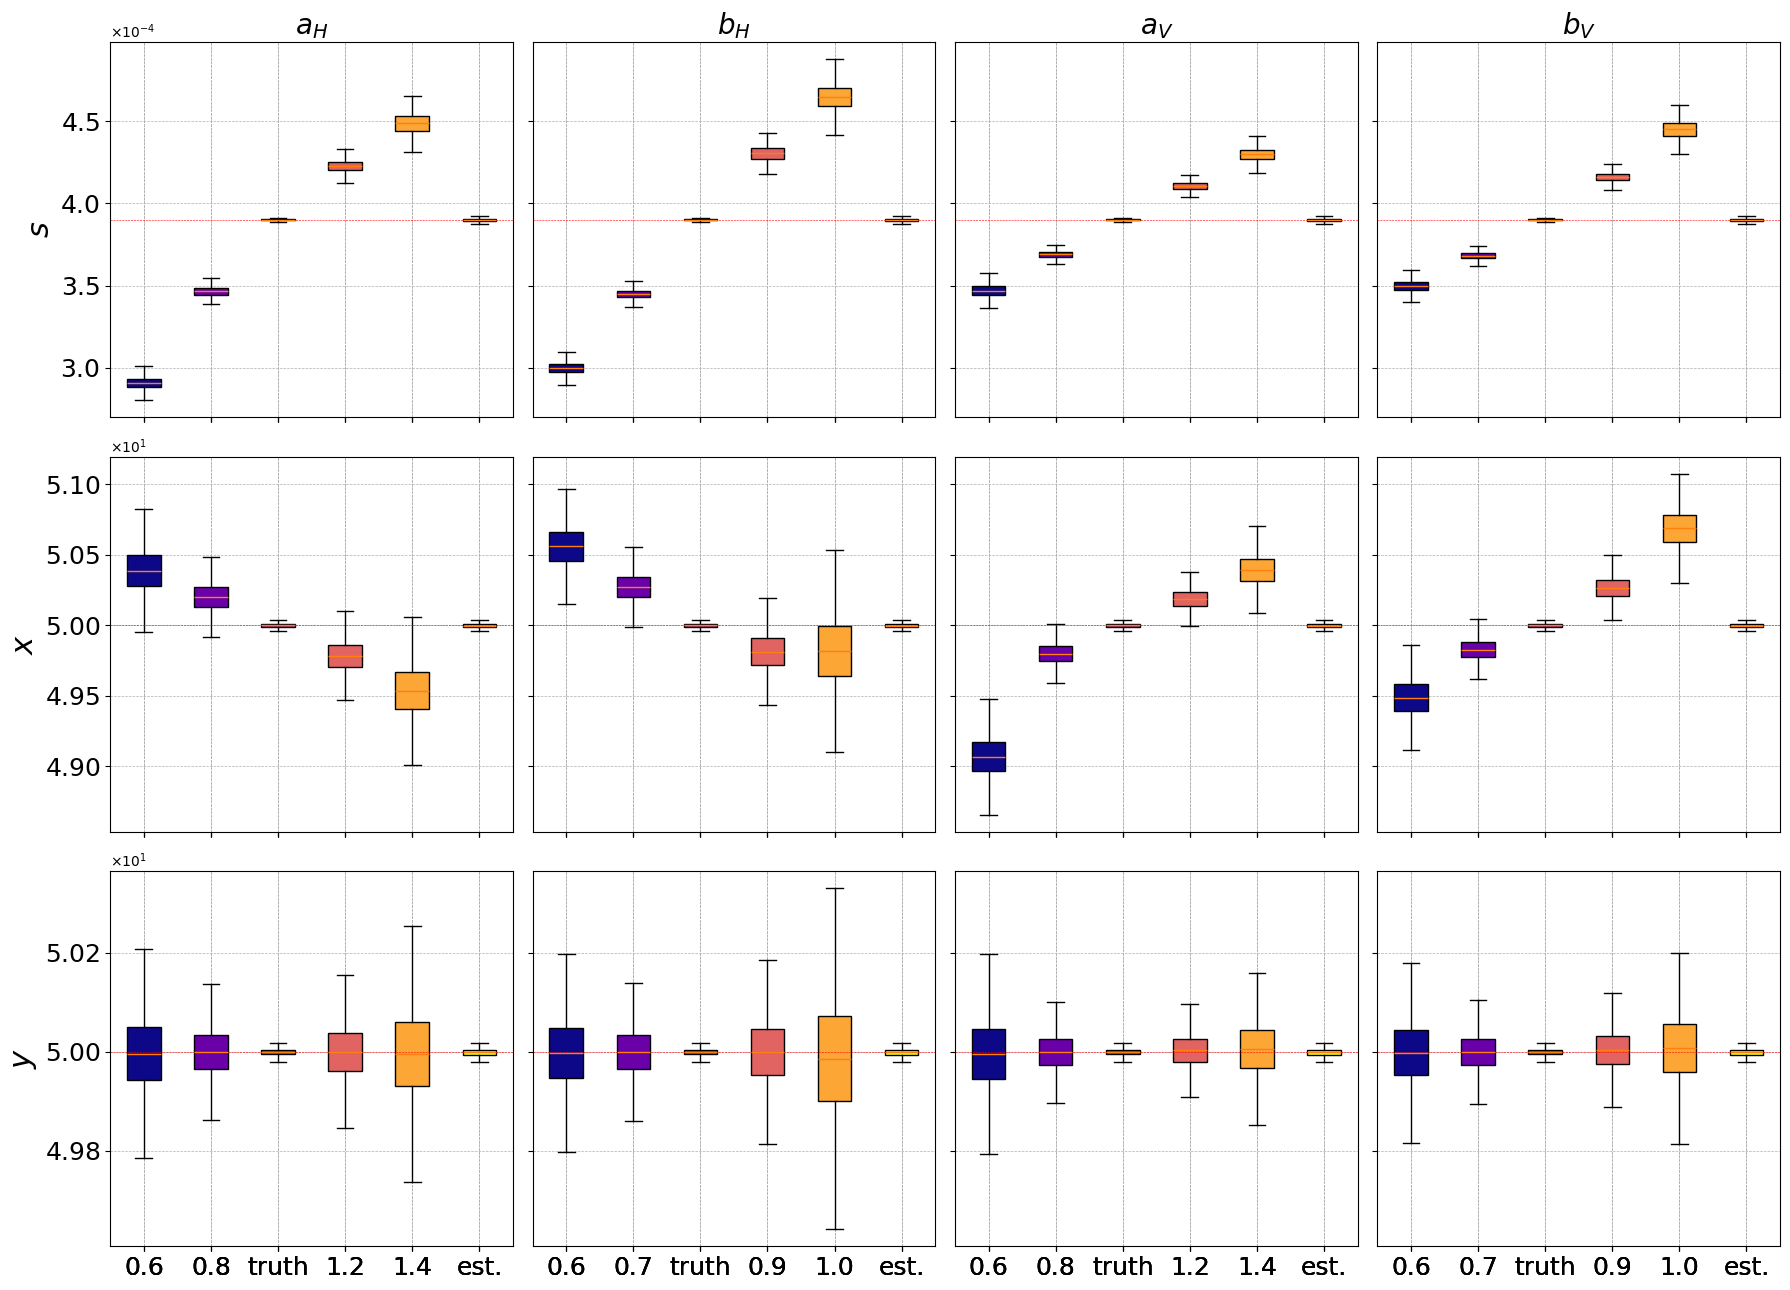

In [35]:
plot_boxplots_all_diffusion_parameters(varying_all_diffusion_parameters, 1000, save=False)

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
